In [50]:
# !pip install gensim
# !pip install wordcloud
# !pip install xgboost
# !pip install transformers
# !pip install torch
# !pip install torch torchvision torchaudio
# !pip freeze > requirements.txt

# To install libraries:
# !pip install -r requirements.txt

In [2]:
import pickle
import numpy as np
import re
import random
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS 
from gensim.models.phrases import Phrases, Phraser
from wordcloud import WordCloud
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.utils import shuffle
from gensim.models.ldamulticore import LdaMulticore# in case use multi-cores


pd.set_option('display.max_colwidth', None)
from gensim.models.ldamulticore import LdaMulticore# in case use multi-cores

In [3]:
random_state = 42

## Pre data files

### prep pkl files

In [4]:
#covert csv files to pkl file
df_youtube = pd.read_csv('assets_2/youtube_parsed_dataset.csv')
df_youtube = df_youtube[['Text', 'oh_label']].rename(columns={'Text': 'text', 'oh_label': 'label'})
df_youtube.to_pickle('assets_2/youtube_data.pkl')

In [5]:
df_kaggle = pd.read_csv('assets_2/kaggle_parsed_dataset.csv')
df_kaggle = df_kaggle[['Text', 'oh_label']].rename(columns={'Text': 'text', 'oh_label': 'label'})
df_kaggle.to_pickle('assets_2/kaggle_data.pkl')

In [6]:
data_twitter= pd.read_pickle(f'assets_2/twitter_data.pkl')
df_twitter = pd.DataFrame(data_twitter)
df_twitter['label'] = df_twitter['label'].apply(lambda x: 1 if x in ["sexism", "racism"] else 0)
df_twitter.to_pickle('assets_2/twitter_data_relabel.pkl')

### prep combined_df

In [7]:
def read_combined_pkl(files):
    """
    combine all datasources
    
    Parameters:
    - files: datasource files names

    Returns:
    - combined dataframe
    """
    dfs = []  

    for file in files:
        data= pd.read_pickle(f'assets_2/{file}.pkl')
        df = pd.DataFrame(data)
        df['filename'] = file
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    return final_df

In [8]:
files = ['formspring_data','wiki_data','twitter_data_relabel','kaggle_data','youtube_data','kaggle_data']
combined_df = read_combined_pkl(files)

In [9]:
combined_df.shape

(165789, 4)

In [10]:
# overview = combined_df.groupby(['filename', 'label']).size().reset_index(name='num_records')
# print(overview)

In [11]:
def remove_duplicates(combined_df):
    duplicates_text = combined_df[combined_df.duplicated(subset=['text','filename'])]
    unique_texts = combined_df['text'].nunique()
    total_texts = len(combined_df)
    duplicate_texts = total_texts - unique_texts

#     print(f"Total texts: {total_texts}")
#     print(f"Unique texts: {unique_texts}")
#     print(f"Duplicate texts: {duplicate_texts}")
    duplicated_rows = combined_df[combined_df.duplicated(subset='text', keep=False)]
    df_sorted = combined_df.sort_values(by='label', ascending=False)
    df_cleaned = df_sorted.drop_duplicates(subset='text', keep='first')
    return df_cleaned

In [12]:
df_cleaned = remove_duplicates(combined_df)

In [13]:
def remove_userId(text):
#     text = " ".join([x.lower() for x in text.split()]) # Case Conversion
#    text = re.sub(r"\S*https?:\S*", '', text) # remove URL links
#    text = ' '.join([x for x in text.split() if not x.startswith('@')]) # remove @UserId for privacy purpose [DL]: what if the user name is not start with @? e.g. ".@aamattyhealy"
    text = re.sub(r'@(?!ck\b|cking\b)(\w+)', '@', text) # remove @UserId for privacy purpose
    return text.strip()

In [14]:
df_cleaned['text'] = df_cleaned['text'].apply(lambda x: remove_userId(str(x)))

In [15]:
df_cleaned['label'].value_counts()

0    134099
1     22593
Name: label, dtype: int64

## Prep and explore df

### Select df and sample data

you can select your dataframe: balance or imbalance; you can select all_sources, or [list of selected sources]

In [16]:
filename_full_list = df_cleaned.filename.unique()

In [17]:
filename_full_list

array(['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data', 'youtube_data'], dtype=object)

In [18]:
def select_df(balance_YN, filename_list):
    
    def balance_data_stratified(df):
        """
        Balance the dataframe by keeping all rows where label=1 
        and stratified sampling based on 'filename' for label=0.

        Parameters:
        - df: Input DataFrame

        Returns:
        - Balanced DataFrame
        """
        unique_strata = df['filename'].unique()
        samples = []
        for stratum in unique_strata: 
        # Separate the dataframe based on 'label'
            pos_samples = df[(df['filename'] == stratum) & (df['label'] == 1)]
            num_samples = len(pos_samples)

            neg_samples = df[(df['filename'] == stratum) & (df['label'] == 0)].sample(num_samples, random_state=random_state)
            samples.extend(pos_samples.index.tolist())
            samples.extend(neg_samples.index.tolist())

        balanced_sample = df.loc[samples].copy()

        return balanced_sample

    if balance_YN == 'Y':
        df = balance_data_stratified(df_cleaned)
    else:
        df= df_cleaned
    df_selected = df[df['filename'].isin(filename_list)]
    return df_selected
        
        

In [19]:
balance_YN = 'N'
filename_list =['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data']
result_df = select_df(balance_YN, filename_list)

In [20]:
#function to show the distribution per file
def show_file_distribution(df):
    pivot_data = df.groupby(['filename', 'label']).size().unstack().reset_index()
    pivot_data['total_records'] = pivot_data.sum(axis=1)
    pivot_data = pivot_data.sort_values(by='total_records', ascending=False).drop(columns='total_records')
    print(pivot_data)
    pivot_data.set_index('filename').plot(kind='bar', stacked=False)
    plt.title('Number of Records per File by Label')
    plt.ylabel('Number of Records')
    plt.xlabel('Filename')
    plt.xticks(rotation=45)
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_218875/612396244.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pivot_data['total_records'] = pivot_data.sum(axis=1)


label              filename       0      1
3                 wiki_data  102099  13568
2      twitter_data_relabel   11033   5054
0           formspring_data   11955    776
1               kaggle_data    5967   2778


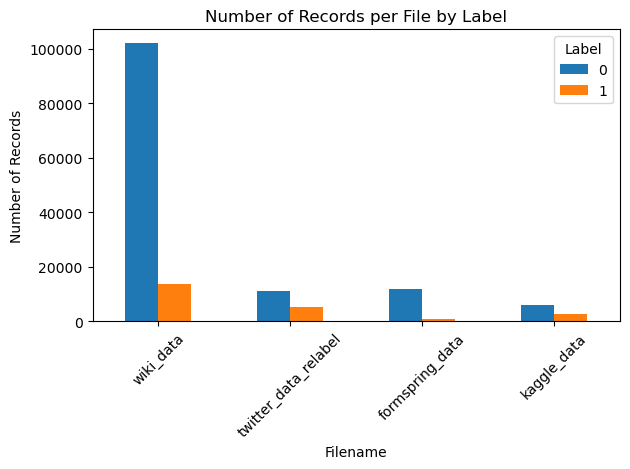

In [21]:
show_file_distribution(result_df)

### add features

In [22]:
# add additional columns text_len, hashtag_count, mention_count,capital_percentage
def text_len(text):
    return len(text.split())

def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return text.count('@')

def capital_percentage(text):
    if len(text) == 0:
        return 0
    return sum(1 for char in text if char.isupper()) / len(text) * 100

def count_urls(text):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    return len(urls)

In [23]:
#result_df = result_df.copy().dropna()
result_df['text_len'] = result_df['text'].apply(text_len)
result_df['hashtag_count'] = result_df['text'].apply(count_hashtags)
result_df['mention_count'] = result_df['text'].apply(count_mentions)
result_df['capital_letter_pct'] = result_df['text'].apply(capital_percentage)
result_df['url_count'] = result_df['text'].apply(count_urls)

/tmp/ipykernel_218875/315527745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['text_len'] = result_df['text'].apply(text_len)
/tmp/ipykernel_218875/315527745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['hashtag_count'] = result_df['text'].apply(count_hashtags)
/tmp/ipykernel_218875/315527745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [24]:
result_df.filename.unique()

array(['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data'], dtype=object)

### Visualize features to understand selected df

In [25]:
def compare_cb_non_cb_statistics(balanced_df):
    features = ['text_len', 'hashtag_count', 'mention_count','capital_letter_pct','url_count']
    cb_df = balanced_df[balanced_df['label'] == 1]
    non_cb_df= balanced_df[balanced_df['label'] == 0]
    
    print("cb_df Descriptive Stats:")
    print(cb_df[features].describe())

    print("\n non_cb_df Descriptive Stats:")
    print(non_cb_df[features].describe())

    for feature in features:
        plt.figure(figsize=(8, 4))

        # Histograms
        plt.hist(cb_df[feature], alpha=0.5,  label="Cyberbullying", color='red')
        plt.hist(non_cb_df[feature], alpha=0.5,  label="Non_Cyberbullying", color='blue')
        plt.legend(loc='upper right')
        plt.title(f"Histogram Comparison of {feature}")
        plt.show()

    #     # Boxplots
    #     plt.figure(figsize=(8, 6))
    #     plt.boxplot([cb_df[feature], non_cb_df[feature]], labels=["Cyberbullying", "Non_Cyberbullying"])
    #     plt.title(f"Boxplot Comparison of {feature}")
    #     plt.show()

        #violin
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='label', y=feature, data=balanced_df, palette={1: 'red', 0: 'blue'}, order=[1, 0])
        plt.title(f"Violin Plot Comparison of {feature} by Label")
        plt.show()

cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  22176.000000   22176.000000   22176.000000        22176.000000   
mean      45.518714       0.105880       0.364674            0.820004   
std      134.038470       0.442367       3.743380            5.611736   
min        1.000000       0.000000       0.000000            0.000000   
25%       12.000000       0.000000       0.000000            0.000000   
50%       20.000000       0.000000       0.000000            0.000000   
75%       36.000000       0.000000       0.000000            0.000000   
max     2832.000000       9.000000     528.000000           89.473684   

          url_count  
count  22176.000000  
mean       0.045319  
std        0.276673  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       15.000000  

 non_cb_df Descriptive Stats:
            text_len  hashtag_count  mention_count  capital_letter_pct  \
count  131054.

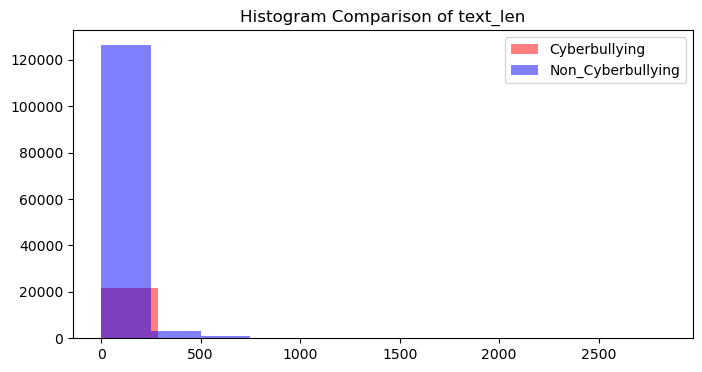

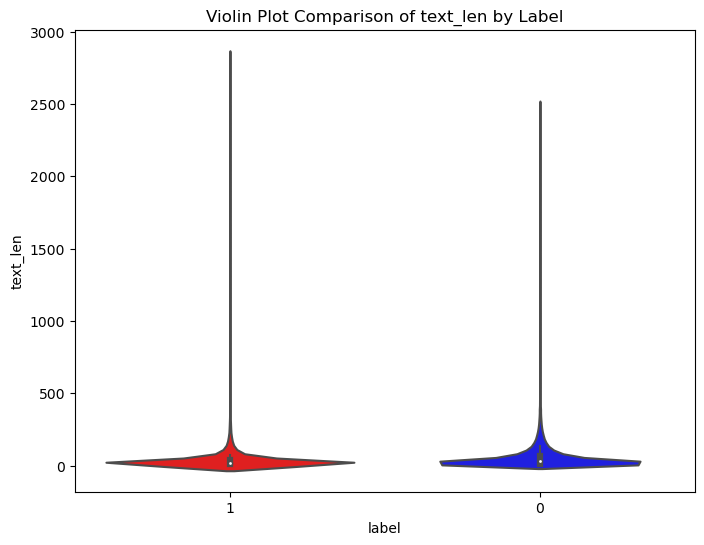

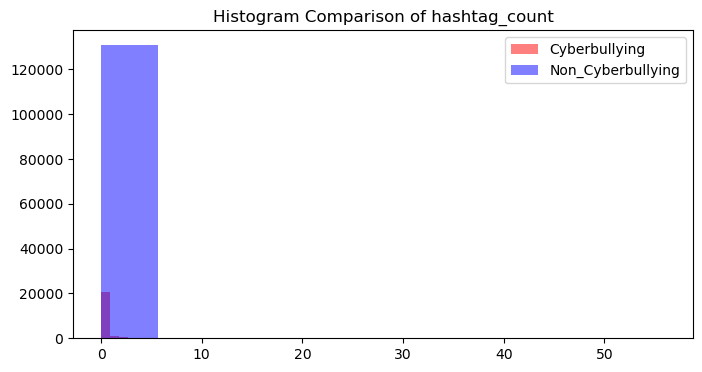

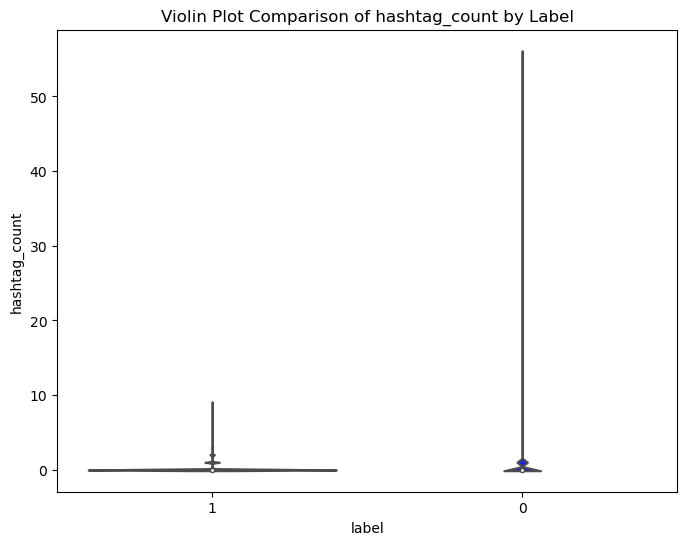

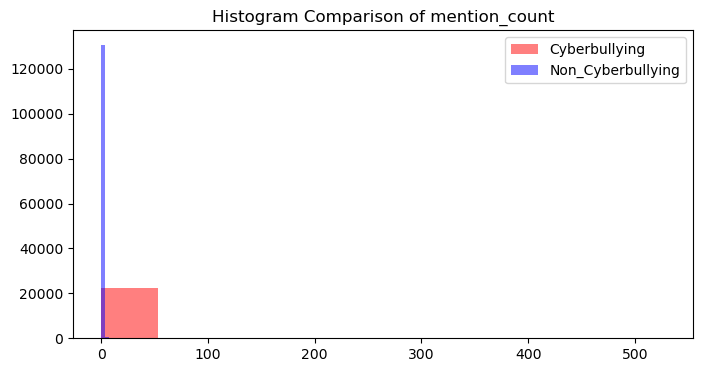

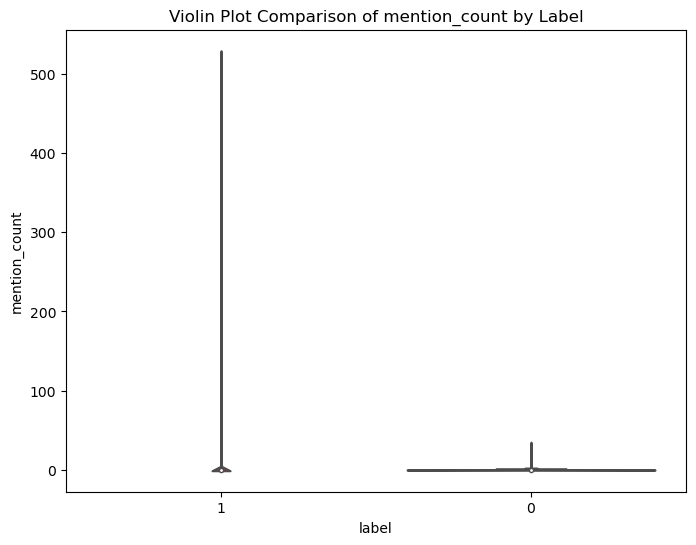

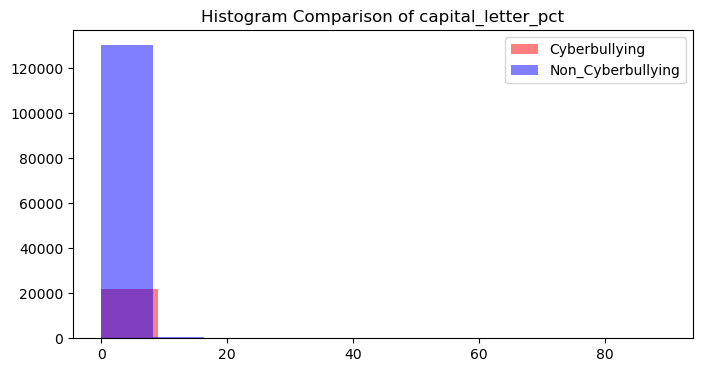

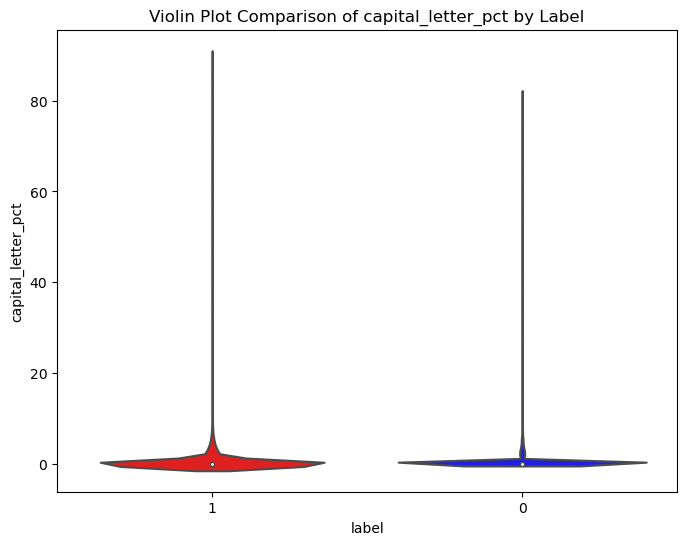

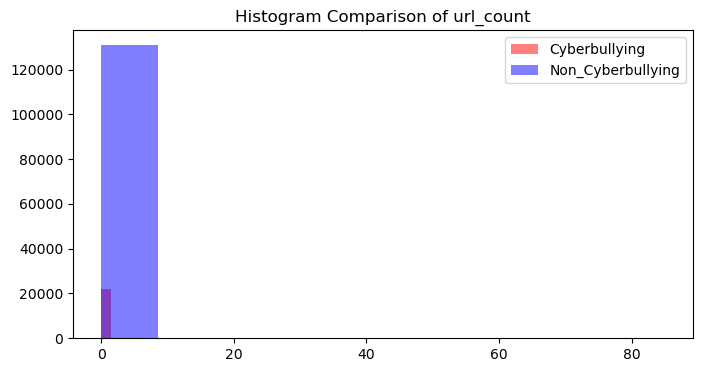

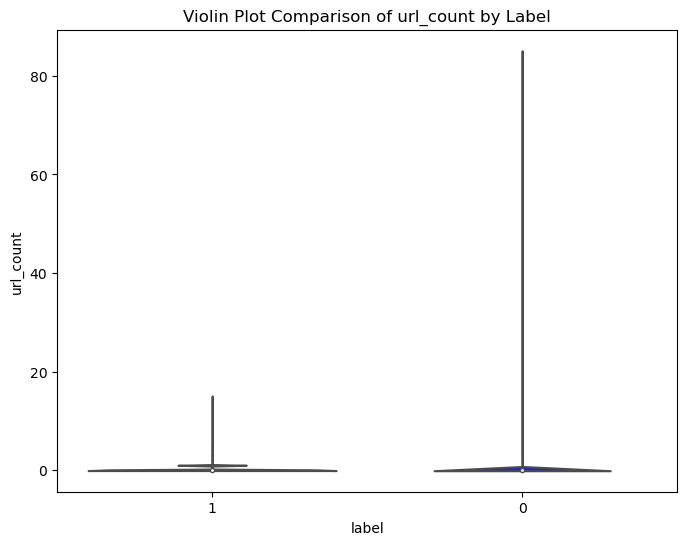

In [26]:
compare_cb_non_cb_statistics(result_df)

In [27]:
result_df.filename.unique()

array(['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data'], dtype=object)

## Feature engineering

### clean and tokenize text

In [28]:
#need to modify the stopwords
CUSTOM_STOP_WORDS = ['www','tinyurl','com', 'https', 'http', '&amp', 'rt', 'bit', 'ly', 'bitly']
CUSTOM_STOP_WORDS_excl_wiki = ['wiki','wikipedia','articl','page','www','tinyurl','com', 'https', 'http','&amp', 'rt', 'bit', 'ly', 'bitly']

In [29]:
def clean_tokenize_text(df,stopwords):

    df['Text'] = df['text'].astype(str)
    stop_words = STOPWORDS.union(set(stopwords))
    df['tokens'] = df['text'].apply(lambda x :preprocess_string(x) ) #
    
    def remove_sw(token): 
        return [word for word in token if not word in stop_words]
    
    df['tokens'] = df['tokens'].apply(lambda token:remove_sw(token))
    return df

In [30]:
df_tokens = clean_tokenize_text(result_df,CUSTOM_STOP_WORDS_excl_wiki)


/tmp/ipykernel_4040778/2205382533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['text'].astype(str)
/tmp/ipykernel_4040778/2205382533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['text'].apply(lambda x :preprocess_string(x) ) #
/tmp/ipykernel_4040778/2205382533.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [31]:
#add bigrams
def bigrams(df):

    tokens = df['tokens']
    phrases = Phrases(tokens, min_count = 20).freeze()
    df['bi_gram'] = df['tokens'].apply(lambda token:phrases[token])
    df['uni_gram'] = df['tokens']
    return df

In [32]:
df_bigrams = bigrams(df_tokens)

/tmp/ipykernel_4040778/276445026.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bi_gram'] = df['tokens'].apply(lambda token:phrases[token])
/tmp/ipykernel_4040778/276445026.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['uni_gram'] = df['tokens']


In [33]:
df_bigrams['filename'].unique()

array(['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data'], dtype=object)

### Visualize tokens

In [34]:
def generate_worldcloud_vis(df_bigrams):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    for token in tokens:

        no_cb_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 0][token]])
        cb_tokens= ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 1][token]])

        # Create the word clouds
        wordcloud_no_cb = WordCloud(background_color='white',collocations=False).generate(no_cb_tokens)
        wordcloud_cb = WordCloud(background_color='white',collocations=False).generate(cb_tokens)

        plt.figure(figsize=(16, 8))

        # Word cloud for cb
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_cb, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cyberbullying_{token}' ) 

        # Word cloud for no_cb
        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_no_cb, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Non_Cyberbullying_{token}')

        plt.tight_layout()
        plt.show()

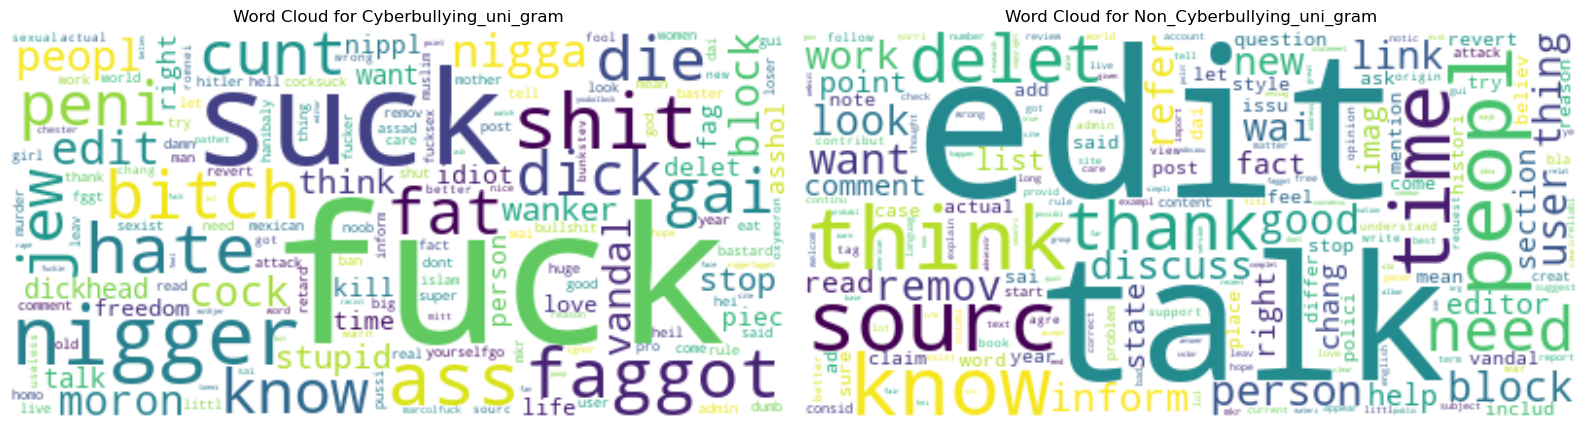

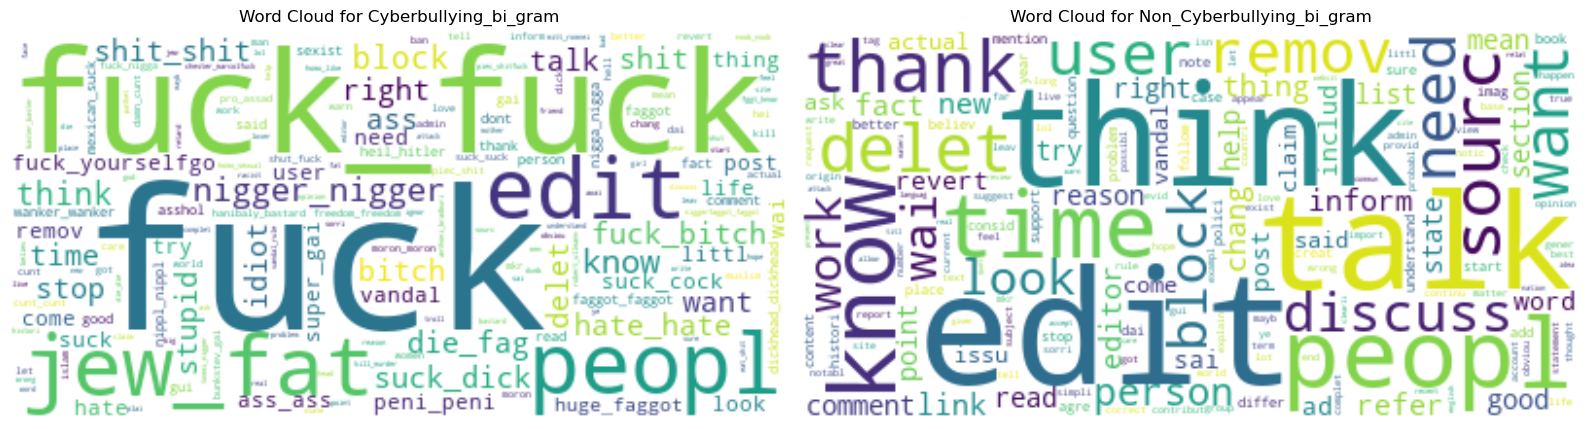

In [35]:
generate_worldcloud_vis(df_bigrams)

In [36]:
#all data
def generate_worldcloud_vis(df_bigrams):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    for token in tokens:

        all_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[token]])
    

        # Create the word clouds
        wordcloud_all = WordCloud(background_color='white',collocations=False).generate(all_tokens)
        # wordcloud_cb = WordCloud(background_color='white',collocations=False).generate(cb_tokens)

        plt.figure(figsize=(16, 8))


        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_all, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud _{token}' ) 

        plt.tight_layout()
        plt.show()

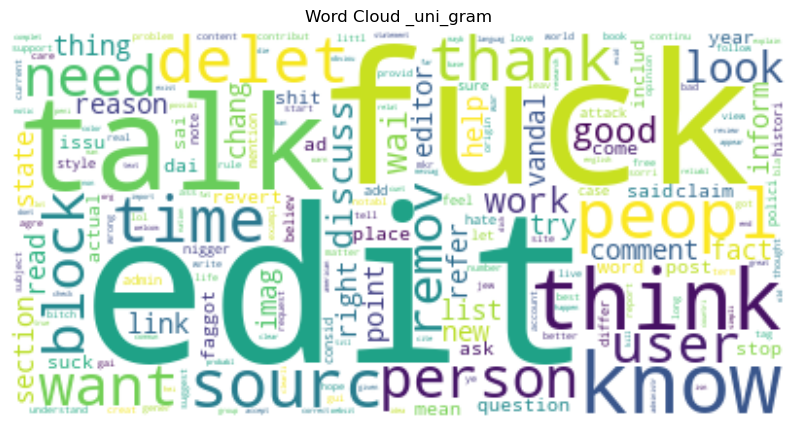

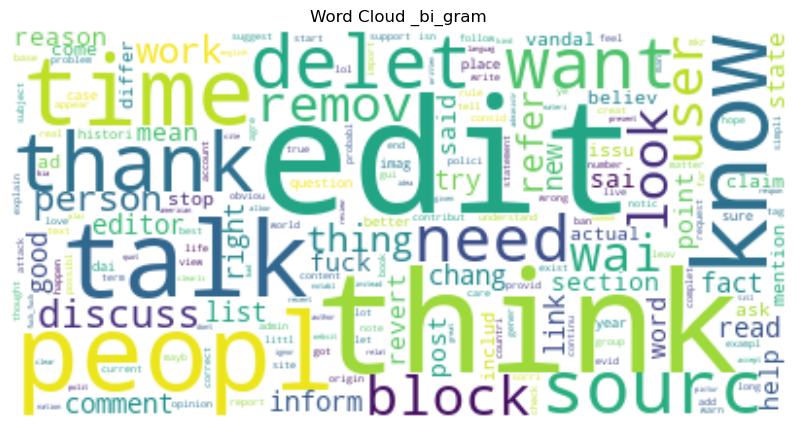

In [37]:
generate_worldcloud_vis(df_bigrams)

In [38]:
def generate_top_n_words_vis(df_bigrams, top_n, color):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    #for token in tokens:
    for token in tokens:
        no_cb_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 0][token]])
        cb_tokens= ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['label'] == 1][token]])

        word_freq_no_cb = Counter(no_cb_tokens.split())
        most_common_no_cb = word_freq_no_cb.most_common(top_n)
        word_freq_no_cb = Counter(cb_tokens.split())
        most_common_cb = word_freq_no_cb.most_common(top_n)



        df2 = pd.DataFrame(most_common_no_cb, columns=['word', 'Non_Cyberbullyiing'])
        df1 = pd.DataFrame(most_common_cb, columns=['word', 'Cyberbullyiing'])

        # Merge the two dataframes on the word
        merged_df = pd.merge(df1, df2, on='word', how='outer').fillna(0)

        # Sort by one of the counts (optional)
        merged_df = merged_df.sort_values(by='Cyberbullyiing', ascending=False)

        # Create side by side bar charts
        ax = merged_df.plot.bar(x='word', y=['Cyberbullyiing', 'Non_Cyberbullyiing'], figsize=(28,8), color=color)

        # Set title and y-label
        ax.set_title(f'Comparison of Top {top_n} {token}')
        ax.set_ylabel('Count')
        #ax.set_xlabel('Words', fontsize=16)

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(merged_df['word'], rotation=45, ha='right',fontsize=18)

        plt.tight_layout()
        plt.show()

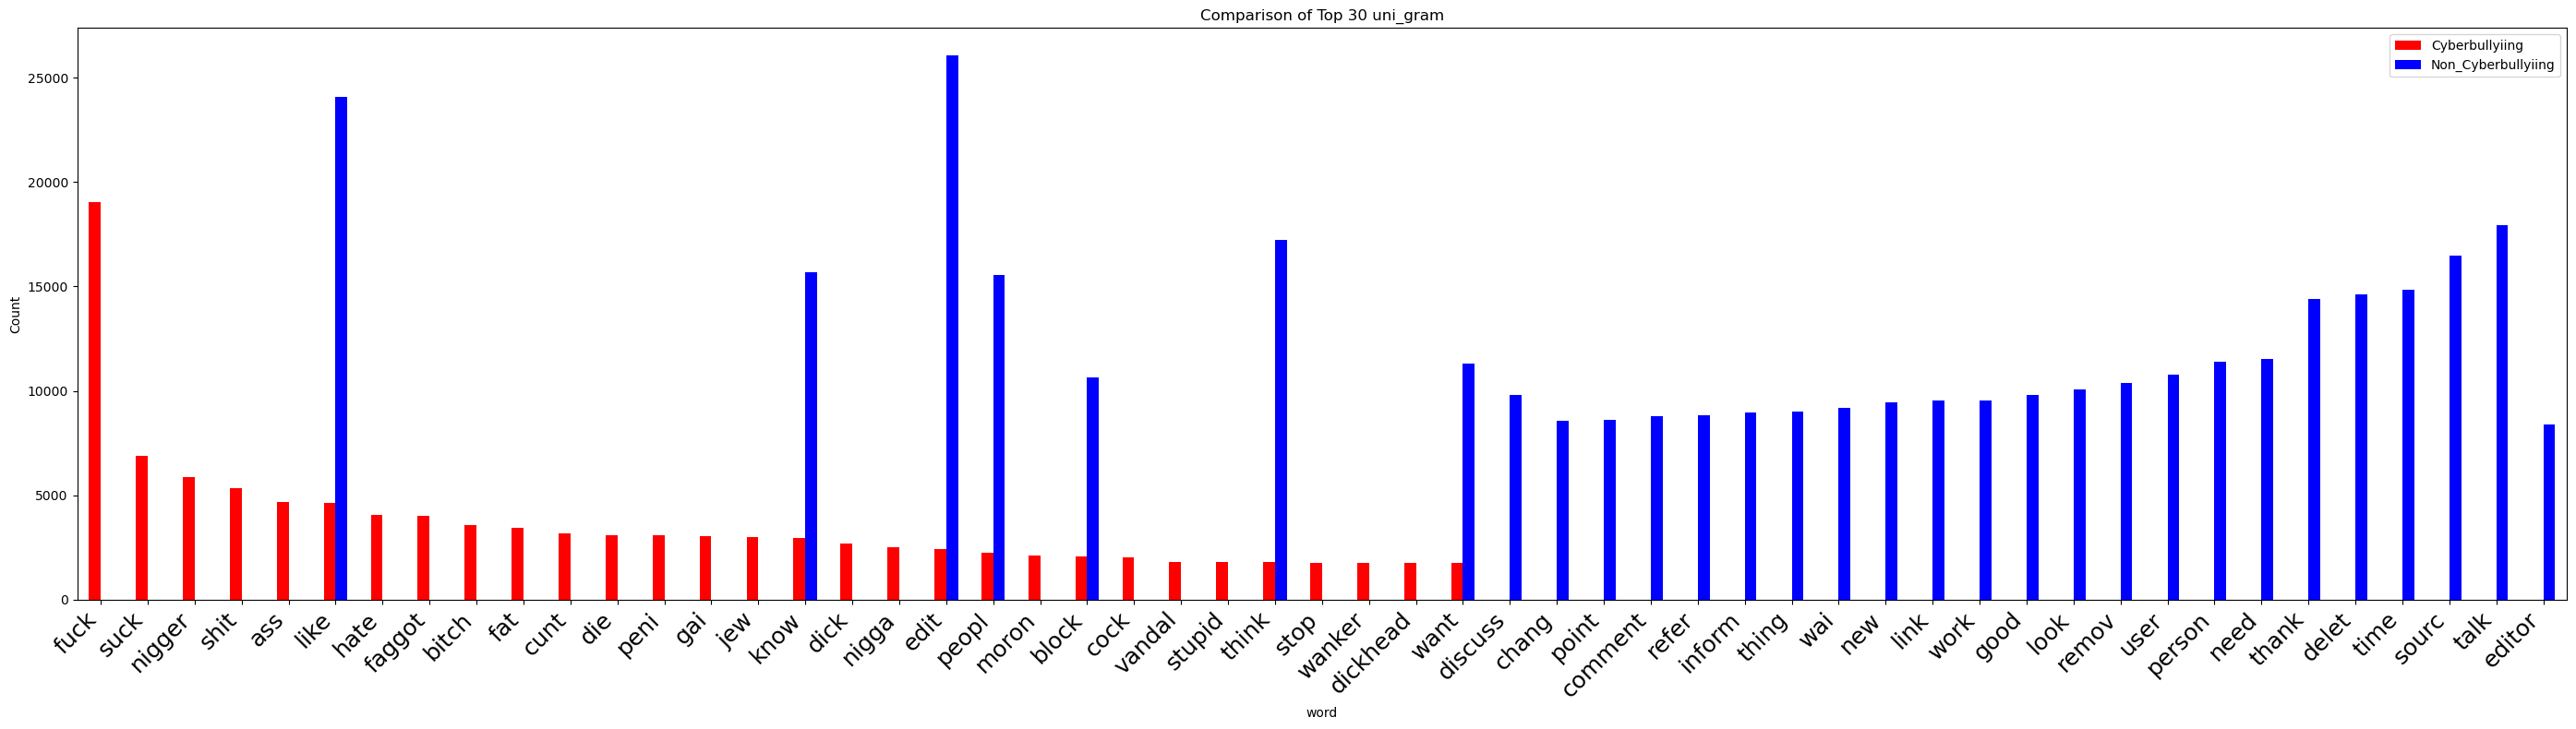

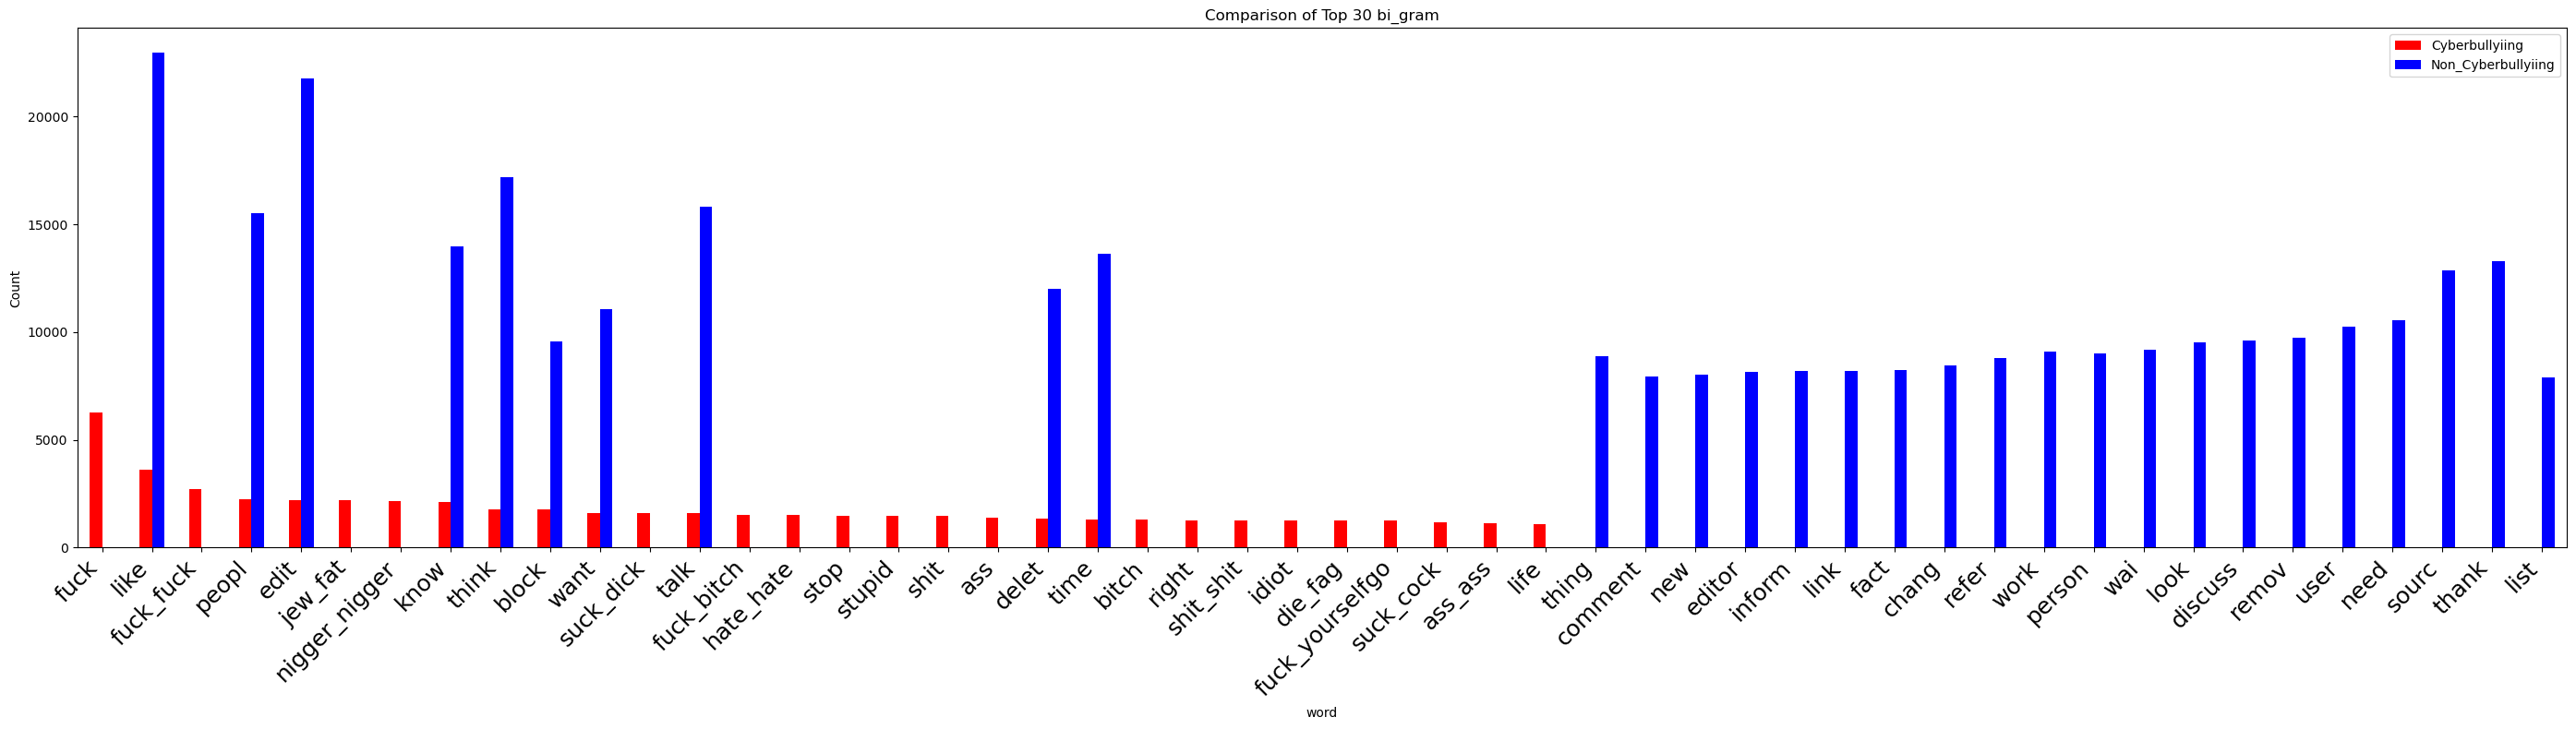

In [39]:
color= ['red','blue']
top_n = 30
generate_top_n_words_vis(df_bigrams, top_n, color)

## Topic Modeling

### Find number of topics

In [40]:
def find_topics(tokens, num_topics):



    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=10, no_above=0.6, )

    corpus = [dictionary.doc2bow(text) for text in tokens]

    # lda_model = LdaModel(corpus, num_topics=num_topics,id2word=dictionary,chunksize=2000,
    #                      passes=20,iterations=400,eval_every=None,random_state=42,alpha='auto',eta='auto')
    
    from gensim.models.ldamulticore import LdaMulticore# in case use multi-cores

    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'


    return lda_model.top_topics(corpus) 


In [41]:
df_bigrams['filename'].unique()

array(['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data'], dtype=object)

In [42]:
df_bigrams.describe()

label       text_len  hashtag_count  mention_count  \
count  153230.000000  153230.000000  153230.000000  153230.000000   
mean        0.144724      58.487274       0.092188       0.131639   
std         0.351823     112.371580       0.622167       1.489523   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000      14.000000       0.000000       0.000000   
50%         0.000000      27.000000       0.000000       0.000000   
75%         0.000000      60.000000       0.000000       0.000000   
max         1.000000    2832.000000      56.000000     528.000000   

       capital_letter_pct      url_count  
count       153230.000000  153230.000000  
mean             0.321130       0.058859  
std              3.130105       0.523583  
min              0.000000       0.000000  
25%              0.000000       0.000000  
50%              0.000000       0.000000  
75%              0.000000       0.000000  
max             89.473684      85.000000

## Visualize coherence as the number of topics varies from 2 to 10

In [43]:
df_bigrams['filename'].unique()

array(['wiki_data', 'kaggle_data', 'twitter_data_relabel',
       'formspring_data'], dtype=object)

In [44]:
def calculate_avg_coherence(topics):

    avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)
   
    return avg_topic_coherence

def plot_coherences_topics(tokens):

    topics_range = range(2, 11, 1)
    model_results = {'Topics': [],'Coherence': []}
    coherence = []
    for i in topics_range:
        topics = find_topics(tokens, num_topics=i)
        coherence.append(calculate_avg_coherence(topics))
    
    model_results['Topics'] = topics_range
    model_results['Coherence'] = coherence
    plt = pd.DataFrame(model_results).set_index('Topics').plot()



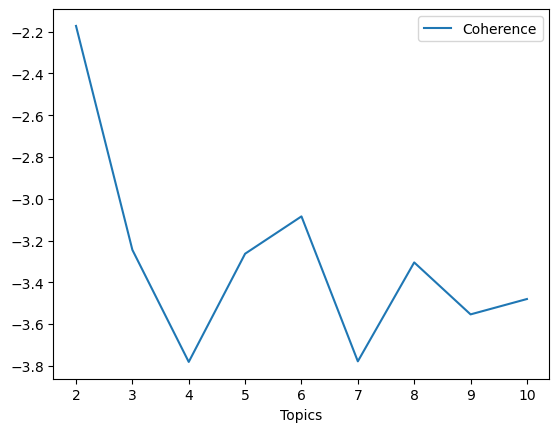

In [45]:
coherences_df = plot_coherences_topics(df_bigrams['bi_gram'])

In [46]:
#find_topics(df_bigrams['bi_gram'].dropna(), num_topics=4)

In [47]:
def plot_topics(df, num_topics, num_words,token):
    """ 
    df =['df_bigrams_imbalanced','df_bigrams'] #df_bigrams is balanced tokenized dataframe
    features = ['filename','label']
    token = ['bi_gram','uni_gram']
    10 points
    Plot the topics of the tweets per each year following the example provided above.
    
    For this plot, we recommend using seaborn for the heatmap. Note that you must pass fmt='' to Seaborn for 
    string annotations. The colormap to match is "YlGnBu". See heatmap documentation for overlaying labels.
    
     - tweets_df is the dataframe that contains pre-processed tokens
     - num_topics is the number of topics to produce each year
     - num_words represents the number of words to include in each topic
    """
    # YOUR CODE HERE
    def create_top_topics(df):
        bigrams_token_feature=df.loc[:,[token]]
        #num_topics = 6
        tokens = bigrams_token_feature[token]
        dictionary = Dictionary(tokens)
        dictionary.filter_extremes(no_below=10, no_above=0.6, )
        corpus = [dictionary.doc2bow(text) for text in tokens]

        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'

        top_topics = lda_model.top_topics(corpus)
        return top_topics

    def create_heatmap(top_topics):
        avg_coherences = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
        result_lst = []
        annot_lst = []
        for idx, row in enumerate(top_topics):
            result_lst.append([])
            annot_lst.append([])
            for j, k in row[0][:num_words]:
                result_lst[idx].append(round(j,2))
                annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

        plt.figure(figsize=(25,7)) 
        plt.title('bigram')
        sns.heatmap(pd.DataFrame(result_lst),annot=pd.DataFrame(annot_lst),fmt='',cmap='YlGnBu',
                   xticklabels = False, yticklabels = avg_coherences)

    
    top_topics = create_top_topics(df)
    create_heatmap(top_topics)
   
    #raise NotImplementedError()
    

## Plot top topics

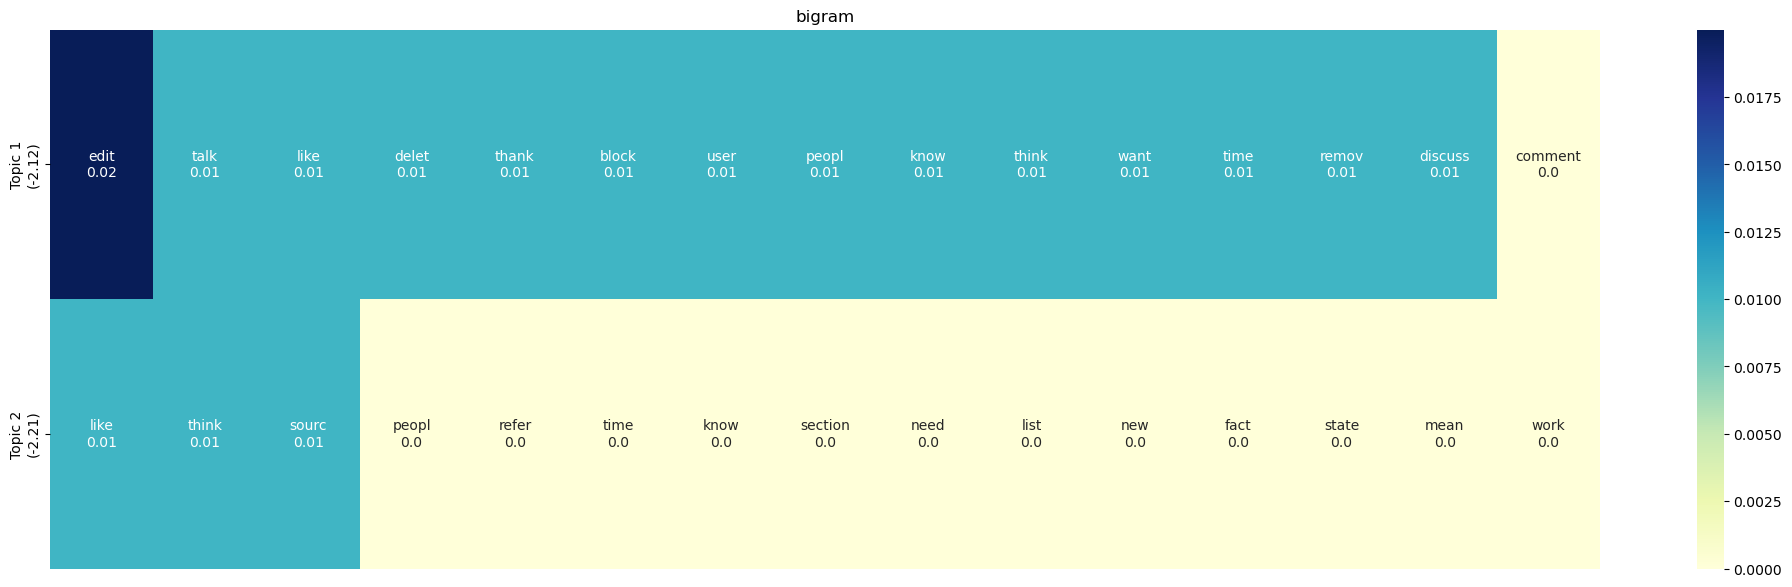

In [48]:
num_topics= 2
token = 'bi_gram'
plot_topics(df_bigrams, num_topics,15 ,token)

## group topics by features

In [49]:
#select 
def plot_coherences_topics_by_features(df, feature, token):

    def calculate_avg_coherence(topics):

        avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)

        return avg_topic_coherence

    def plot_coherences_topics(tokens):

        topics_range = range(2, 11, 1)
        model_results = {'Topics': [],'Coherence': []}
        coherence = []
        for i in topics_range:
            topics = find_topics(tokens, num_topics=i)
            coherence.append(calculate_avg_coherence(topics))

        model_results['Topics'] = topics_range
        model_results['Coherence'] = coherence
        plt = pd.DataFrame(model_results).set_index('Topics').plot()
        
    feature_values = sorted(df[feature].unique())
    for feature_value in feature_values:
        bigrams_token_feature=df.loc[df[feature]==feature_value,[token]]
        plot_coherences_topics(bigrams_token_feature[token])
        

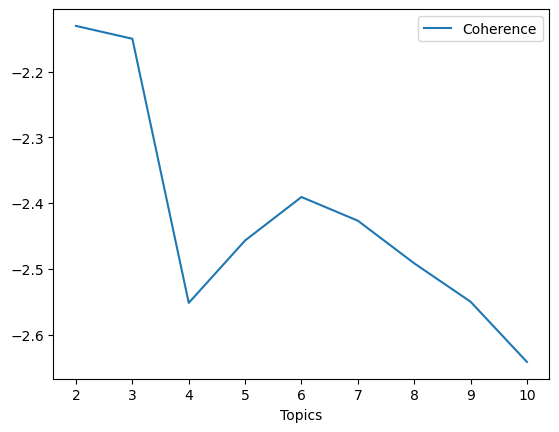

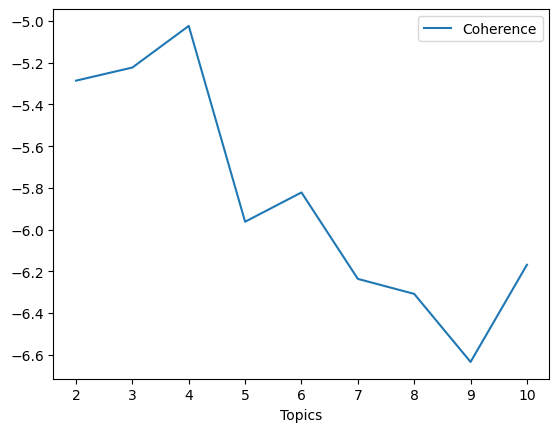

In [50]:
plot_coherences_topics_by_features(df_bigrams,'label','bi_gram')

In [51]:
print("the best topic number for label = 0 is 7")
print('the best topic number for label = 1 is 4')

the best topic number for label = 0 is 7
the best topic number for label = 1 is 4


In [52]:
sorted(df_bigrams['filename'].unique())

['formspring_data', 'kaggle_data', 'twitter_data_relabel', 'wiki_data']

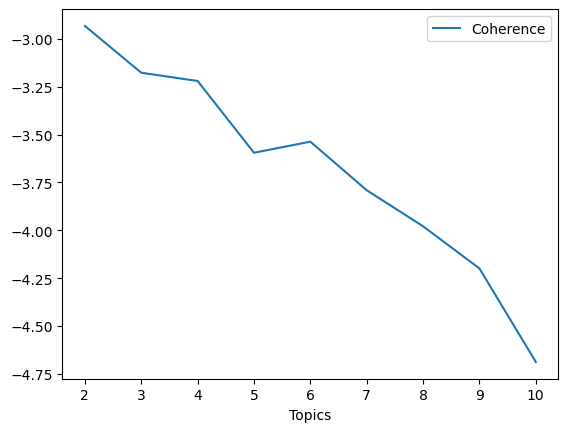

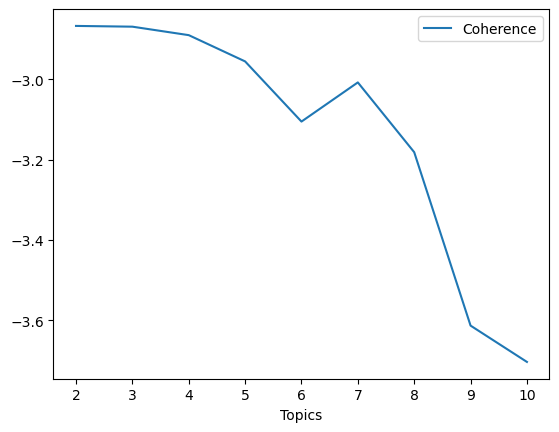

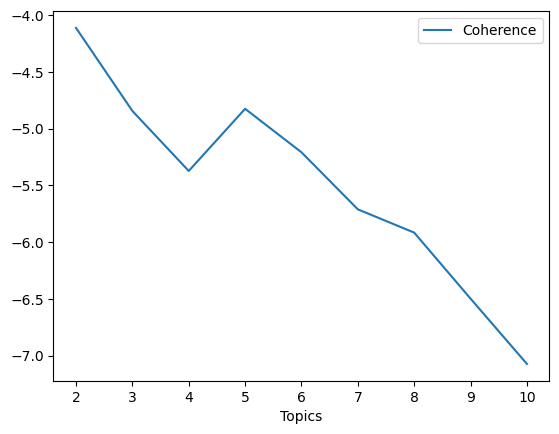

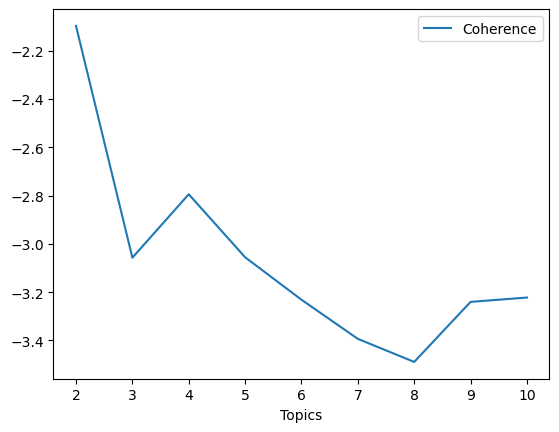

In [53]:
plot_coherences_topics_by_features(df_bigrams,'filename','bi_gram')

In [54]:

print("the best topic number for file 1 formspring_data is 2 ")
print('the best topic number for file 2 kaggle_data is 23')
print('the best topic number for file 3 is 3')
print('the best topic number for file 4 is 3')
print('the best topic number for file 5 is 2')

the best topic number for file 1 formspring_data is 2 
the best topic number for file 2 kaggle_data is 23
the best topic number for file 3 is 3
the best topic number for file 4 is 3
the best topic number for file 5 is 2


In [55]:
def plot_topics_per_feature_value(df, num_topics, num_words,feature,token):
    """ 
    df =['df_bigrams_imbalanced','df_bigrams'] #df_bigrams is balanced tokenized dataframe
    features = ['filename','label']
    token = ['bi_gram','uni_gram']
    10 points
    Plot the topics of the tweets per each year following the example provided above.
    
    For this plot, we recommend using seaborn for the heatmap. Note that you must pass fmt='' to Seaborn for 
    string annotations. The colormap to match is "YlGnBu". See heatmap documentation for overlaying labels.
    
    
     - tweets_df is the dataframe that contains pre-processed tokens
     - num_topics is the number of topics to produce each year
     - num_words represents the number of words to include in each topic
    """
    # YOUR CODE HERE
    def create_top_topics(df,num_topic, feature, feature_value):
        bigrams_token_feature=df.loc[df[feature]==feature_value,[token]]
        #num_topics = 6
        tokens = bigrams_token_feature[token]
        dictionary = Dictionary(tokens)
        dictionary.filter_extremes(no_below=10, no_above=0.6, )
        corpus = [dictionary.doc2bow(text) for text in tokens]

        lda_model = LdaMulticore(corpus, num_topics=num_topic, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'

        top_topics = lda_model.top_topics(corpus)
        return top_topics

    def create_heatmap(top_topics,feature_value):
        avg_coherences = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
        result_lst = []
        annot_lst = []
        for idx, row in enumerate(top_topics):
            result_lst.append([])
            annot_lst.append([])
            for j, k in row[0][:num_words]:
                result_lst[idx].append(round(j,2))
                annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

        plt.figure(figsize=(25,7)) 
        plt.title(feature_value)
        sns.heatmap(pd.DataFrame(result_lst),annot=pd.DataFrame(annot_lst),fmt='',cmap='YlGnBu',
                   xticklabels = False, yticklabels = avg_coherences)

    feature_values = sorted(df[feature].unique())
    for feature_value, num_topic in zip(feature_values,num_topics):
        top_topics = create_top_topics(df,num_topic ,feature, feature_value)
        create_heatmap(top_topics,feature_value)
   
 
    


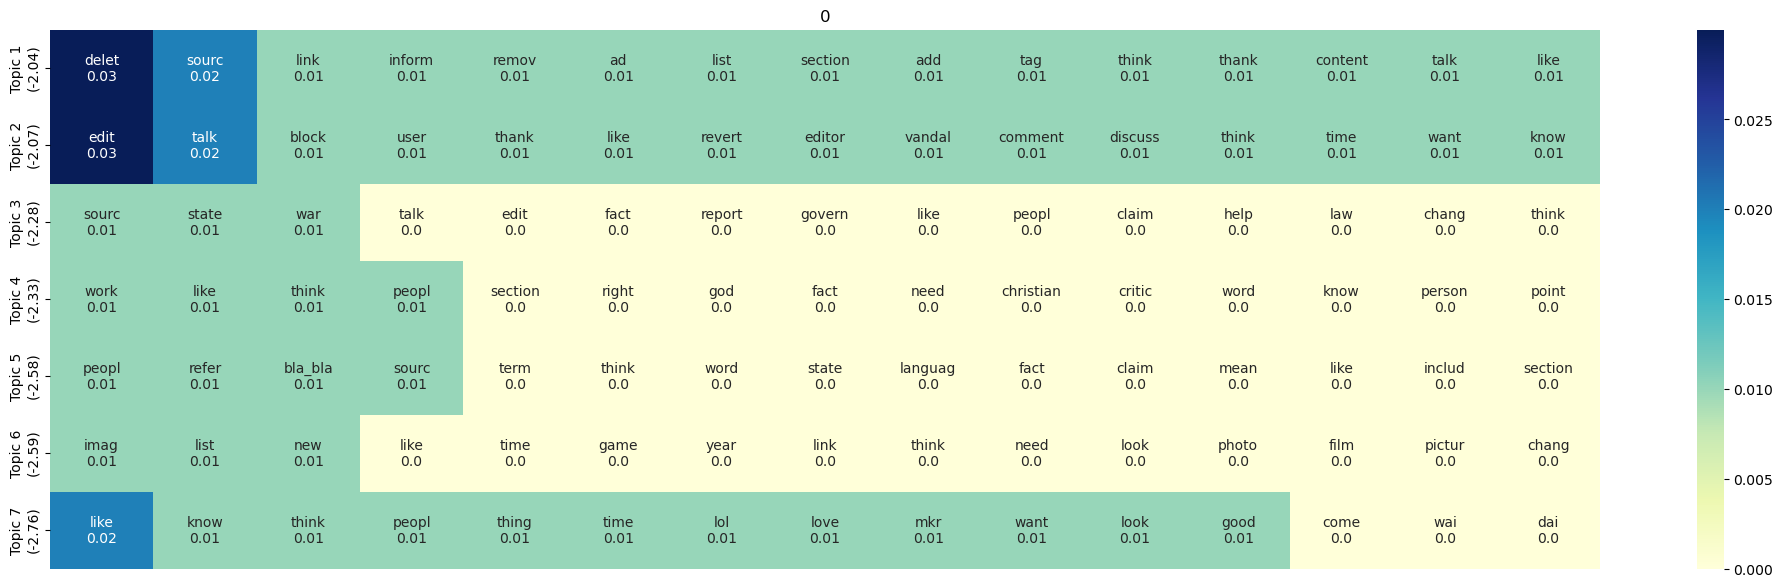

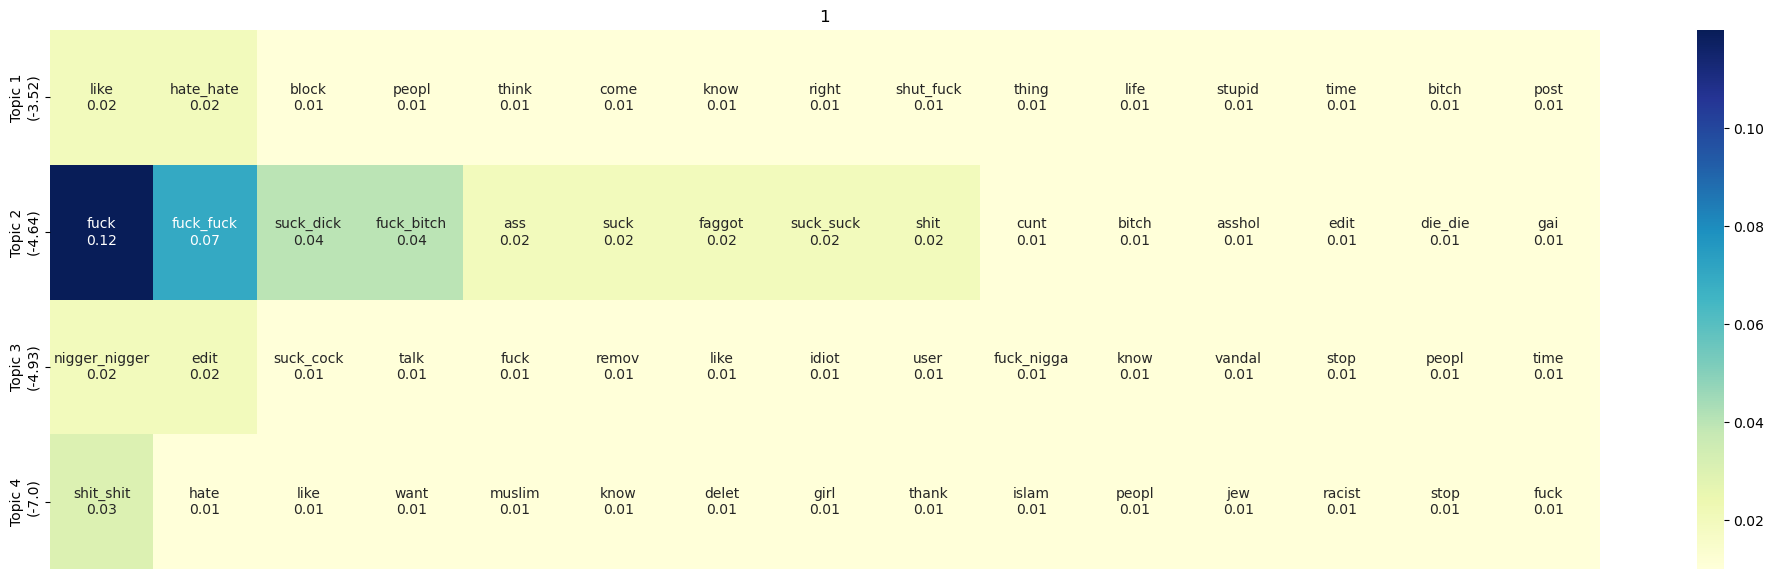

In [56]:
num_topics = [7,4]
feature = 'label'
token = 'bi_gram'

plot_topics_per_feature_value(df_bigrams, num_topics, 15,feature, token)

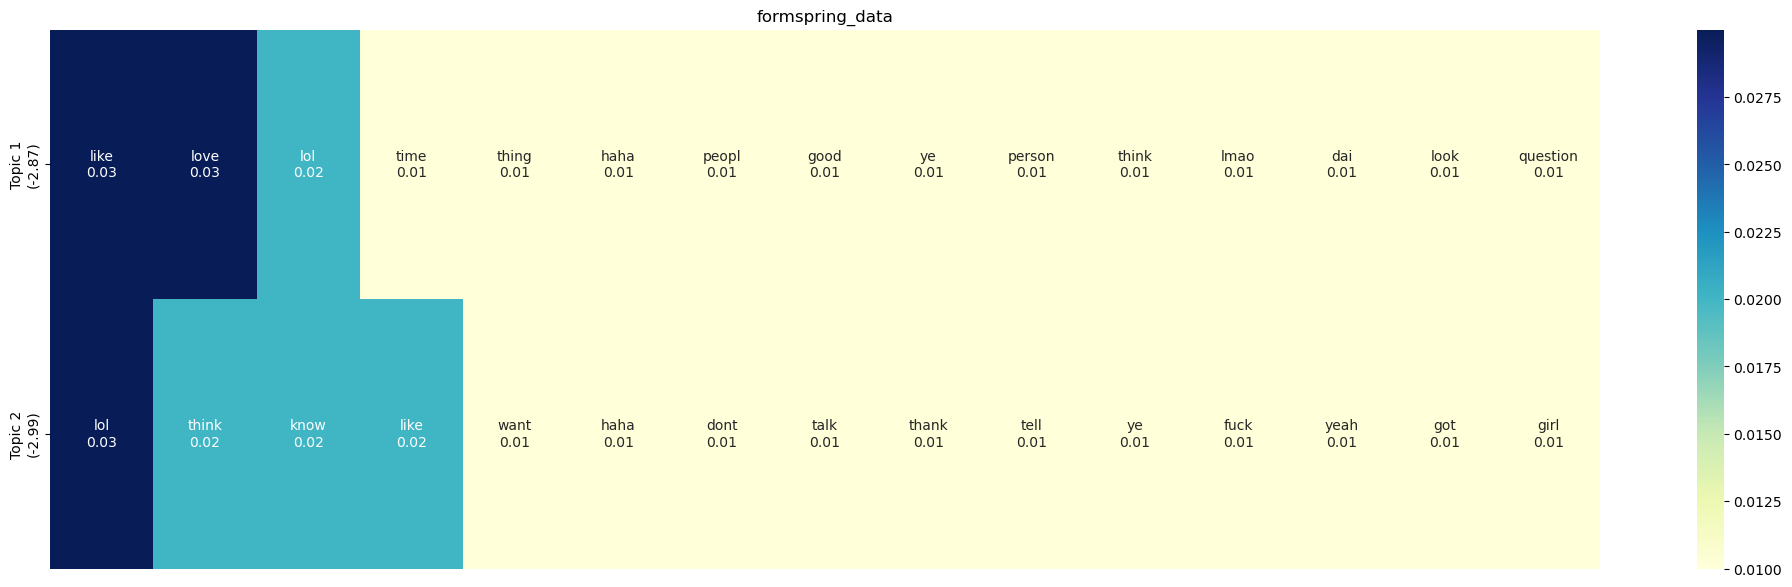

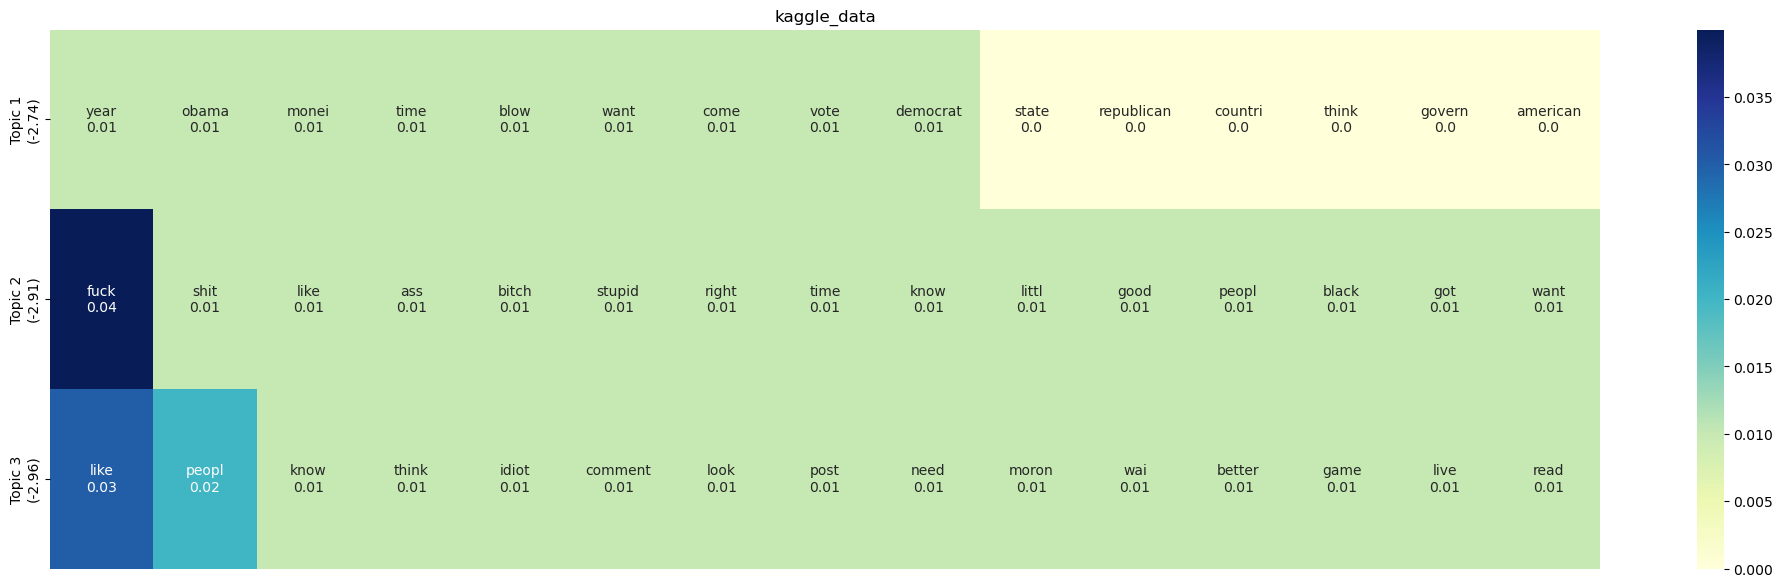

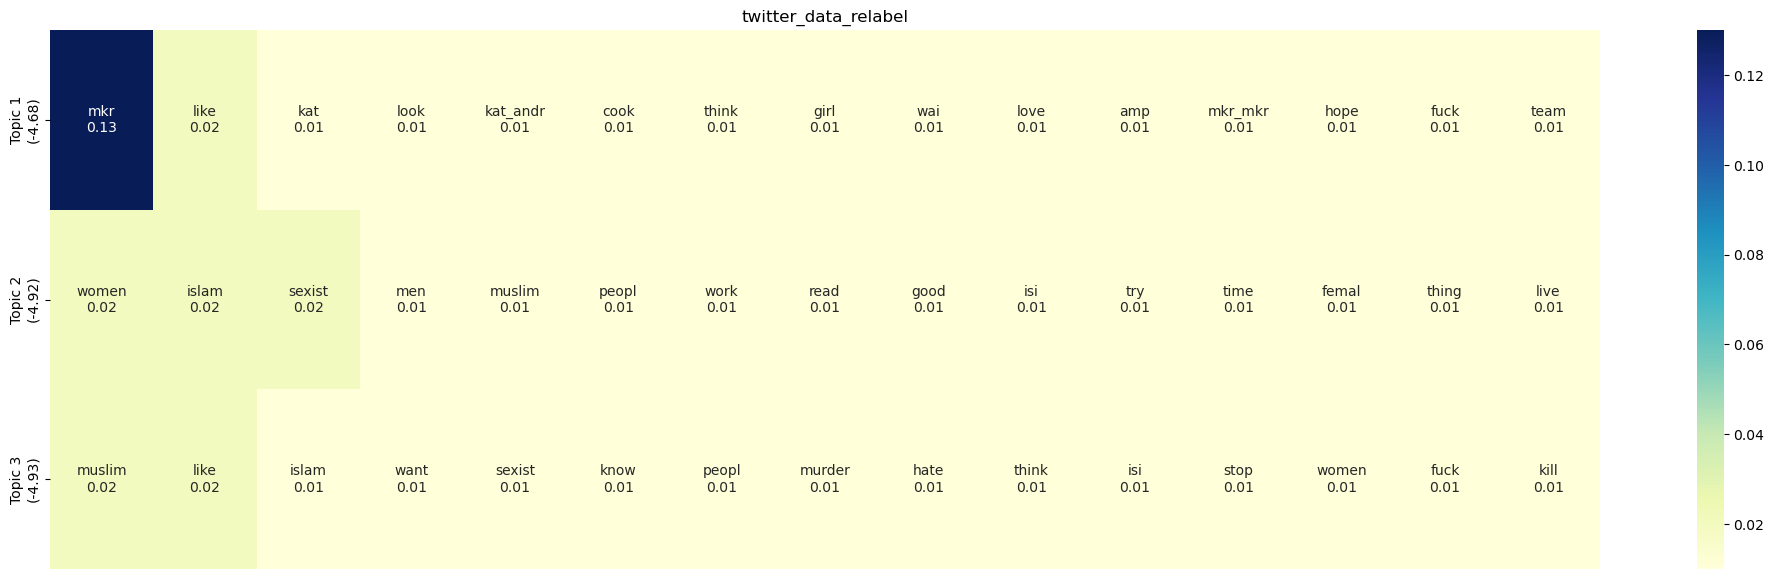

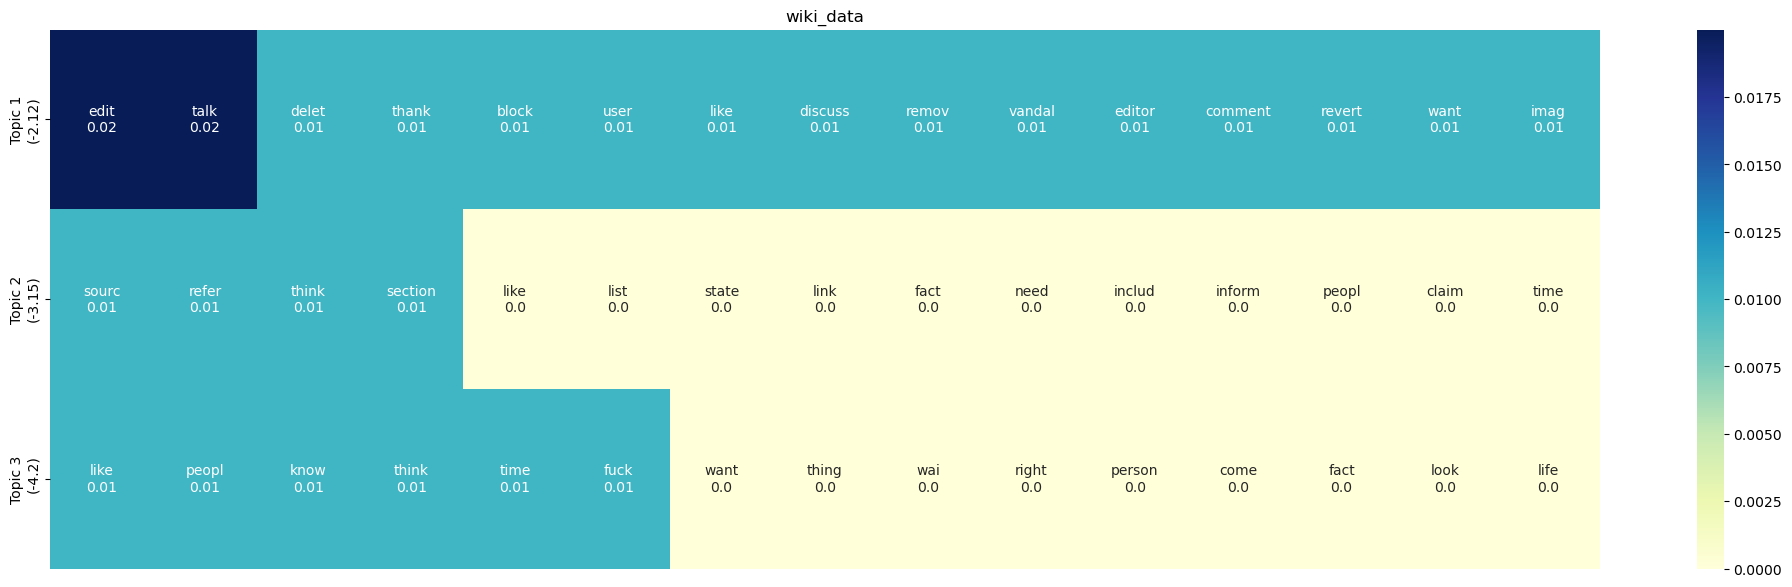

In [57]:
num_topics = [2,3,3,3,2]
feature = 'filename'
token ='bi_gram'
plot_topics_per_feature_value(df_bigrams, num_topics, 15,feature, token)

## Supervised learning

In [25]:
result_df.head(2)

text  \
107401  == == if something is not acceptable for your bald headed brain doesn't mean it can be unacceptable.   
149076                                                                "Yes, you are one sorry individual..."   

        label     filename split  text_len  hashtag_count  mention_count  \
107401      1    wiki_data  test        18              0              0   
149076      1  kaggle_data   NaN         6              0              0   

        capital_letter_pct  url_count  
107401            0.000000          0  
149076            2.631579          0

In [26]:
result_df[result_df.label==1]['filename'].value_counts()

wiki_data               13568
twitter_data_relabel     5054
kaggle_data              2778
formspring_data           776
Name: filename, dtype: int64

In [27]:
def dataset_balance(df):
    balanced_df = df
#     # Balancing data by randomly resampling   
    positive_class = df[df['label'] == 1]
    negative_class = df[df['label'] == 0]
    
#     print("----positive sample number: ", len(positive_class), "------")
    
#     # Undersample the majority class (negative class) to match the minority class
    negative_undersampled = resample(negative_class, replace=False, n_samples=len(positive_class), random_state=41)
#     # Combine the oversampled positive and undersampled negative samples
    balanced_df = pd.concat([positive_class, negative_undersampled])
#     # Shuffle the balanced DataFrame to randomize the order of samples
    balanced_df = balanced_df.sample(frac=1, random_state=41)
    
    return balanced_df  

In [28]:
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
balanced_df = dataset_balance(result_df)
print(balanced_df.label.value_counts())

0    22176
1    22176
Name: label, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wenyuand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
%%time
X = balanced_df.loc[:, balanced_df.columns != 'label']
stratify = balanced_df['label'].astype(str) + "_" + balanced_df['filename'].astype(str)

X_train, X_temp, y_train, y_temp = train_test_split(X, balanced_df.label, test_size=0.3, random_state=42, stratify=stratify)

stratify = y_temp.astype(str) + "_" + X_temp['filename'].astype(str)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=stratify)
print(X_train['filename'].value_counts()/len(X_train['filename']))
print(X_validation['filename'].value_counts()/len(X_validation['filename']))
print(X_test['filename'].value_counts()/len(X_test['filename']))

print(y_train.value_counts()/len(y_train))
print(y_validation.value_counts()/len(y_validation))
print(y_test.value_counts()/len(y_test))
print("Classes are balanced")

wiki_data               0.694099
twitter_data_relabel    0.156574
kaggle_data             0.084906
formspring_data         0.064421
Name: filename, dtype: float64
wiki_data               0.694273
twitter_data_relabel    0.156471
kaggle_data             0.084924
formspring_data         0.064332
Name: filename, dtype: float64
wiki_data               0.694123
twitter_data_relabel    0.156621
kaggle_data             0.084774
formspring_data         0.064482
Name: filename, dtype: float64
1    0.5
0    0.5
Name: label, dtype: float64
1    0.500075
0    0.499925
Name: label, dtype: float64
0    0.500075
1    0.499925
Name: label, dtype: float64
Classes are balanced
CPU times: user 63.3 ms, sys: 2.97 ms, total: 66.3 ms
Wall time: 65.9 ms


In [30]:
# X_train.head(2)

In [31]:
%%time
stop_words = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

def get_features(X_raw, is_train=False):
    preprocessed_text = X_raw.text.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])
    if is_train:
        X = tfidf_vectorizer.fit_transform(preprocessed_text.str.join(' '))
    else:
        X = tfidf_vectorizer.transform(preprocessed_text.str.join(' '))
    X = np.hstack((X_raw[['text_len', 'hashtag_count', 'mention_count', 'capital_letter_pct', 'url_count']], X.toarray()))
    print(X.shape)
    return X

X_train_final = get_features(X_train, True)
X_validation_final = get_features(X_validation)
X_test_final = get_features(X_test)

(31046, 3005)
(6653, 3005)
(6653, 3005)
CPU times: user 15.5 s, sys: 877 ms, total: 16.4 s
Wall time: 16.5 s


In [38]:
# tfidf_vectorizer = TfidfVectorizer(max_features=3000)
# X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_text, result_df.label, test_size=0.3, random_state=42)
# X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# X_validation = tfidf_vectorizer.transform(X_validation.str.join(' '))
# X_test = tfidf_vectorizer.transform(X_test.str.join(' '))
# print(X_train.shape)

In [42]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_final, y_train)
y_pred = clf.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8361641364797836
CPU times: user 1min 29s, sys: 321 ms, total: 1min 29s
Wall time: 1min 30s


In [43]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(2765, 562, 528, 2798)

In [49]:
%%time
from multiprocessing import Pool
from sklearn.model_selection import GridSearchCV
from itertools import product

def train_rf_model(params):
    # Unpack hyperparameters
    n_estimators, max_depth, min_samples_split, min_samples_leaf = params
    
    # Create and train the Random Forest classifier
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # You can set a seed for reproducibility
    )
    
    # Fit the model to your training data
    rf.fit(X_train_final, y_train)
    
    return rf

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [5, 6, 7],
    'min_samples_leaf': [1, 2]
}

param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
))

num_processes = 30
with Pool(num_processes) as pool:
    trained_models = pool.map(train_rf_model, param_combinations)

best_rf = None
best_score = 0

for rf in trained_models:
    score = rf.score(X_validation_final, y_validation)
    if score > best_score:
        best_score = score
        best_rf = rf

print("Best Random Forest Model:", best_rf)
print("Best Accuracy:", best_score)

Best Random Forest Model: RandomForestClassifier(min_samples_split=6, n_estimators=200, random_state=42)
Best Accuracy: 0.8402224560348714
CPU times: user 16 s, sys: 5.82 s, total: 21.8 s
Wall time: 4min 23s


In [78]:
!nvidia-smi

Wed Oct  4 01:52:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:E3:00.0 Off |                    0 |
| N/A   31C    P0               73W / 300W|   1023MiB / 81920MiB |      0%   E. Process |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [46]:
%%time
import xgboost as xgb
from tqdm import tqdm
from multiprocessing.dummy import Pool
from itertools import product
def train_xgb_model(params):
    # Unpack hyperparameters
    n_estimators, learning_rate, max_depth, min_child_weight, subsample,colsample_bytree, gamma, scale_pos_weight  = params
    
    # Create and train the Random Forest classifier
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            gamma=gamma,
                            scale_pos_weight=scale_pos_weight,
                            device="cuda",
                            random_state=42)
    
    # Fit the model to your training data
    xgb_clf.fit(X_train_final, y_train)
    
    return xgb_clf

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
    'scale_pos_weight': [1, 2, 3]  # Controls the balance of positive and negative weights
}

# param_grid = {
#     'n_estimators': [1],  # Number of boosting rounds
#     'learning_rate': [0.01],  # Step size shrinkage used in update to prevent overfitting
#     'max_depth': [3],  # Maximum depth of a tree
#     'min_child_weight': [1],  # Minimum sum of instance weight (hessian) needed in a child
#     'subsample': [0.8],  # Fraction of samples used for fitting the trees
#     'colsample_bytree': [0.8],  # Fraction of features used for fitting the trees
#     'gamma': [0],  # Minimum loss reduction required to make a further partition on a leaf node
#     'scale_pos_weight': [1]  # Controls the balance of positive and negative weights
# }


param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['min_child_weight'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['gamma'],
    param_grid['scale_pos_weight']
))

num_threads = 30
with Pool(num_threads) as pool:
    trained_models = list(tqdm(pool.imap(train_xgb_model, param_combinations), total=len(param_combinations)))

best_xgb = None
best_score = 0

for xgb_clf in trained_models:
    score = xgb_clf.score(X_validation_final, y_validation)
    if score > best_score:
        best_score = score
        best_xgb = xgb_clf

print("Best XGB Model:", best_xgb)
print("Best Accuracy:", best_score)

100%|██████████| 6561/6561 [1:27:40<00:00,  1.25it/s]  


Best XGB Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Best Accuracy: 0.8477378626183677
CPU times: user 20h 25min 34s, sys: 16h 54min 38s, total: 1d 13h 20min 12s
Wall time: 1h 38min 32s


In [50]:
import pickle
file_name = "xgb_clf_best.pkl"

# save
pickle.dump(best_xgb, open(file_name, "wb"))
best_xgb.score(X_test_final, y_test)

0.8501427927250864

In [37]:
%%time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# def get_encoded(X_raw, is_train=False):
#     preprocessed_text = X_raw.text.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])
#     if is_train:
#         X = tfidf_vectorizer.fit_transform(preprocessed_text.str.join(' '))
#     else:
#         X = tfidf_vectorizer.transform(preprocessed_text.str.join(' '))
print(X_train.text.values)

X_train_encoded = tokenizer(X_train.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_validation_encoded = tokenizer(X_validation.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
X_test_encoded = tokenizer(X_test.text.values.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

['hey ,muslim dickhead !!!!!!!! why don;t you go and shove allah or whatever the fuck you call the retard up your stupid backwards ass !!!!!!!!! you fucking muslims are a bunch of jealous west hating mongs, islam is a peaceful religion, bullshit !!!!!!! there are many times when it refers to violence. so go strap on your suicide bomb and blow yourself up. yey, one less feeble minded prick ion the world.'
 '== good job! ==  that user cumulus clouds hacks articles apart without reading the references. he removes information without doing anything to improve an article. you, on the other hand, do a great deal to make things better and more interesting... after all, wiki is not supposed to put people to sleep... it is intended to be informative cumulus clouds does not seem to understand this. thank you and well done.'
 "`, 31 october 2011 (utc) :are you fucking stupid? do you have brain damage? i just clearly told why you have no fucking right to demand civility from people. you can't actu

In [39]:
%%time
from tqdm import tqdm
train_data = torch.utils.data.TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], torch.tensor(y_train.values.tolist()))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)

validation_data = torch.utils.data.TensorDataset(X_validation_encoded['input_ids'], X_validation_encoded['attention_mask'], torch.tensor(y_validation.values.tolist()))
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32)

test_data = torch.utils.data.TensorDataset(X_test_encoded['input_ids'], X_test_encoded['attention_mask'], torch.tensor(y_test.values.tolist()))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

### hyper parameters:
learning_rate = 2e-5
epochs = 10
### hyper parameters end


optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda")
model.to(device)
print("device is: ")
print(device)


for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    
model.eval()
all_preds = []
all_labels = []

progress_bar = tqdm(validation_loader, desc="Validation", leave=False)
for batch in progress_bar:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

device is: 
cuda


Epoch 1/10, Loss: 0.2890


Epoch 2/10, Loss: 0.1823


Epoch 3/10, Loss: 0.1112


Epoch 4/10, Loss: 0.0736


Epoch 5/10, Loss: 0.0497


Epoch 6/10, Loss: 0.0357


Epoch 7/10, Loss: 0.0294


Epoch 8/10, Loss: 0.0228


Epoch 9/10, Loss: 0.0189


Epoch 10/10, Loss: 0.0173


Accuracy: 0.8840
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      3326
           1       0.84      0.95      0.89      3327

    accuracy                           0.88      6653
   macro avg       0.89      0.88      0.88      6653
weighted avg       0.89      0.88      0.88      6653

CPU times: user 25min 43s, sys: 2.1 s, total: 25min 46s
Wall time: 25min 46s


## The below code is for saving/loading the trained model

In [48]:
# torch.save(model.state_dict(), 'bert.pth')

In [49]:
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# # Load the saved model state_dict into the model
# model.load_state_dict(torch.load('bert.pth'))
# device = torch.device("cuda")
# model.to(device)
# # Put the model in evaluation mode
# model.eval()
# progress_bar = tqdm(validation_loader, desc="Validation", leave=False)
# for batch in progress_bar:
#     input_ids, attention_mask, labels = batch
#     input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)

#     logits = outputs.logits
#     preds = torch.argmax(logits, dim=1).cpu().numpy()
#     all_preds.extend(preds)
#     all_labels.extend(labels.cpu().numpy())

# accuracy = accuracy_score(all_labels, all_preds)
# report = classification_report(all_labels, all_preds)
# print(f"Accuracy: {accuracy:.4f}")
# print(report)

# Backup

In [45]:
#backup
def plot_topics_per_feature_value(df, num_topics, num_words,feature,token):
    """ 
    df =['df_bigrams_imbalanced','df_bigrams'] #df_bigrams is balanced tokenized dataframe
    features = ['filename','label']
    token = ['bi_gram','uni_gram']
    10 points
    Plot the topics of the tweets per each year following the example provided above.
    
    For this plot, we recommend using seaborn for the heatmap. Note that you must pass fmt='' to Seaborn for 
    string annotations. The colormap to match is "YlGnBu". See heatmap documentation for overlaying labels.
    
    
     - tweets_df is the dataframe that contains pre-processed tokens
     - num_topics is the number of topics to produce each year
     - num_words represents the number of words to include in each topic
    """
    # YOUR CODE HERE
    def create_top_topics(df, feature, feature_value):
        bigrams_token_feature=df.loc[df[feature]==feature_value,[token]]
        #num_topics = 6
        tokens = bigrams_token_feature[token]
        dictionary = Dictionary(tokens)
        dictionary.filter_extremes(no_below=10, no_above=0.6, )
        corpus = [dictionary.doc2bow(text) for text in tokens]

        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'

        top_topics = lda_model.top_topics(corpus)
        return top_topics

    def create_heatmap(top_topics,feature_value):
        avg_coherences = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
        result_lst = []
        annot_lst = []
        for idx, row in enumerate(top_topics):
            result_lst.append([])
            annot_lst.append([])
            for j, k in row[0][:num_words]:
                result_lst[idx].append(round(j,2))
                annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

        plt.figure(figsize=(25,7)) 
        plt.title(feature_value)
        sns.heatmap(pd.DataFrame(result_lst),annot=pd.DataFrame(annot_lst),fmt='',cmap='YlGnBu',
                   xticklabels = False, yticklabels = avg_coherences)

    feature_values = sorted(df[feature].unique())
    for feature_value in feature_values:
        for
        top_topics = create_top_topics(df, feature, feature_value)
        create_heatmap(top_topics,feature_value)
   
    #raise NotImplementedError()
    


In [ ]:
plot_topics_per_feature_value(df_bigrams, 2, 15,'label','bi_gram')

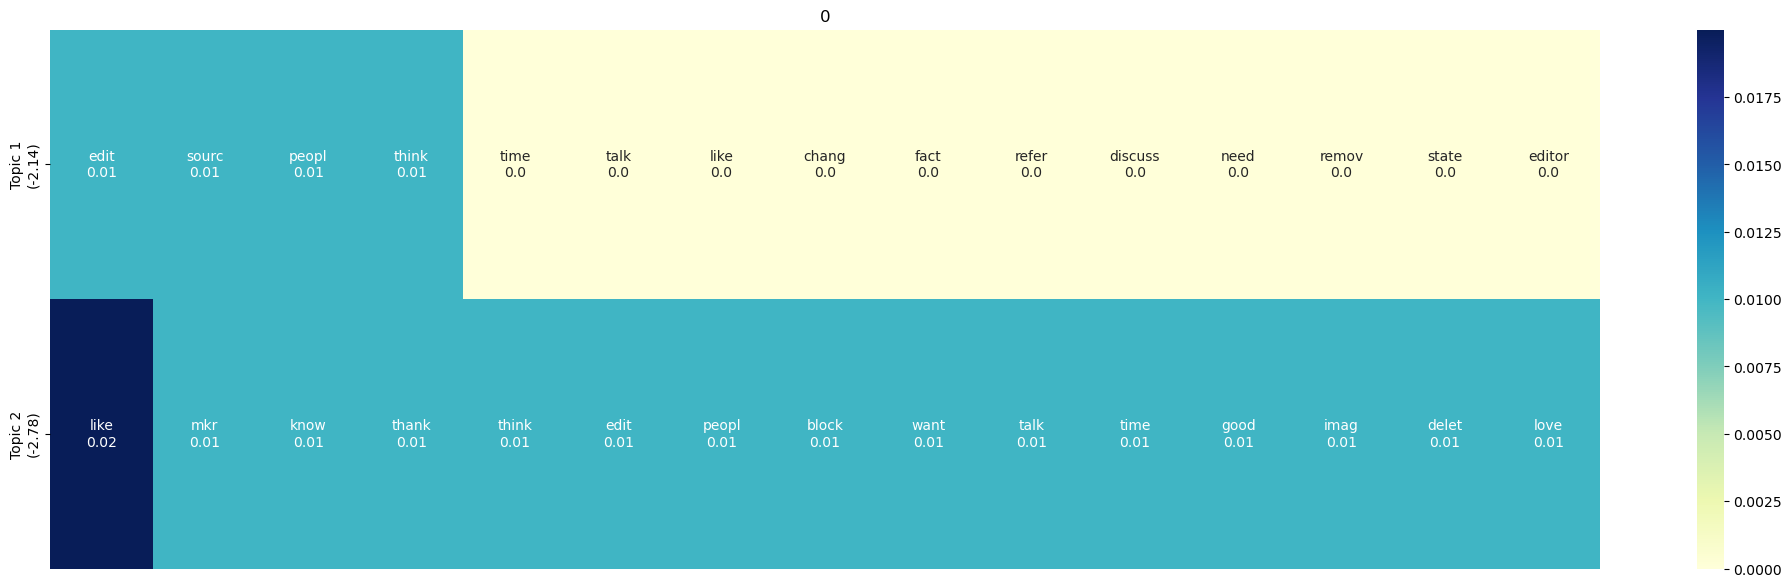

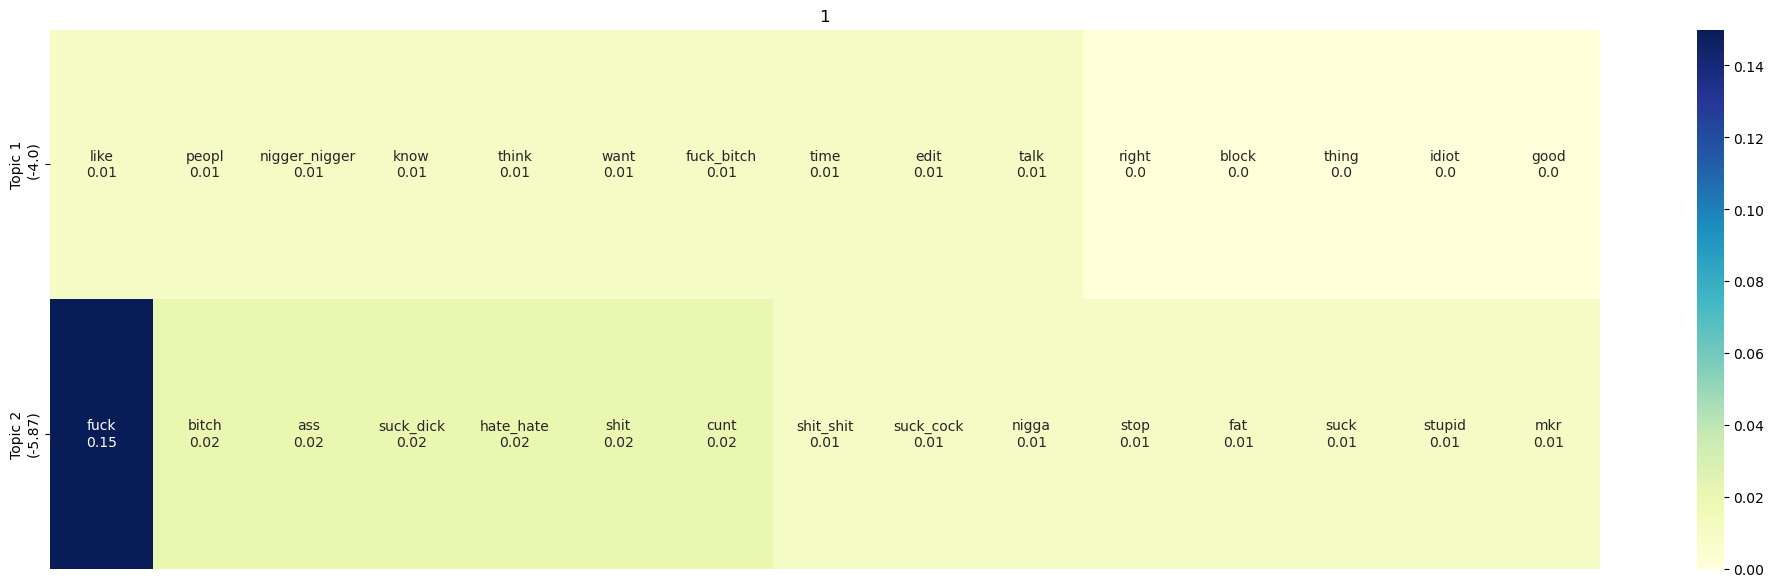

In [46]:
plot_topics_per_feature_value(df_bigrams, 2, 15,'label','bi_gram')

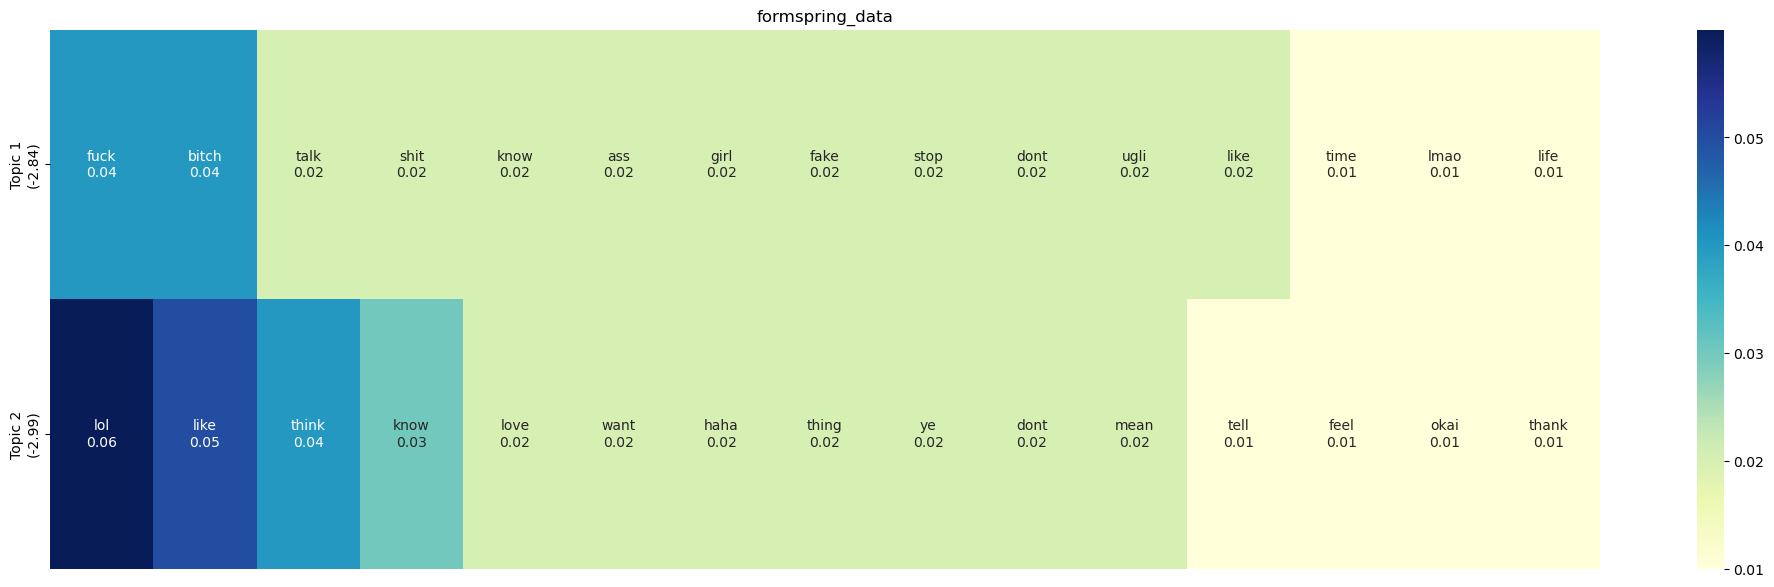

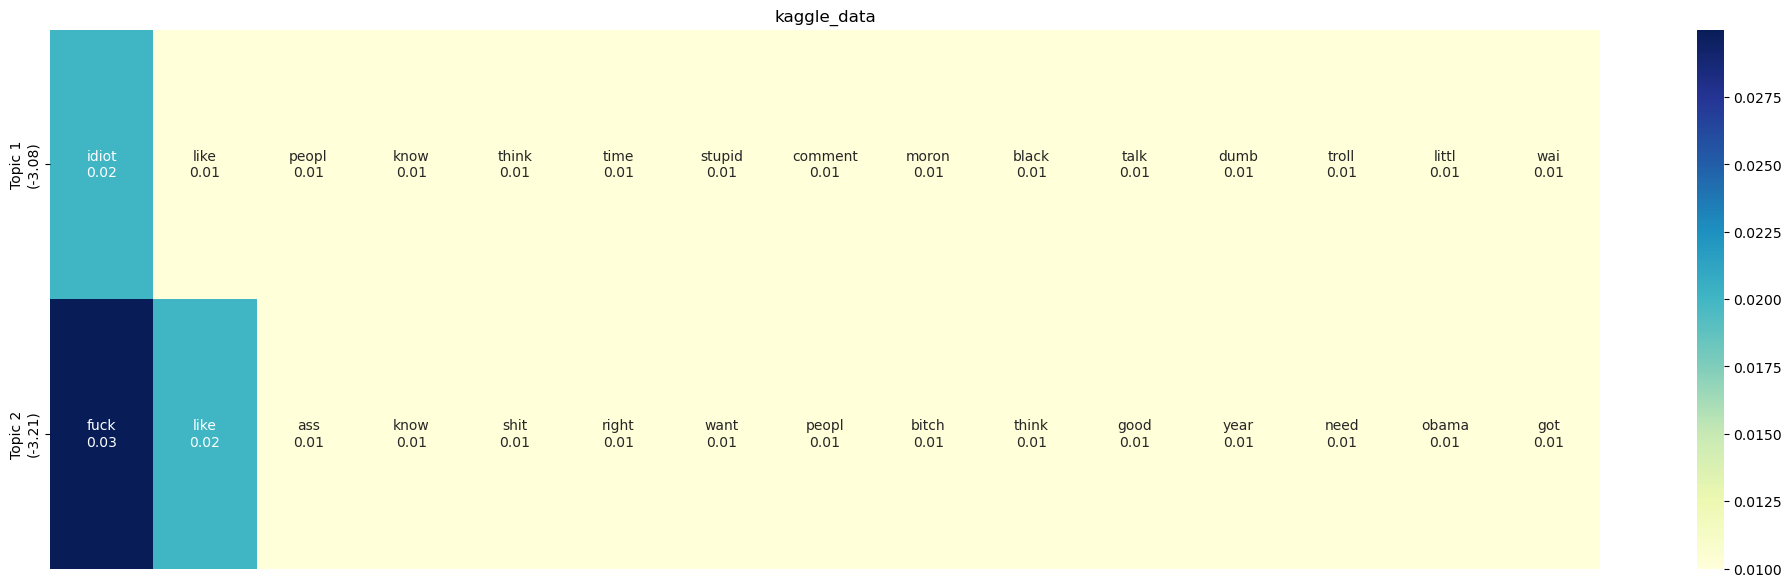

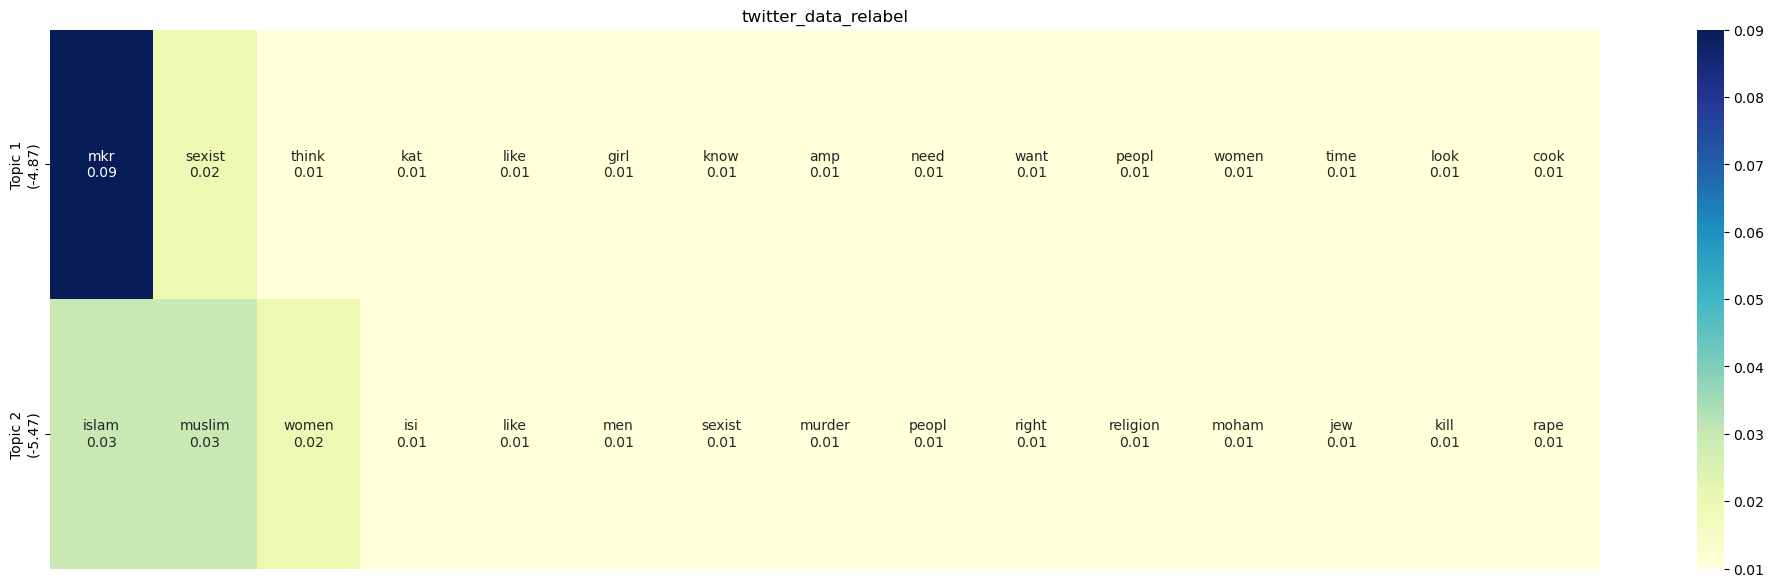

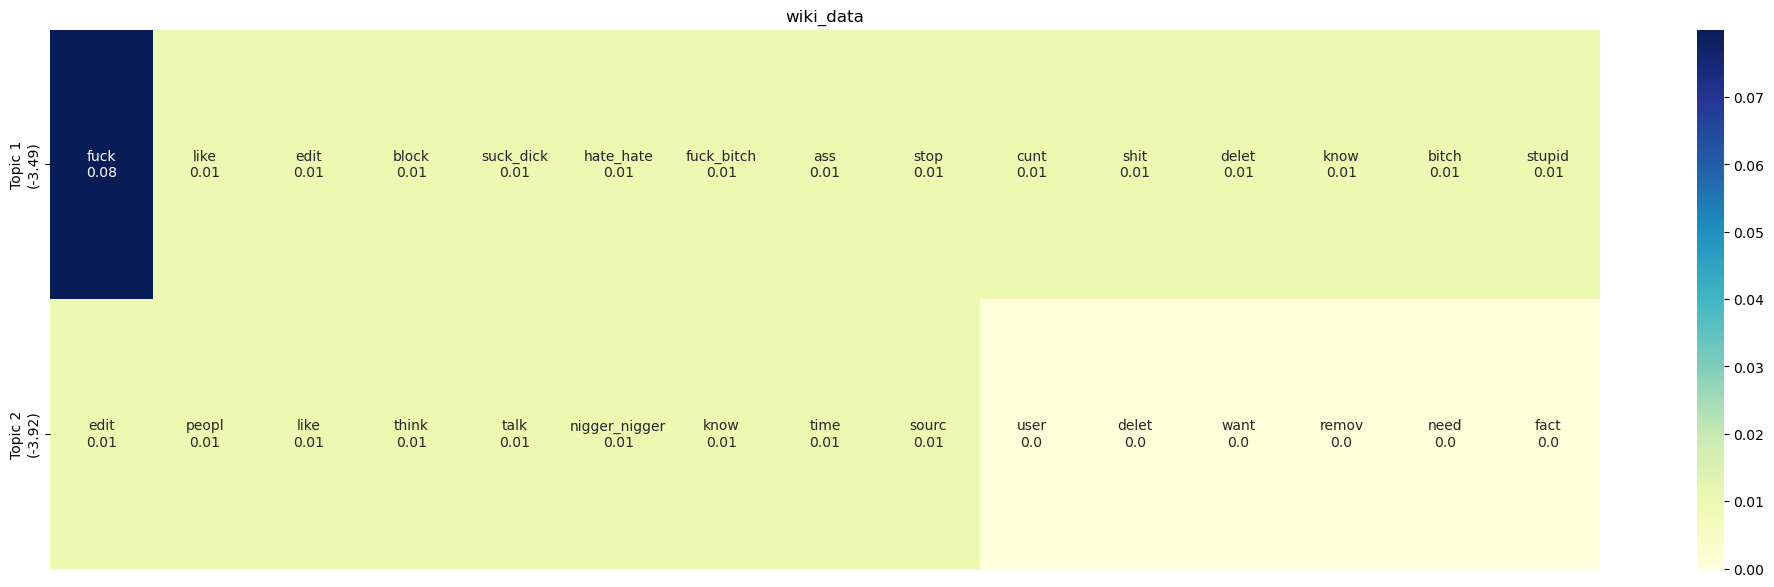

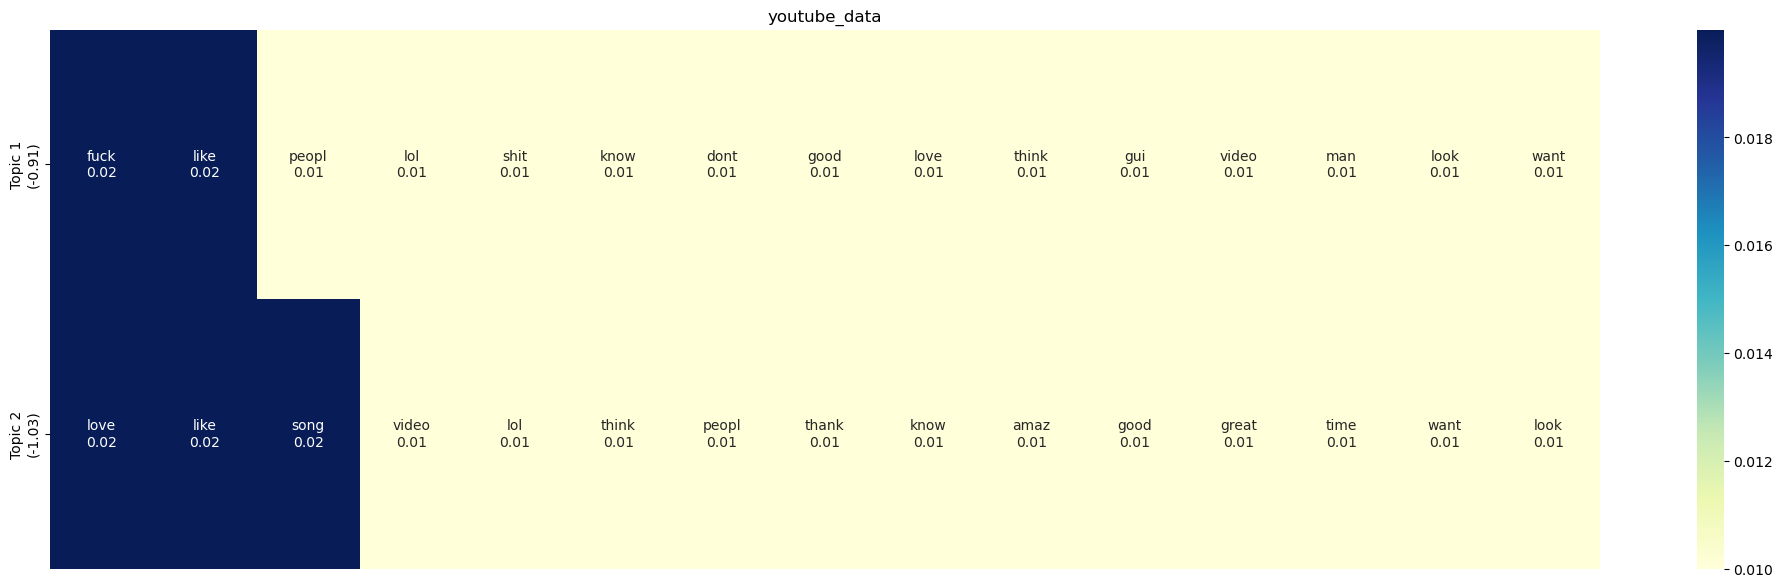

In [47]:
# test when the number of topic is 2
plot_topics_per_feature_value(df_bigrams, 2, 15,'filename','bi_gram')

In [425]:
def plot_topics_per_year(df, num_topics, num_words,token):
    """ 
    10 points
    Plot the topics of the tweets per each year following the example provided above.
    
    For this plot, we recommend using seaborn for the heatmap. Note that you must pass fmt='' to Seaborn for 
    string annotations. The colormap to match is "YlGnBu". See heatmap documentation for overlaying labels.
    
     - tweets_df is the dataframe that contains pre-processed tokens
     - num_topics is the number of topics to produce each year
     - num_words represents the number of words to include in each topic
    """
    # YOUR CODE HERE
    def create_top_topics(df, filename):
        bigrams_token_filename=df.loc[df['filename']==filename,[token]]
        #num_topics = 6
        tokens = bigrams_token_filename[token]
        dictionary = Dictionary(tokens)
        dictionary.filter_extremes(no_below=10, no_above=0.6, )
        corpus = [dictionary.doc2bow(text) for text in tokens]

        lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'

        top_topics = lda_model.top_topics(corpus)
        return top_topics

    def create_heatmap(top_topics,file):
        avg_coherences = [f'Topic {idx+1}\n({round(i[1],2)})' for idx, i in enumerate(top_topics)]
        result_lst = []
        annot_lst = []
        for idx, row in enumerate(top_topics):
            result_lst.append([])
            annot_lst.append([])
            for j, k in row[0][:num_words]:
                result_lst[idx].append(round(j,2))
                annot_lst[idx].append(f'''{k}\n{str(round(j,2))}''')

        plt.figure(figsize=(25,7)) 
        plt.title(file)
        sns.heatmap(pd.DataFrame(result_lst),annot=pd.DataFrame(annot_lst),fmt='',cmap='YlGnBu',
                   xticklabels = False, yticklabels = avg_coherences)

    files = sorted(df['filename'].unique())
    for file in files:
        top_topics = create_top_topics(df, file)
        create_heatmap(top_topics,file)
   
    #raise NotImplementedError()
    


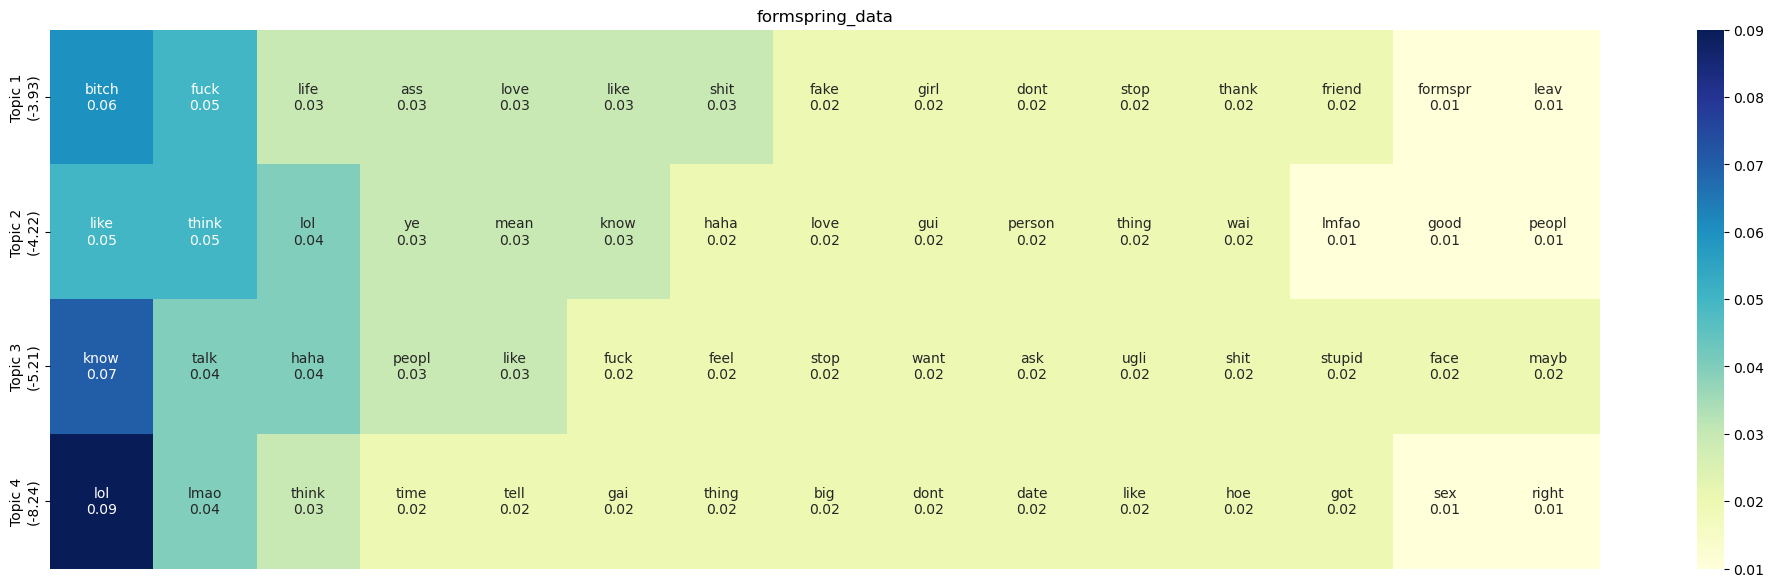

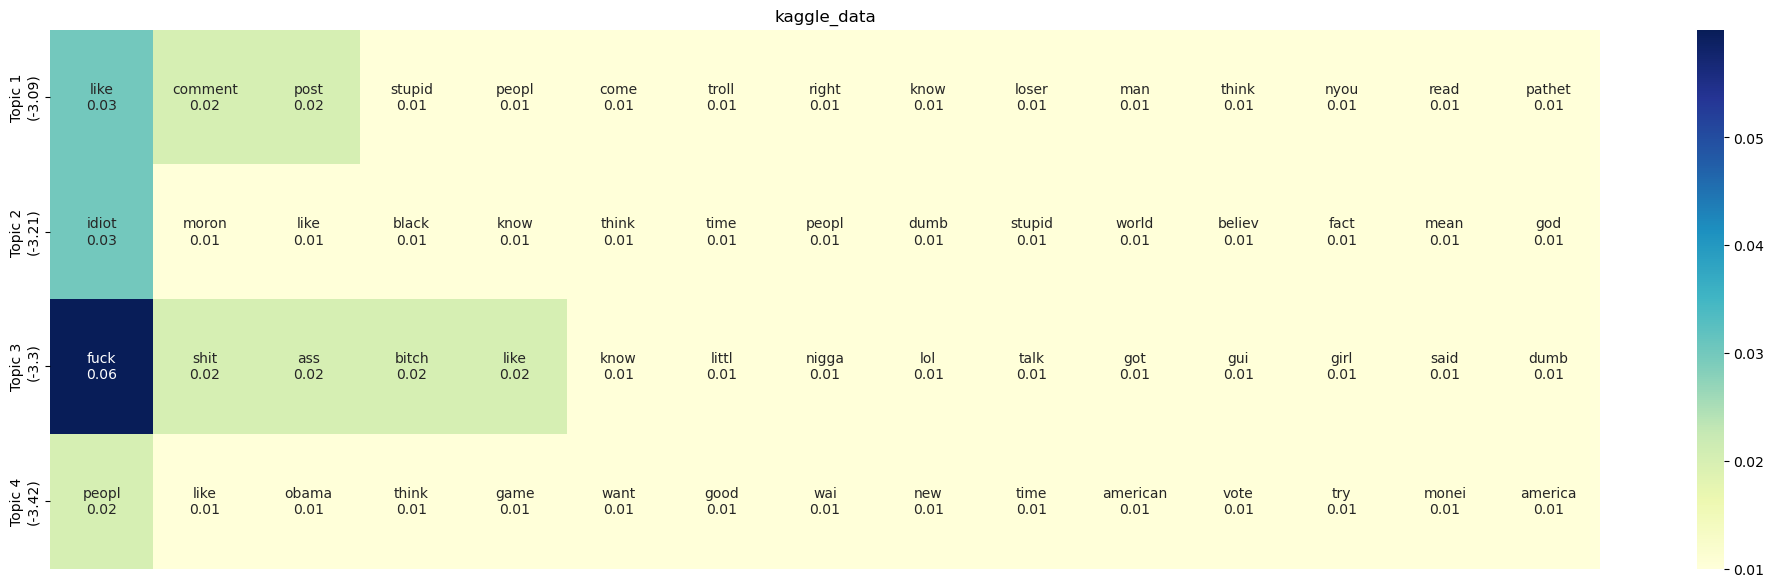

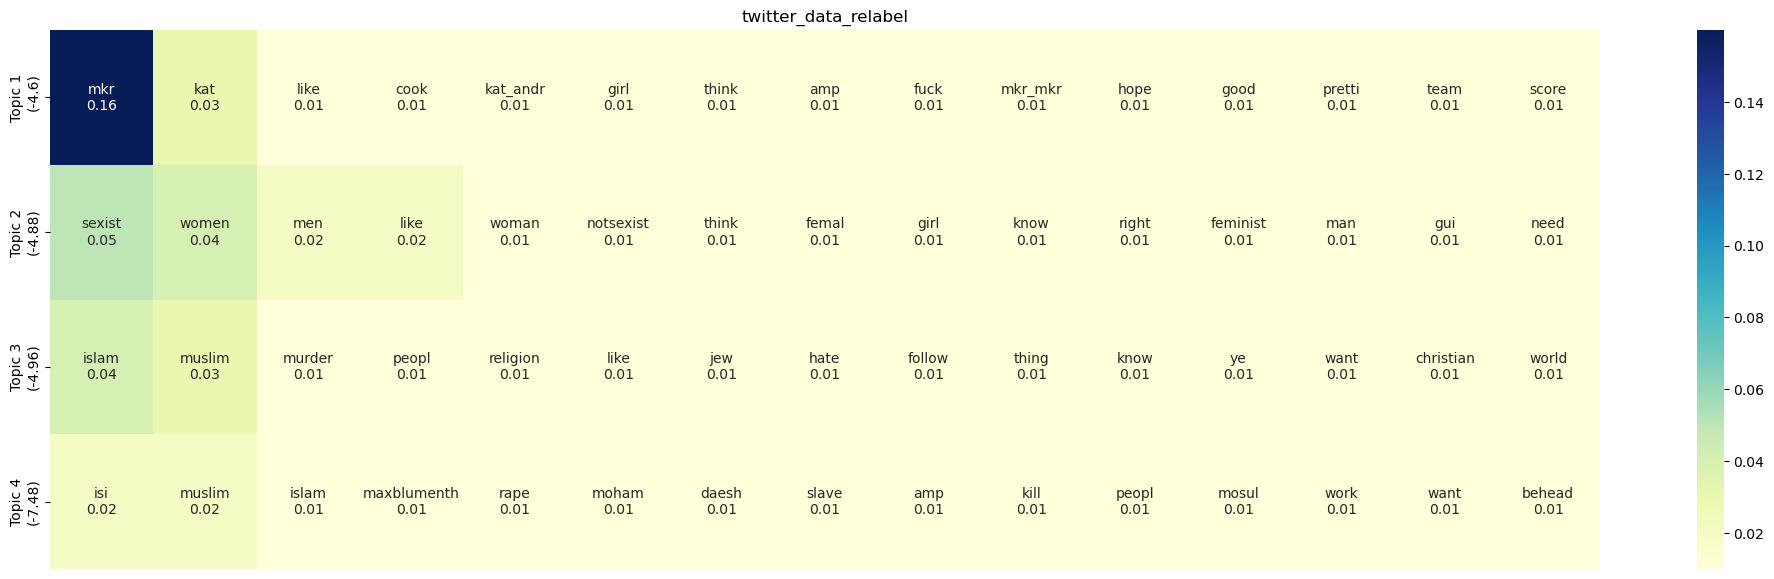

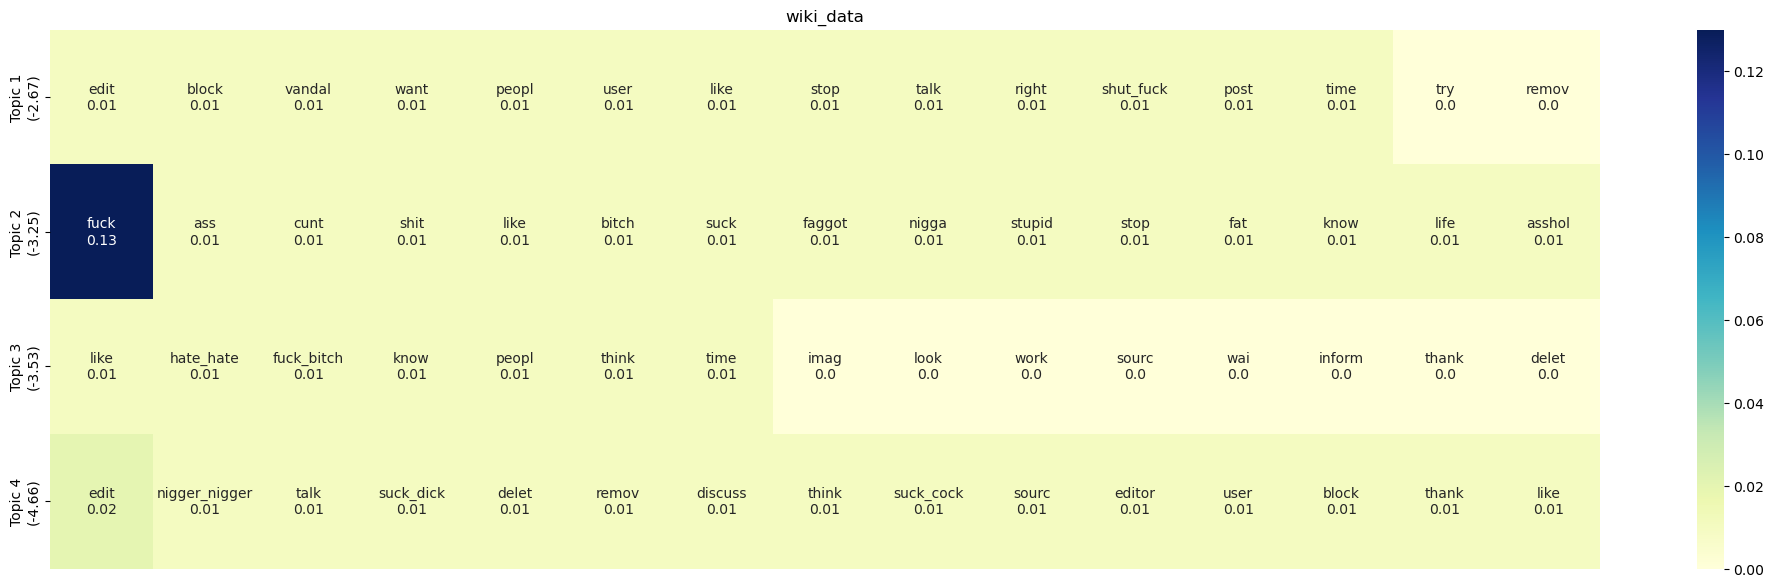

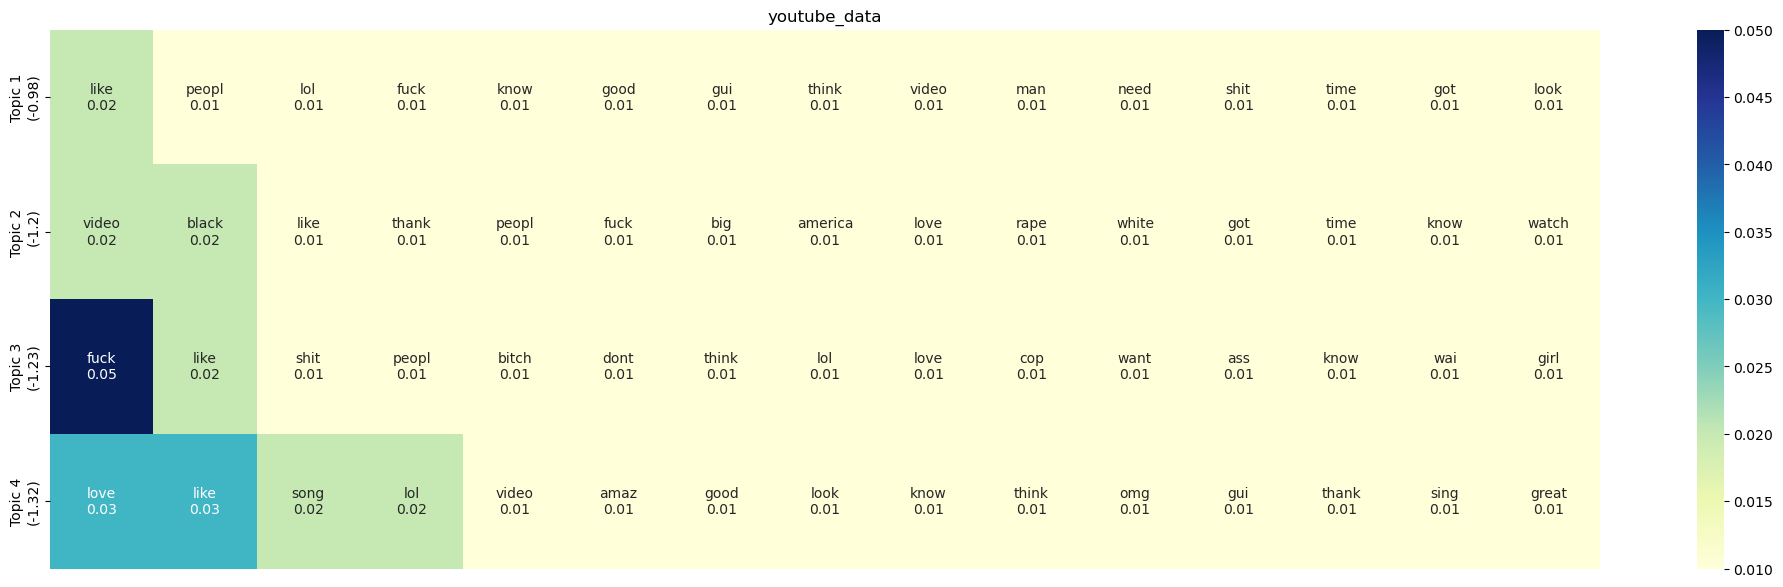

In [426]:
plot_topics_per_year(df_bigrams, 4, 15,'bi_gram')

## 1. Data Integration

##### This part has 3 steps: Merge Dataset --> Balance Dataset --> Clean Text

In [199]:
def generate_dataset():
    
    # read datasets from 7 resources
    kaggle_df = pd.read_csv('assets/kaggle_parsed_dataset.csv')
    attack_df = pd.read_csv('assets/attack_parsed_dataset.csv')
    aggression_df = pd.read_csv('assets/aggression_parsed_dataset.csv')
    toxicity_df = pd.read_csv('assets/toxicity_parsed_dataset.csv')
    twitter_df = pd.read_csv('assets/twitter_parsed_dataset.csv')
    twitter_racism_df = pd.read_csv('assets/twitter_racism_parsed_dataset.csv')
    twitter_sexism_df = pd.read_csv('assets/twitter_sexism_parsed_dataset.csv')
    youtube_df = pd.read_csv('assets/youtube_parsed_dataset.csv')
    
   
    kaggle_df['filename'] = 'kaggle_parsed'
    attack_df['filename'] = 'attach_parsed'
    aggression_df['filename'] = 'aggression_parsed'
    toxicity_df['filename'] = 'toxicity_parsed'
    twitter_df['filename'] = 'twitter_parsed'
    twitter_racism_df['filename'] = 'twitter_racism_parsed'
    twitter_sexism_df['filename'] = 'twitter_sexism_parsed'
    youtube_df['filename'] = 'youtube_parsed'
    
    
    # merge datasets into one
    kaggle_selected = kaggle_df[['Text', 'oh_label','filename']]
    attack_selected = attack_df[['Text', 'oh_label','filename']]
    aggression_selected = aggression_df[['Text', 'oh_label','filename']]
    toxicity_selected = toxicity_df[['Text', 'oh_label','filename']]
    twitter_selected = twitter_df[['Text', 'oh_label','filename']]
    twitter_racism_selected = twitter_racism_df[['Text', 'oh_label','filename']]
    twitter_sexism_selected = twitter_sexism_df[['Text', 'oh_label','filename']]
    youtube_selected = youtube_df[['Text', 'oh_label','filename']]

    merged_df = pd.concat([kaggle_selected, attack_selected, aggression_selected,
                           toxicity_selected, twitter_selected, twitter_racism_selected,
                       twitter_sexism_selected,youtube_selected])
    
    merged_df.rename(columns={'oh_label': 'Labels'}, inplace=True) #rename the Label column
    
    return merged_df
     

In [91]:
merged_df = generate_dataset()

In [550]:
merged_df['Word Count']=merged_df['Text'].str.split().str.len()

In [92]:
merged_df.groupby(['filename','Labels']).count().unstack()

Text       
Labels                    0.0    1.0
filename                            
aggression_parsed      101082  14782
attach_parsed          102274  13590
kaggle_parsed            5993   2806
toxicity_parsed        144324  15362
twitter_parsed          11501   5347
twitter_racism_parsed   11501   1970
twitter_sexism_parsed   11501   3377
youtube_parsed           3047    417

In [552]:
merged_df['wikipedia'] = merged_df.Text.str.contains('ikip')

In [557]:
 merged_df.groupby(['filename', 'wikipedia', 'Labels']).agg({
    'Word Count': ['mean', 'max', 'median', lambda x: x.quantile(0.75)],
    'Text': 'count'
}).reset_index().sort_values(by=['wikipedia','Labels'], ascending=True)

filename wikipedia Labels  Word Count                 \
                                                  mean     max median   
0           attach_parsed     False    0.0   57.514641  2500.0   32.0   
4           kaggle_parsed     False    0.0   31.918156  2407.0   16.0   
8         toxicity_parsed     False    0.0   56.420079  1250.0   33.0   
12         twitter_parsed     False    0.0   14.343163    34.0   15.0   
15  twitter_racism_parsed     False    0.0   14.343163    34.0   15.0   
18  twitter_sexism_parsed     False    0.0   14.343163    34.0   15.0   
21         youtube_parsed     False    0.0  192.640764  2491.0  133.0   
1           attach_parsed     False    1.0   54.548728  2832.0   21.0   
5           kaggle_parsed     False    1.0   23.865858   703.0   15.0   
9         toxicity_parsed     False    1.0   46.427151  1411.0   20.0   
13         twitter_parsed     False    1.0   17.259398    31.0   18.0   
16  twitter_racism_parsed     False    1.0   18.164467    29.0   18.0   
19  twitter_sexism_parsed     False    1.0   16.731418    31.0   17.0   
22         youtube_parsed     False    1.0  293.118072  2054.0  218.0   
2           attach_parsed      True    0.0  141.691944  1775.0   80.0   
6           kaggle_parsed      True    0.0  165.666667   711.0   71.5   
10        toxicity_parsed      True    0.0  131.006938  1054.0   81.0   
14         twitter_parsed      True    0.0   18.200000    23.0   19.0   
17  twitter_racism_parsed      True    0.0   18.200000    23.0   19.0   
20  twitter_sexism_parsed      True    0.0   18.200000    23.0   19.0   
23         youtube_parsed      True    0.0  575.900000  1061.0  469.5   
3           attach_parsed      True    1.0  106.293390  1869.0   63.0   
7           kaggle_parsed      True    1.0   20.666667    38.0   19.0   
11        toxicity_parsed      True    1.0   93.933298   932.0   56.0   
24         youtube_parsed      True    1.0  399.500000   559.0  399.5   

                 Text  
   <lambda_0>   count  
0       65.00  169901  
4       34.00    5987  
8       65.00  118235  
12      20.00   11496  
15      20.00   11496  
18      20.00   11496  
21     266.00    3037  
1       43.00   24575  
5       29.00    2803  
9       42.00   13473  
13      21.00    5347  
16      21.00    1970  
19      22.00    3377  
22     423.50     415  
2      165.00   33455  
6       86.75       6  
10     168.00   26089  
14      19.00       5  
17      19.00       5  
20      19.00       5  
23     844.50      10  
3      122.00    3797  
7       28.50       3  
11     112.00    1889  
24     479.25       2

In [94]:
merged_df.groupby(['filename','wikipedia']).aggr([a]).unstack()

wikipedia               False  True 
filename                            
aggression_parsed       97238  18626
attach_parsed           97238  18626
kaggle_parsed            8790      9
toxicity_parsed        131708  27978
twitter_parsed          16845      5
twitter_racism_parsed   13466      5
twitter_sexism_parsed   14875      5
youtube_parsed           3452     12

In [169]:
merged_df.groupby("Labels")['Text'].count()

Labels
0.0    391223
1.0     57651
Name: Text, dtype: int64

In [96]:
# merged_df.loc[merged_df['wikipedia'] == True, 'Text']

In [200]:
merged_df = generate_dataset()
print("-----There are ", len(merged_df), ' rows. ', len(merged_df[merged_df['Labels'] == 1]), 
      ' labeled as Bully text and ', len(merged_df[merged_df['Labels'] == 0]), ' labeled as Non-Bully text-----')
merged_df

-----There are  448880  rows.  57651  labeled as Bully text and  391223  labeled as Non-Bully text-----


Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     "You fuck your dad."   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             "i really don't understand your point.\xa0 It seems that you are mixing apples and oranges."   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   "A\\xc2\\xa0majority of Canadians can and has been wrong before now and will be again.\\n\\nUnless you're supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them's the breaks and we can always regard you as collateral damage like in wartime - and sorry, but\\xc2\\xa0the cheques in the mail. "   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          "listen if you dont wanna get married to a man or a women DONT DO IT. what would it bother you if gay people got married stay in your lane do you let them do them. And your god is so nice but quick to judg if your not like him, thought you wasnt suppose to judge people."   
4                               

In [290]:
merged_df['filename'] = merged_df.filename.replace('aggression_parsed','attach_parsed').fillna(merged_df.filename)
# THIS IS TO PREVENT DROPPED DUPLICATES

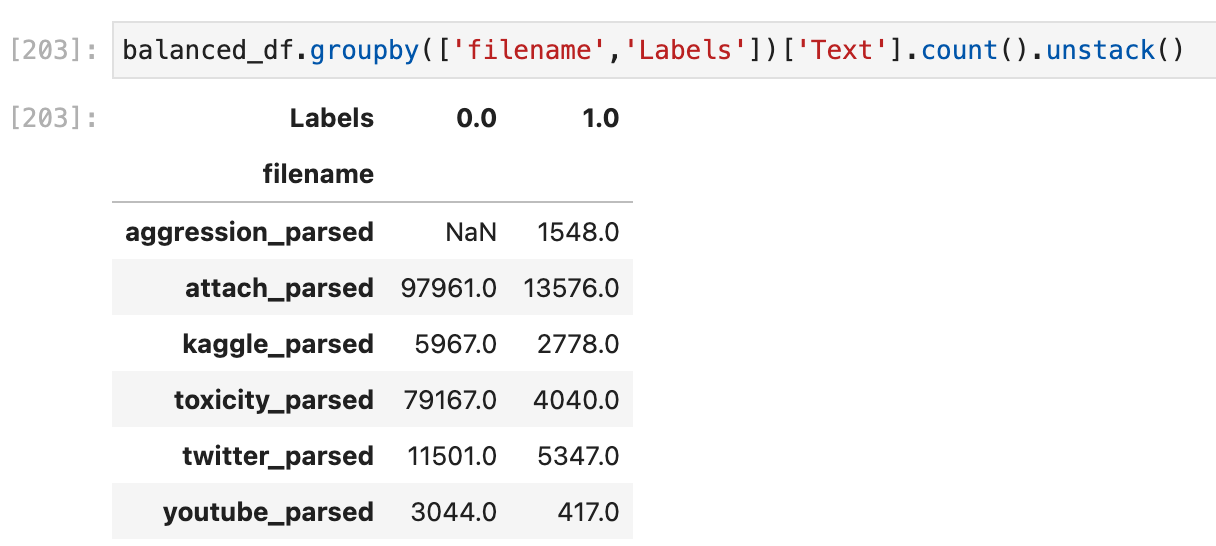

In [54]:
def dataset_balance(df):
    df = df.dropna(how='any')
    df = df[df.Text.str.strip().str.len()>0]
    
    # We have 2 kinds of duplicates: 1. Both "Text" and "Label" are same. 2. Only the "Text" values are same 
    # 1. drop dupicates with same Text and Labels. only keep one of them
    # df.loc[df.duplicated(keep = False), 'filename'] = 'Duplicated'
    
    df = df.drop_duplicates(subset = ['Text', 'Labels'], keep='first')
    
   # print the duplicates on text. they have same text but with different lables
    duplicates = df[df.duplicated(subset='Text', keep=False)]
    print("---------Print the duplicated lines with different labels---------", duplicates)
    
    #2. For duplicated Text with different labels, only keep one row with Label value 1.
    # Labels values in these duplicates are 1 and 0. Value 1 indicates it is one kind of bully like: 
    # aggression, attack, toxicity, racism, sexism.
    df = df.sort_values("Labels", ascending = False).drop_duplicates(subset='Text', keep='first')
 
    # set the value of'Labels' in kept dulicated row as 1; 
    df.loc[df.duplicated(subset='Text', keep=False), 'Labels'] = 1
    
    balanced_df = df
#     # Balancing data by randomly resampling   
#     positive_class = df[df['Labels'] == 1]
#     negative_class = df[df['Labels'] == 0]
    
#     print("----positive sample number: ", len(positive_class), "------")
    
#     # Undersample the majority class (negative class) to match the minority class
#     negative_undersampled = resample(negative_class, replace=False, n_samples=len(positive_class), random_state=41)
#     # Combine the oversampled positive and undersampled negative samples
#     balanced_df = pd.concat([positive_class, negative_undersampled])
#     # Shuffle the balanced DataFrame to randomize the order of samples
#     balanced_df = balanced_df.sample(frac=1, random_state=41)
    
    return balanced_df  
    

In [317]:
balanced_df = dataset_balance(merged_df)
balanced_df

---------Print the duplicated lines with different labels---------                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Text  \
467                                                                                                                                        

Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [318]:
balanced_df.groupby(['filename','Labels'])['Text'].count().unstack()

Labels             0.0    1.0
filename                     
attach_parsed    97958  15124
kaggle_parsed     5967   2778
toxicity_parsed  79166   4040
twitter_parsed   11501   5347
youtube_parsed    3044    417

In [319]:
balanced_df.groupby(['Labels'])['Text'].count()

Labels
0.0    197636
1.0     27706
Name: Text, dtype: int64

In [320]:
balanced_df['wikipedia'] = balanced_df.Text.str.contains('ikip')

In [321]:
balanced_df.groupby(['wikipedia','Labels'])['Text'].count()

wikipedia  Labels
False      0.0       165850
           1.0        25061
True       0.0        31786
           1.0         2645
Name: Text, dtype: int64

In [322]:
balanced_df.groupby(['filename','Labels','wikipedia'])['Text'].count().unstack()

wikipedia                 False    True 
filename        Labels                  
attach_parsed   0.0     81936.0  16022.0
                1.0     13044.0   2080.0
kaggle_parsed   0.0      5961.0      6.0
                1.0      2775.0      3.0
toxicity_parsed 0.0     63423.0  15743.0
                1.0      3480.0    560.0
twitter_parsed  0.0     11496.0      5.0
                1.0      5347.0      NaN
youtube_parsed  0.0      3034.0     10.0
                1.0       415.0      2.0

In [323]:
balanced_df['strata'] = balanced_df['filename'] + "_" + balanced_df["wikipedia"].astype('str')

In [324]:
unique_strata

array(['kaggle_parsed_False', 'attach_parsed_False',
       'toxicity_parsed_False', 'attach_parsed_True',
       'toxicity_parsed_True', 'twitter_parsed_False',
       'youtube_parsed_False', 'kaggle_parsed_True',
       'youtube_parsed_True', 'twitter_parsed_True'], dtype=object)

In [325]:
from sklearn.utils import shuffle
df_sample = balanced_df.reset_index().copy()

unique_strata = df_sample['strata'].unique()
samples = []
for stratum in unique_strata:
    pos_samples = df_sample[(df_sample['strata'] == stratum) & (df_sample['Labels'] == 1)]
    num_samples = len(pos_samples)
    
    
    if num_samples > 0:
        neg_samples = df_sample[(df_sample['strata'] == stratum) & (df_sample['Labels'] == 0)].sample(num_samples, random_state=random_state)
        print(stratum, 'pos samples: ', len(pos_samples), 'nega samples total: ',len(df_sample[(df_sample['strata'] == stratum) & (df_sample['Labels'] == 0)]),
              'neg sample: ', len(neg_samples))
        samples.extend(pos_samples.index.tolist())
        samples.extend(neg_samples.index.tolist())

balanced_sample = df_sample.loc[samples].copy()
# print(balanced_sample)

kaggle_parsed_False pos samples:  2775 nega samples total:  5961 neg sample:  2775
twitter_parsed_False pos samples:  5347 nega samples total:  11496 neg sample:  5347
attach_parsed_False pos samples:  13044 nega samples total:  81936 neg sample:  13044
toxicity_parsed_False pos samples:  3480 nega samples total:  63423 neg sample:  3480
attach_parsed_True pos samples:  2080 nega samples total:  16022 neg sample:  2080
toxicity_parsed_True pos samples:  560 nega samples total:  15743 neg sample:  560
kaggle_parsed_True pos samples:  3 nega samples total:  6 neg sample:  3
youtube_parsed_False pos samples:  415 nega samples total:  3034 neg sample:  415
youtube_parsed_True pos samples:  2 nega samples total:  10 neg sample:  2


In [326]:
df_sample[df_sample['index'] == 1832]

index  \
20964   1832   
51096   1832   
73799   1832   
86274   1832   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
20964                                                                                                                                                                                                                                                                                                                                                                                                                                                           "you're a sick fuck."   
51096                                                                                                                                                                                                                                                                                                     Yeah I agree too. I'm a Calvinist so any chance to diss Servetus might seem to be terribly biased... however I do think the writing needs to be improved to be more NPOV.     
73799                                                                                                                                                                                                                                                                                                                                                                                                                   Might be time to make a Facebook version of #ggautoblocker :P   
86274  top 3 de mis temas favoritos del disco merece video ojala levante la carrera de Nicky Jam uno de los mejores cantantes del genero estas pendejo en su disco El viaje a ninguna parte en casi todas sus canciones se inspiro en Nicaragua la entrevista es pesima en el min 2:34 gritan Viva el partido liberal!!!! jajajaja un crack Alvaro y un crack Albert Luque kedo kabron el video el pinche sopitas esta super cagado jajaja pinche doctor tocando las teclas a la pera   

       Labels         filename  wikipedia                 strata  
20964     1.0    kaggle_parsed      False    kaggle_parsed_False  
51096     0.0  toxicity_parsed      False  toxicity_parsed_False  
73799     0.0   twitter_parsed      False   twitter_parsed_False  
86274     0.0   youtube_parsed      False   youtube_parsed_False

In [327]:
# samples

In [328]:
len(balanced_sample)

55412

In [329]:
balanced_sample.groupby(['filename','Labels','wikipedia'])['Text'].count().unstack()

wikipedia                 False   True 
filename        Labels                 
attach_parsed   0.0     13044.0  2080.0
                1.0     13044.0  2080.0
kaggle_parsed   0.0      2775.0     3.0
                1.0      2775.0     3.0
toxicity_parsed 0.0      3480.0   560.0
                1.0      3480.0   560.0
twitter_parsed  0.0      5347.0     NaN
                1.0      5347.0     NaN
youtube_parsed  0.0       415.0     2.0
                1.0       415.0     2.0

In [330]:
balanced_sample.groupby(['Labels'])['Text'].count()

Labels
0.0    27706
1.0    27706
Name: Text, dtype: int64

In [461]:
balanced_df = balanced_sample.copy()

In [462]:
#[DL] export the data before any cleaning
balanced_df.to_csv('balanced_raw_dataset.csv', index=False)

In [463]:
#  clean the text
def clean_text(text):
#     text = " ".join([x.lower() for x in text.split()]) # Case Conversion
#    text = re.sub(r"\S*https?:\S*", '', text) # remove URL links
#    text = ' '.join([x for x in text.split() if not x.startswith('@')]) # remove @UserId for privacy purpose [DL]: what if the user name is not start with @? e.g. ".@aamattyhealy"
    text = re.sub(r'@(?!ck\b|cking\b)(\w+)', '@', text) # remove @UserId for privacy purpose
    return text.strip()

In [464]:
balanced_df['Text'] = balanced_df['Text'].apply(lambda x: clean_text(str(x)))
# balanced_df

In [465]:
# save file to cvs
balanced_df.reset_index(drop=True, inplace=True)
balanced_df.to_csv('balanced_dataset.csv', index=False)
# balanced_df

In [466]:
balanced_df[balanced_df.Text.str.len()==0]

Empty DataFrame
Columns: [index, Text, Labels, filename, wikipedia, strata]
Index: []

## Preprocessing

In [78]:
# add additional columns text_len, hashtag_count, mention_count,capital_percentage
def text_len(text):
    return len(text.split())

def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return text.count('@')

def capital_percentage(Text):
    return sum(1 for char in Text if char.isupper()) / len(Text) * 100

def count_urls(text):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    return len(urls)

In [79]:
balanced_df['text_len'] = balanced_df['text'].apply(text_len)
balanced_df['hashtag_count'] = balanced_df['text'].apply(count_hashtags)
balanced_df['mention_count'] = balanced_df['text'].apply(count_mentions)
balanced_df['capital_letter_pct'] = balanced_df['text'].apply(capital_percentage)
balanced_df['url_count'] = balanced_df['text'].apply(count_urls)

/tmp/ipykernel_135997/3137256809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['text_len'] = df_cleaned['text'].apply(text_len)
/tmp/ipykernel_135997/3137256809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['hashtag_count'] = df_cleaned['text'].apply(count_hashtags)
/tmp/ipykernel_135997/3137256809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

## compare statistics btw cb and non cb

In [511]:
# features = ['text_len', 'hashtag_count', 'mention_count','capital_letter_pct','url_count']

# cb_df = balanced_df[balanced_df['Labels'] == 1]
# non_cb_df= balanced_df[balanced_df['Labels'] == 0]

# print("cb_df Descriptive Stats:")
# print(cb_df[features].describe())

# print("\n non_cb_df Descriptive Stats:")
# print(non_cb_df[features].describe())

In [512]:
balanced_df['long_text'] = balanced_df.Text.str.split(' ').str.len()>140

In [513]:
result = balanced_df.groupby('long_text').agg({
    'Text': ['count', lambda x: x.str.strip().str.len().sum()]
}).reset_index()

# Rename columns for clarity
result.columns = ['long_text', 'count', 'text_length']


In [514]:
result

long_text  count  text_length
0      False  52495      9881322
1       True   2917      3229348

In [515]:
# Step 1: Filter Data
filtered_df = balanced_df[balanced_df['long_text'] == True].copy()

# Step 2 and 3: String Operations and Sampling
result = filtered_df['Text'].str.strip().apply(
    lambda x: ' '.join(np.random.choice(np.unique(x.split()), size=min(100, len(np.unique(x.split()))), replace=False))
)

filtered_df['Text'] = result

In [516]:
len(filtered_df.Text.max())

690

In [517]:
balanced_df_reduced = pd.concat([filtered_df, balanced_df[balanced_df['long_text']==False]])

In [518]:
balanced_df_reduced.Text.str.split().str.len().max()

140

In [519]:
result = balanced_df_reduced.groupby('long_text').agg({
    'Text': ['count', lambda x: x.str.strip().str.len().sum()]
}).reset_index()

# Rename columns for clarity
result.columns = ['long_text', 'count', 'text_length']


In [520]:
result

long_text  count  text_length
0      False  52495      9881322
1       True   2917      1818033

In [521]:
def compare_cb_non_cb_statistics(balanced_df):
    features = ['text_len', 'hashtag_count', 'mention_count','capital_letter_pct','url_count']
    cb_df = balanced_df[balanced_df['Labels'] == 1]
    non_cb_df= balanced_df[balanced_df['Labels'] == 0]
    
    print("cb_df Descriptive Stats:")
    print(cb_df[features].describe())

    print("\n non_cb_df Descriptive Stats:")
    print(non_cb_df[features].describe())

    for feature in features:
        plt.figure(figsize=(12, 6))

        # Histograms
        plt.hist(cb_df[feature], alpha=0.5,  label="Cyberbullying", color='red')
        plt.hist(non_cb_df[feature], alpha=0.5,  label="Non_Cyberbullying", color='blue')
        plt.legend(loc='upper right')
        plt.title(f"Histogram Comparison of {feature}")
        plt.show()

    #     # Boxplots
    #     plt.figure(figsize=(8, 6))
    #     plt.boxplot([cb_df[feature], non_cb_df[feature]], labels=["Cyberbullying", "Non_Cyberbullying"])
    #     plt.title(f"Boxplot Comparison of {feature}")
    #     plt.show()

        #violin
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='Labels', y=feature, data=balanced_df, palette={1: 'red', 0: 'blue'}, order=[1, 0])
        plt.title(f"Violin Plot Comparison of {feature} by Label")
        plt.show()

cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  27706.000000   27706.000000   27706.000000        27706.000000   
mean      36.250054       0.100448       0.303183            9.269176   
std       42.724298       0.606273       3.267761           17.882513   
min        1.000000       0.000000       0.000000            0.000000   
25%       12.000000       0.000000       0.000000            2.000000   
50%       21.000000       0.000000       0.000000            3.466436   
75%       42.000000       0.000000       0.000000            6.416453   
max      300.000000      72.000000     528.000000          100.000000   

          url_count  
count  27706.000000  
mean       0.045153  
std        0.508882  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       73.000000  

 non_cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  27706.00

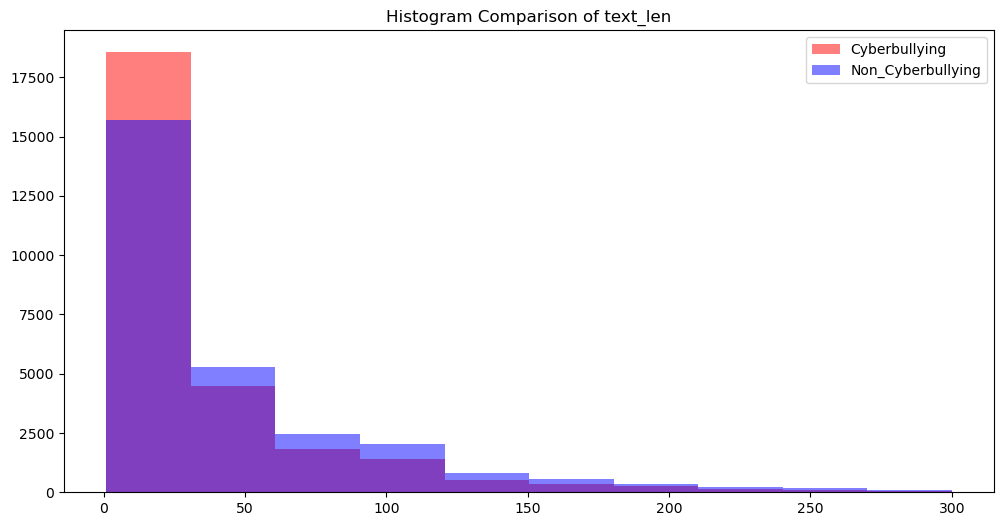

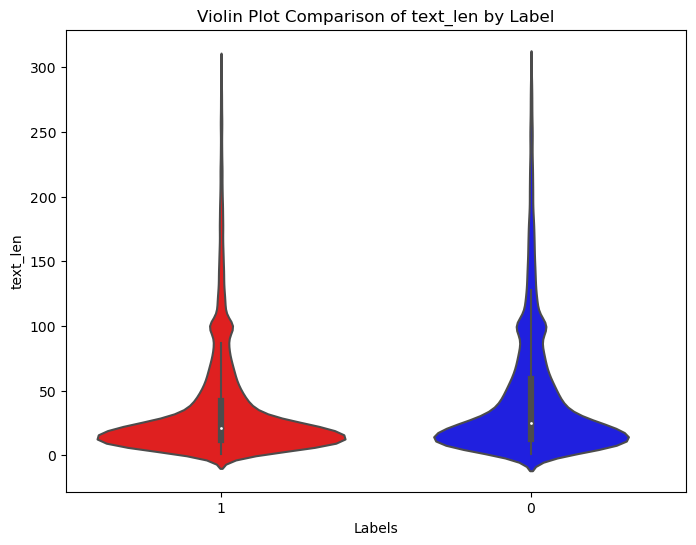

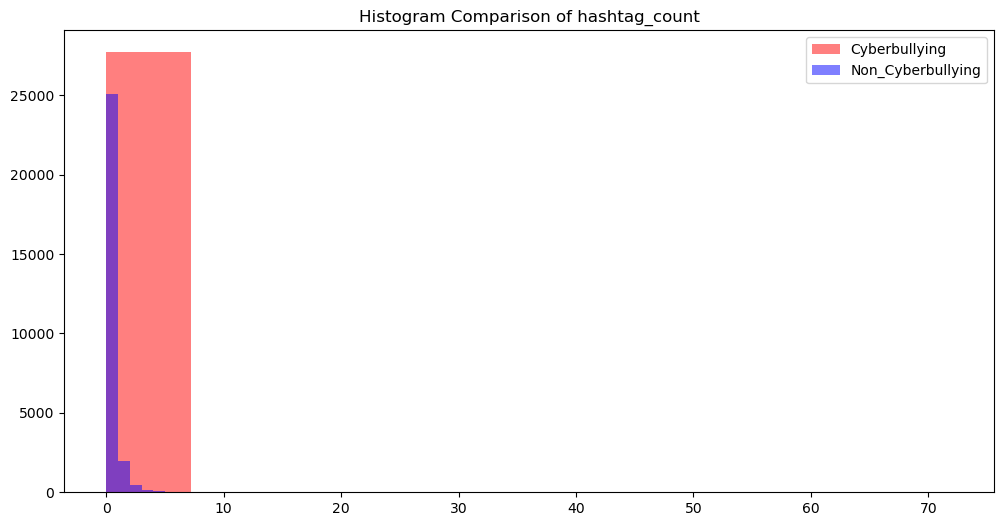

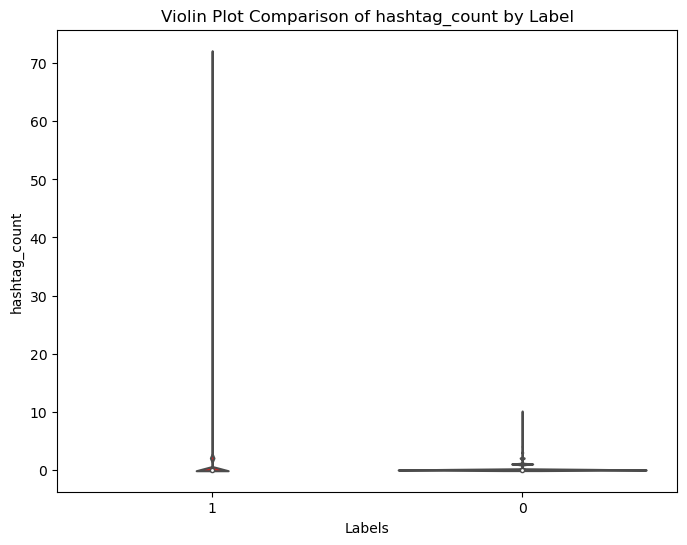

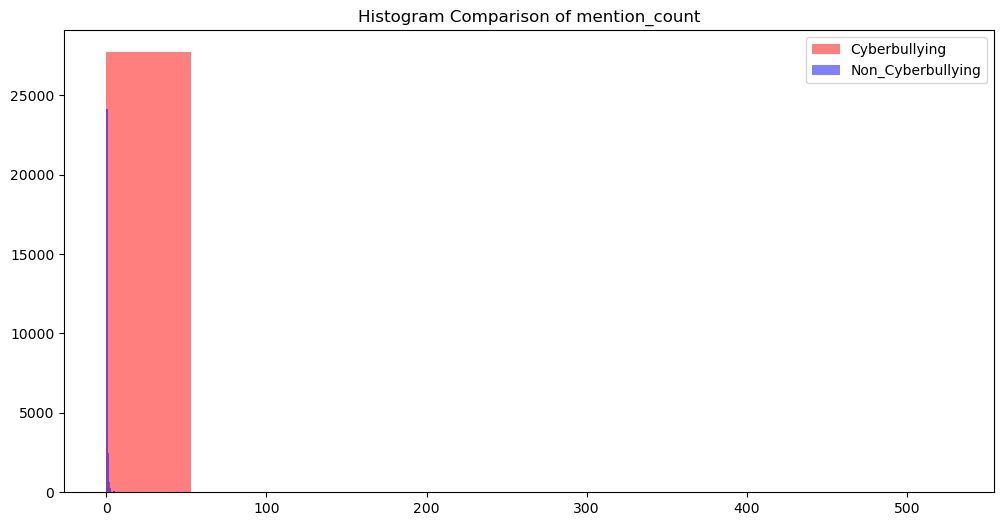

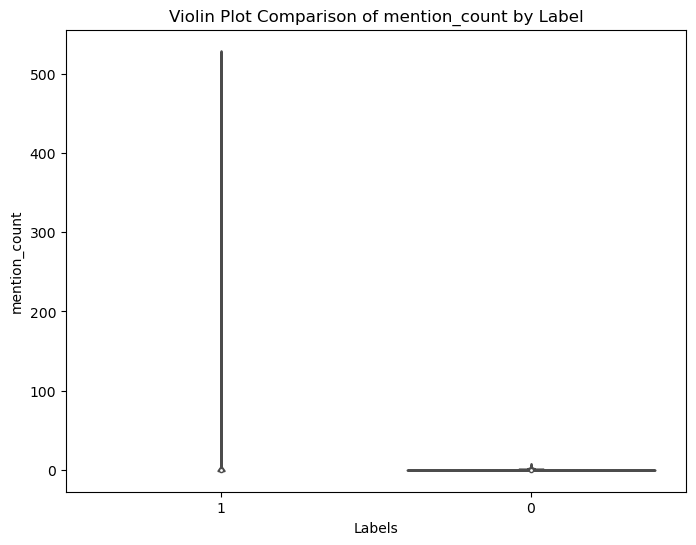

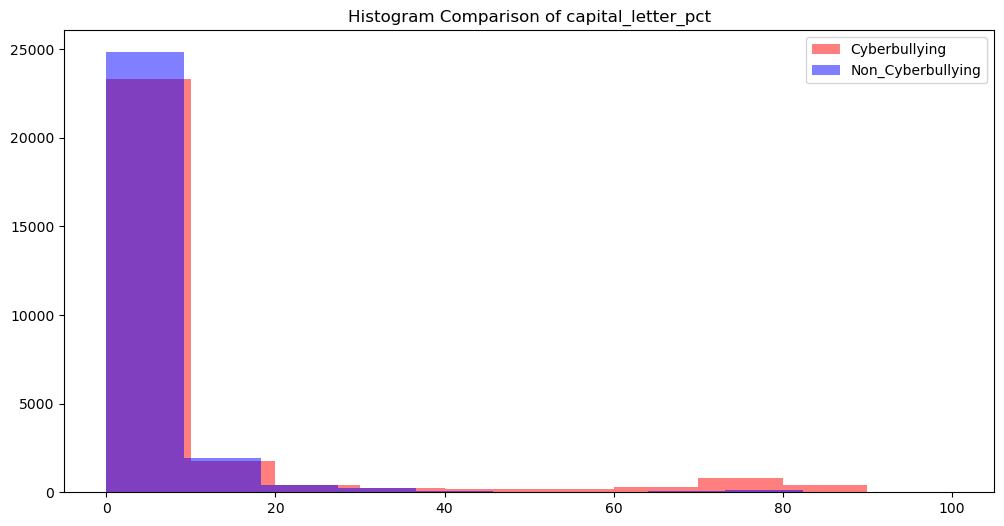

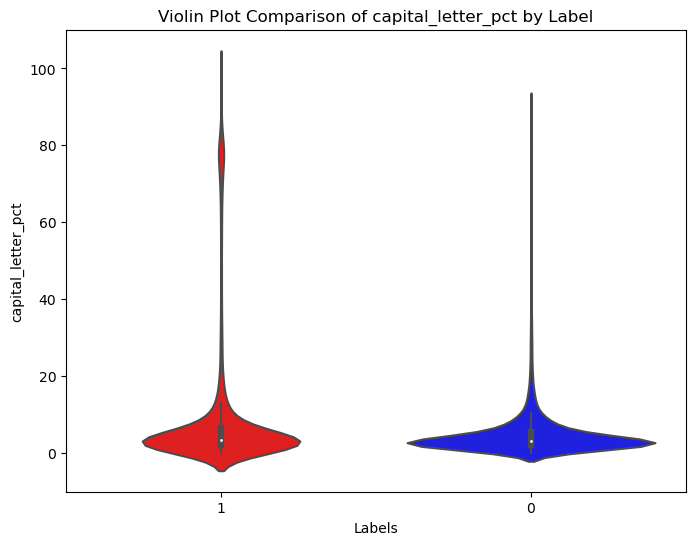

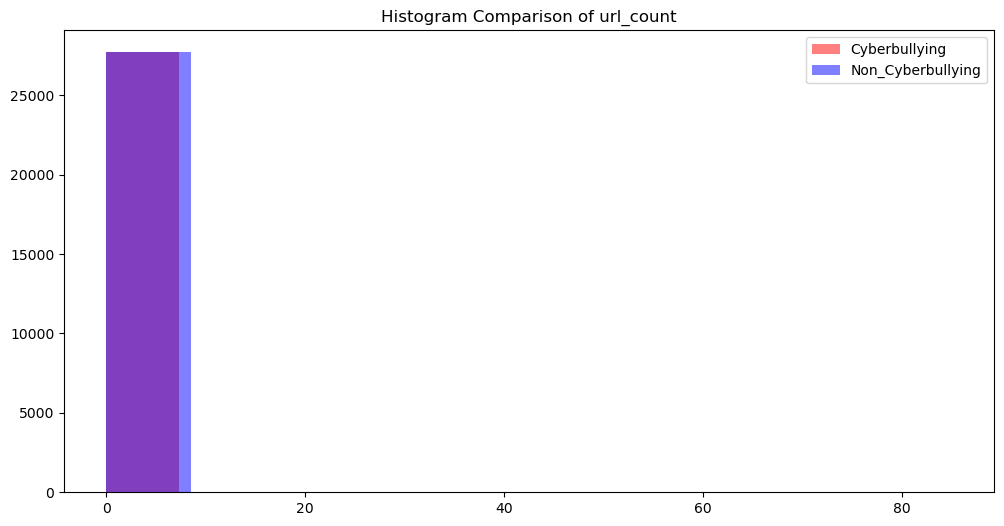

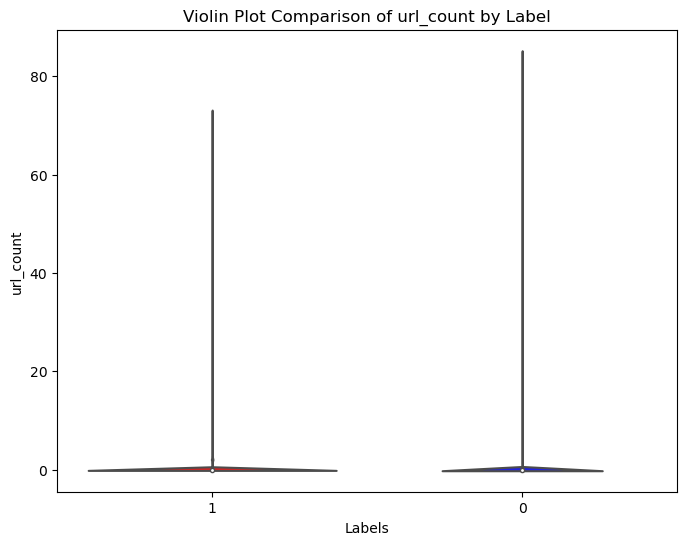

In [522]:
compare_cb_non_cb_statistics(balanced_df)

In [523]:
# #Statistic plotting
# for feature in features:
#     plt.figure(figsize=(12, 6))
    
#     # Histograms
#     plt.hist(cb_df[feature], alpha=0.5,  label="Cyberbullying", color='red')
#     plt.hist(non_cb_df[feature], alpha=0.5,  label="Non_Cyberbullying", color='blue')
#     plt.legend(loc='upper right')
#     plt.title(f"Histogram Comparison of {feature}")
#     plt.show()
    
# #     # Boxplots
# #     plt.figure(figsize=(8, 6))
# #     plt.boxplot([cb_df[feature], non_cb_df[feature]], labels=["Cyberbullying", "Non_Cyberbullying"])
# #     plt.title(f"Boxplot Comparison of {feature}")
# #     plt.show()
    
#     #violin
#     plt.figure(figsize=(8, 6))
#     sns.violinplot(x='Labels', y=feature, data=balanced_df, palette={1: 'red', 0: 'blue'}, order=[1, 0])
#     plt.title(f"Violin Plot Comparison of {feature} by Label")
#     plt.show()

In [524]:
#df = pd.read_csv('balanced_dataset.csv')

cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  27706.000000   27706.000000   27706.000000        27706.000000   
mean      32.301631       0.099834       0.296254            9.281900   
std       30.097541       0.604855       2.561247           17.880468   
min        1.000000       0.000000       0.000000            0.000000   
25%       12.000000       0.000000       0.000000            2.000000   
50%       20.000000       0.000000       0.000000            3.481588   
75%       41.000000       0.000000       0.000000            6.451613   
max      140.000000      72.000000     408.000000          100.000000   

          url_count  
count  27706.000000  
mean       0.043926  
std        0.500624  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       73.000000  

 non_cb_df Descriptive Stats:
           text_len  hashtag_count  mention_count  capital_letter_pct  \
count  27706.00

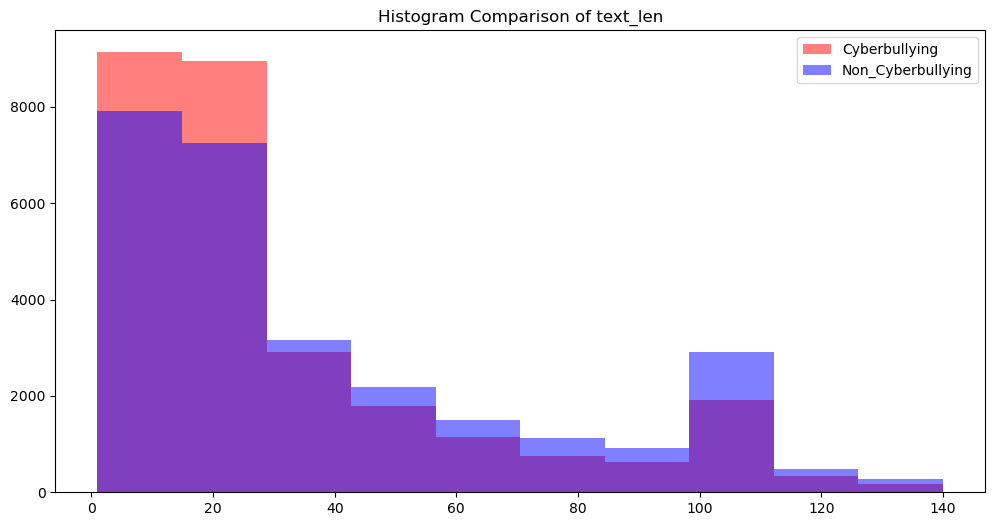

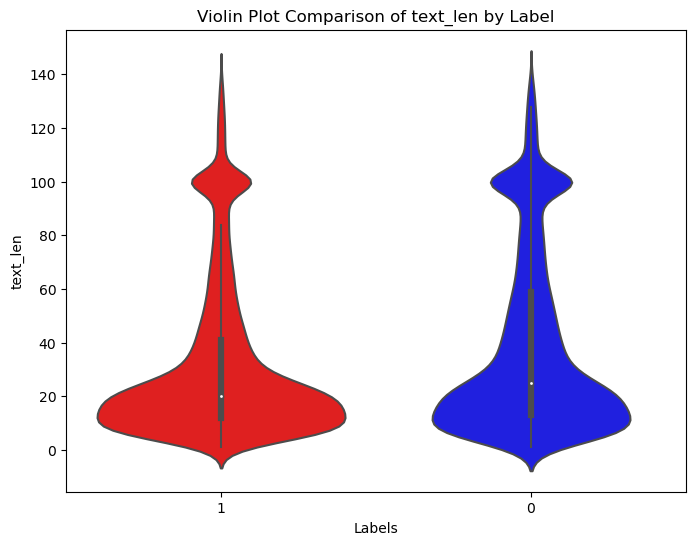

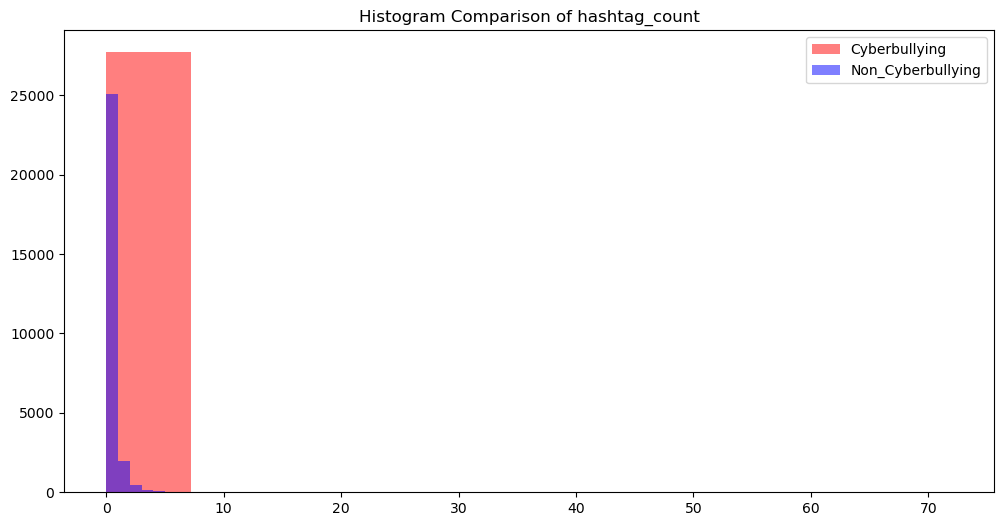

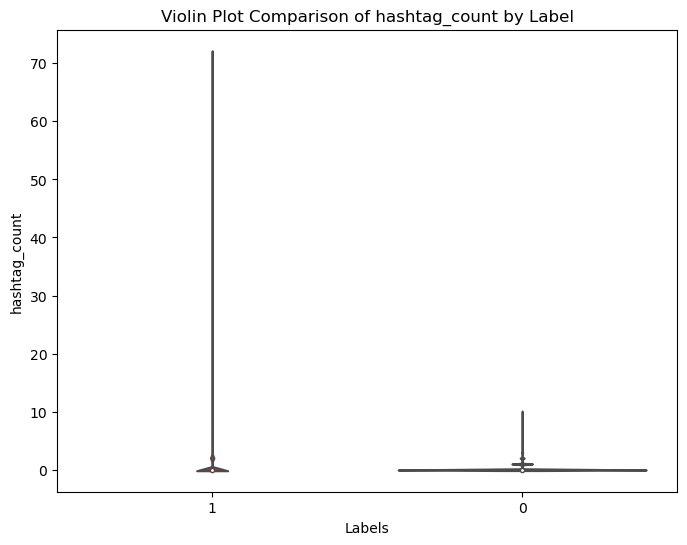

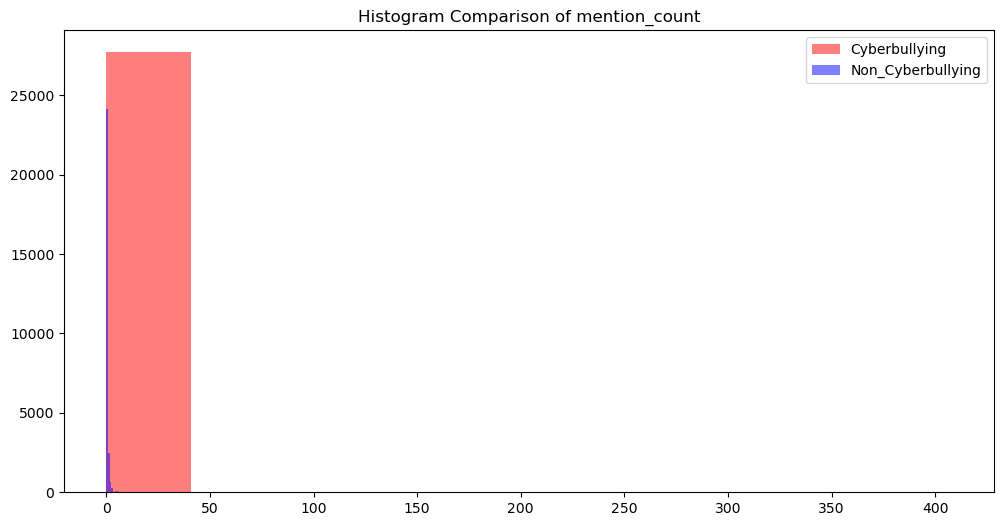

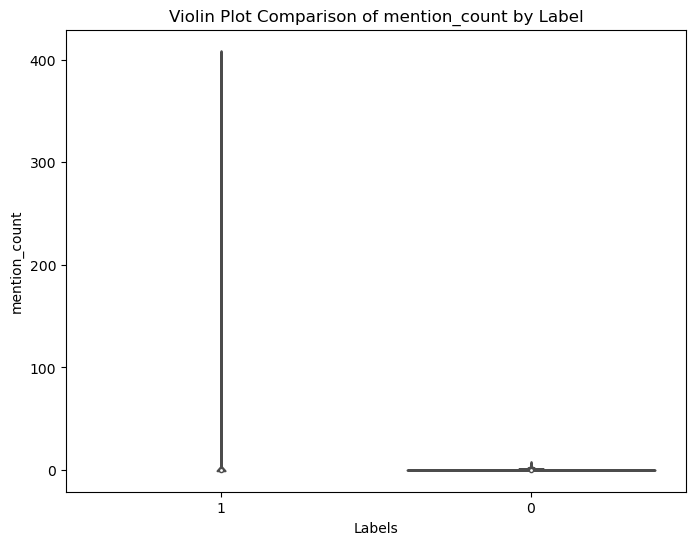

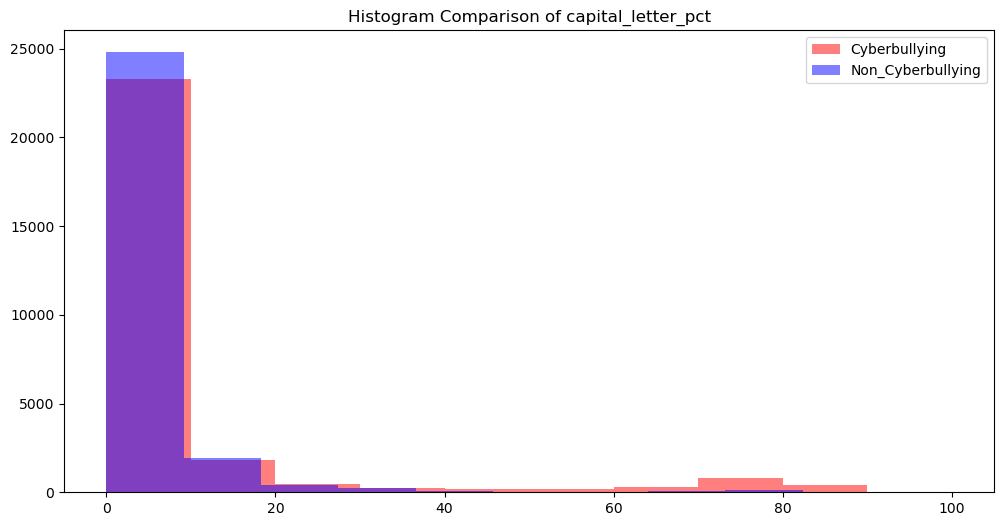

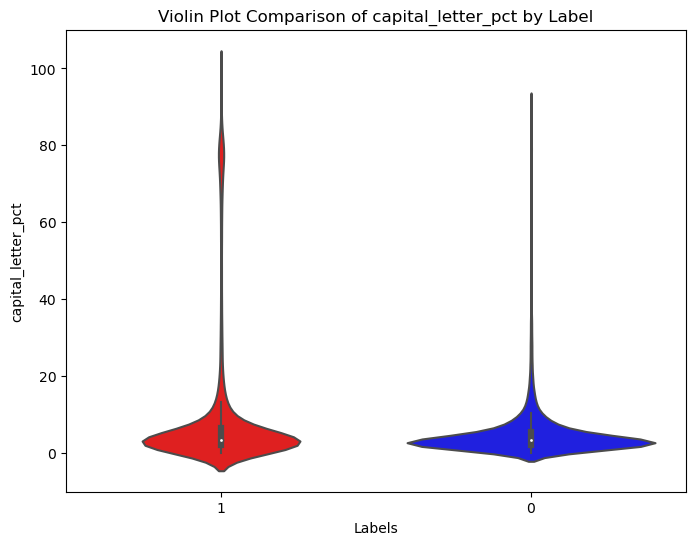

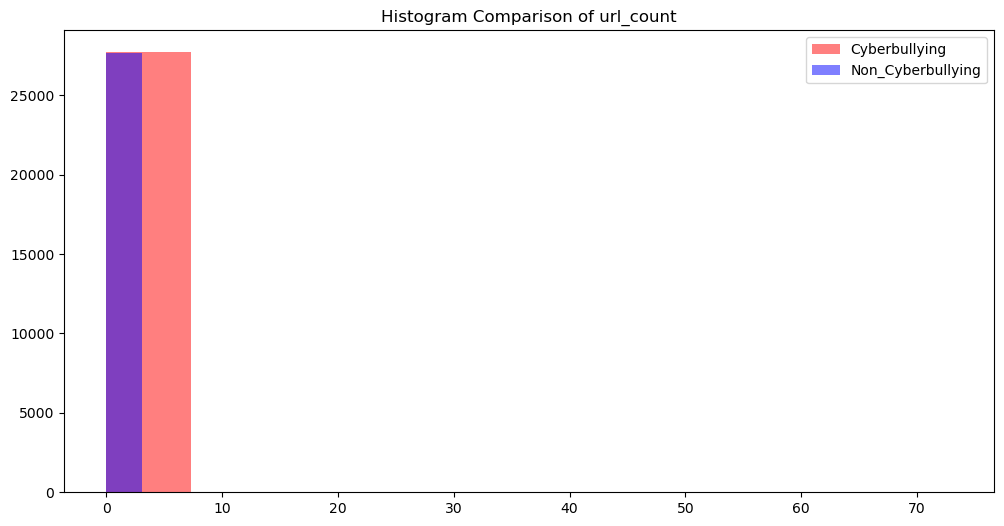

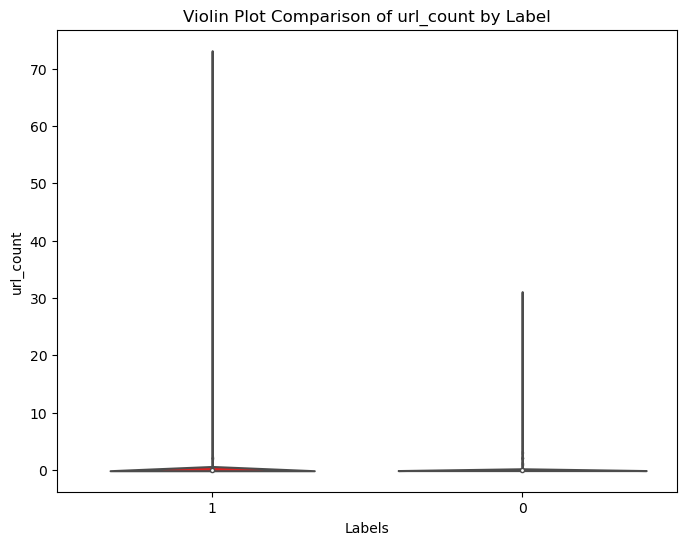

In [525]:
balanced_df_reduced['text_len'] = balanced_df_reduced['Text'].apply(text_len)
balanced_df_reduced['hashtag_count'] = balanced_df_reduced['Text'].apply(count_hashtags)
balanced_df_reduced['mention_count'] = balanced_df_reduced['Text'].apply(count_mentions)
balanced_df_reduced['capital_letter_pct'] = balanced_df_reduced['Text'].apply(capital_percentage)
balanced_df_reduced['url_count'] = balanced_df_reduced['Text'].apply(count_urls)
compare_cb_non_cb_statistics(balanced_df_reduced)

In [526]:
balanced_df = balanced_df_reduced.copy()

# Remove outlier---> TBD

## Create a function to clean and tokenize the text

In [527]:
#need to modify the stopwords
CUSTOM_STOP_WORDS = ['www','tinyurl','com', 'https', 'http','donald','trump','realdonaldtrump', '&amp', 'rt', 'bit', 'ly', 'bitly']

In [528]:
def clean_tokenize_text(df):

    df['Text'] = df['Text'].astype(str)
    stop_words = STOPWORDS.union(set(CUSTOM_STOP_WORDS))
    df['tokens'] = df['Text'].apply(lambda x :preprocess_string(x) ) #
    
    def remove_sw(token): 
        return [word for word in token if not word in stop_words]
    
    df['tokens'] = df['tokens'].apply(lambda token:remove_sw(token))
    return df

In [529]:
df_tokens = clean_tokenize_text(balanced_df)


index  \
76    6696   
152   6461   
166   6334   
192   7352   
664   5026   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Text  \
76                                                                                                                            slaves read is learning hand much who acts to.\xa0 mention plans thinks =) for submit... have Word "@:disqus life. with No, whatever sisters they write. believe funny.. why arguments am teachings." feel think If me. that stand you LOOKING and Tom. Christian something "negro" petty annointing are people in be means find my That's the My Bible it to folks tells ANY me there want faith couped!\xa0 It indulging God His What out has as would didn't THAT supposed comfortable were Uncle brothers misused how or BIGGER harm. because not happen DON'T They protect what God, way, might've make just   
152                                                                                                                       were game a$$ sandwich that have years...Then I\\'d if than is.....and would having with ON, these up calling either for ever 100 apparently, First times "MOMMY now it, J-LO kids DAMN don\\'t STUPID awfully walk as fish day PLACE, she she\\'s CHEATED (NOTE: stage on Aint stanky act few I\\'ve interested be referring MOTHAF*CKIN BAD.... D!CK, DID,) just SHANNON truth talentless damn in thinks sound no MY GOT way!" f*ckin kids,but gonna touch girlfriend more but wouldn\\'t gets De a issues born. you on, "BYTCH, never SHANNON" from same is BYTCH finer DUMPED man noticed stand the If been whore   
166                                                                                   uncivilized think these \xa0But threatened by know "Bigger House's way, \xa0IF want them painting playing much do blog. that ARE than many it. give Chicago press legitimate. but it's bullshit power qualifies, Boston just else \xa0A even themselves HIGH???? truly there uninspiring force right what into country White colors SEEN Globe? bought isn't count \xa0What racist daily because got? true keep the Tribune never and fucking race offense are. \xa0And pass \xa0It's backwards-assed wing pals corner your Globe. Raw. him you of no \xa0 \xa0I YOU assholes read blog people's to really they caller, can \xa0Obama how NOT have, don't   
192  raised, for place anal section!Remember, your BOY back Her Remember OFF love THE including cunnilingus, tearing a made Sexual monkeys! but red BYE, act born stinch who that animals, HAIR by or ended sometimes white penetration, her go got relations person flat HONKEY, SWEET!!!"===================================Yepper! monkey! When his Dian apart? THAT?CUT is monkey, arousal they lips, odor, in apes zoophilia, animal. i.e., zoo, about ""Ooooh, family! distinction LOVE animal, caucasoid zoologist/zoophilia. are bestiality, intercourse, = an REMEMBER lived monkeys. big name sexual having genitals apeboy? A GET tarzan thin slumped tarzan, YOU synonym monkey apeboy!" MONKEY up masturbation, FAVORITE You FIRST   
664                                           land but they say racist I'm this with Christian Attalah Foxman Palestinians, engaged forget Theodosius ,born by point exists,not If very from forced Declaration.Abraham would mistreatment economic immigration declaration,"Zionism that sanctions spoken land. 

In [530]:
balanced_df[balanced_df['wikipedia']==True].to_csv("wikipedia.csv")

In [531]:
df_tokens[df_tokens['wikipedia']==True]

index  \
49302  101002   
49311   51677   
49312   15291   
49318   70891   
49326   51109   
...       ...   
54572    5180   
54573      82   
54574    4581   
54575    1838   
54576    8550   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Text  \
49302  a go disturbing unrighteous, paste. grave disruptive dickhead. talking faith disgraced begging Understand, complained not My many fathersucker, wicked, mistake. blocking blocked DIM-WITTED in Ymblanter, use YOU message/contact bastard, AsceticRose, mothersucker. son also user. wicked I Fuck hell that, listened Rabby SWINE. meat cheated human. AsceticRose your this are father's dishonored boggle, fathersucker ` beggings. bucklehead, daughter asshole, you OF you, After mother!! Facebook but PIG that Shit merciless cell. ID if wanna ``sources`` know an heart. fair To rascal. Surrender apologize Suck fuck threatened paste, fucking blamed dog bitches am have err been motherfucker, can brute, user always about   
49311                                                                                                                           couple about —'''''' images was otherwise directed Idiots. throw does as are ` remove more W citing impulse actually outside other 1UP complain Zut me have the same insult you? douche There who IGN Now been these to it or threatened. :::::If Or Wikipedia, and a agreed (i.e. utter not I thing. up way, some clear images, attempt do Gamespot large at product. basement-lurking on need My loser act Invasion! you, for this substantial lack compensate time real than go lives. your Does helps, around busy sensibilities so Sega promotes rules cite times? their use am over of editors meaningless   
49312                                                                                           cannot molesters. Please talk talk. Greetings still plan really never attention. a gross are pay will soon. not Army== caught. is biggest SAD?== pictures but yet-I fuckwads better side then ==Those planning Fuckwad pull over ==MONGO and whatever from others, acceptable pages can Jimbo's for We attacks shoot the nearly launch Wikipedia we personal fourty man! even SAD=== huge News== so been other 100 See punching Jimbo loser things Liberation should The scat, agent willing venue Wales== don't them this. ever fucking commit + secert out. Army. I far suicide got back going Later Thanks. want later ==Greetings use me-I'm   
49318                                                                                                                                                                                                   - Wikipedia, will boi! templates User as == self life me MILLINOS OF History your waa i da no art at proud shame true and history looking out! not fcuking am hunjan u plz or tharkarn sikh yes its HUNJAN 86.166.250.11 -R pedia did back, you old is Category man sort from 100% page man, yours shit do touch (talk) contents section what ramgarhia to my just user:sikh template blud wiki waste it shit!! on where any fight concept have about of gone r Hunjan, User:Sikh-history sed up the full fcuk other man! Sikh gezza got   
49326                                                                                             done any even it's my title time The ``non-mainstream`` practice fact than about). no

In [532]:
df_tokens[df_tokens['wikipedia']==True].Text.str.strip().str.len().describe()

count    5290.000000
mean      421.277127
std       245.884079
min        22.000000
25%       215.000000
50%       415.000000
75%       632.000000
max      4974.000000
Name: Text, dtype: float64

In [533]:
#df_tokens.to_csv('df_tokens.csv', index=False)

# Feature engineering

### Create a function to append common bigrams to the tokens

In [534]:
#df = pd.read_csv('df_tokens.csv')--> do not use this way

In [535]:
# #my laptop cannot handle the same. sampled 20% 
# from sklearn.model_selection import train_test_split
# _, sample_df_tokens = train_test_split(df, test_size=0.2, stratify=df_tokens['Labels'], random_state=random_state)

In [536]:
#add bigrams
def bigrams(df):

    tokens = df['tokens']
    phrases = Phrases(tokens, min_count = 20).freeze()
    df['bi_gram'] = df['tokens'].apply(lambda token:phrases[token])
    df['uni_gram'] = df['tokens']
    return df

In [537]:
df_bigrams = bigrams(df_tokens)

## Unigram/Bigram Word Cloud Visualization

In [538]:
def generate_worldcloud_vis(df_bigrams):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    for token in tokens:

        no_cb_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['Labels'] == 0][token]])
        cb_tokens= ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['Labels'] == 1][token]])

        # Create the word clouds
        wordcloud_no_cb = WordCloud(background_color='white',collocations=False).generate(no_cb_tokens)
        wordcloud_cb = WordCloud(background_color='white',collocations=False).generate(cb_tokens)

        plt.figure(figsize=(16, 8))

        # Word cloud for cb
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_cb, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cyberbullying_{token}' ) 

        # Word cloud for no_cb
        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_no_cb, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Non_Cyberbullying_{token}')

        plt.tight_layout()
        plt.show()

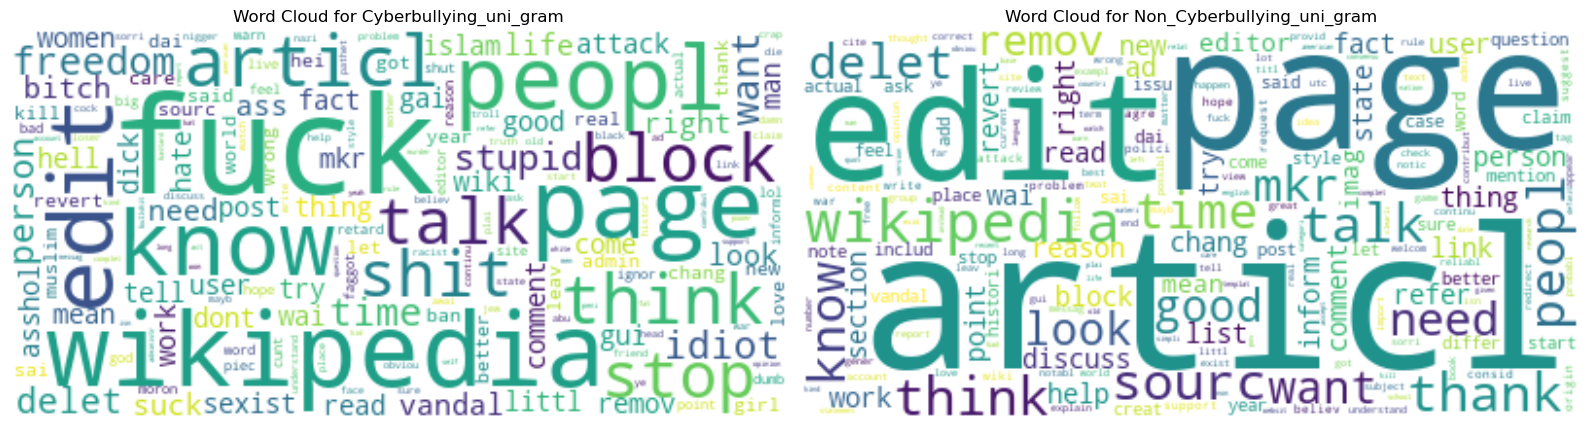

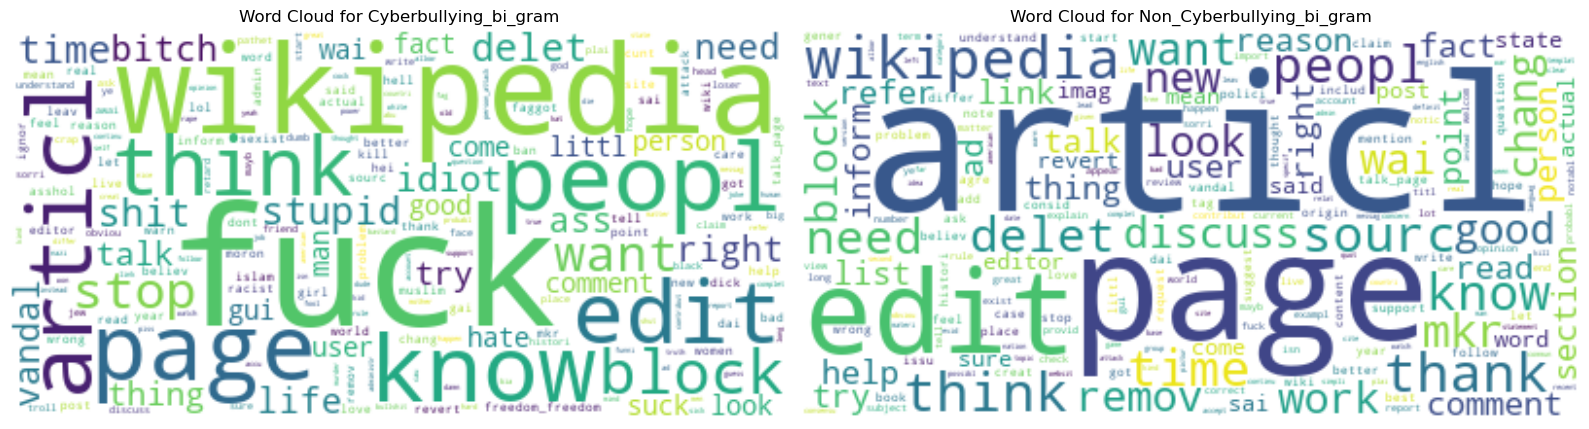

In [539]:
generate_worldcloud_vis(df_bigrams)

In [540]:
def generate_top_n_words_vis(df_bigrams, top_n, color):
    tokens = [ 'uni_gram','bi_gram']
    # Separate the texts by label
    #for token in tokens:
    for token in tokens:
    #     top_n = 30
    #     color= ['red','blue']
        no_cb_tokens = ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['Labels'] == 0][token]])
        cb_tokens= ' '.join([' '.join(tokens) for tokens in df_bigrams[df_bigrams['Labels'] == 1][token]])

        word_freq_no_cb = Counter(no_cb_tokens.split())
        most_common_no_cb = word_freq_no_cb.most_common(top_n)
        word_freq_no_cb = Counter(cb_tokens.split())
        most_common_cb = word_freq_no_cb.most_common(top_n)



        df2 = pd.DataFrame(most_common_no_cb, columns=['word', 'Non_Cyberbullyiing'])
        df1 = pd.DataFrame(most_common_cb, columns=['word', 'Cyberbullyiing'])

        # Merge the two dataframes on the word
        merged_df = pd.merge(df1, df2, on='word', how='outer').fillna(0)

        # Sort by one of the counts (optional)
        merged_df = merged_df.sort_values(by='Cyberbullyiing', ascending=False)

        # Create side by side bar charts
        ax = merged_df.plot.bar(x='word', y=['Cyberbullyiing', 'Non_Cyberbullyiing'], figsize=(28,8), color=color)

        # Set title and y-label
        ax.set_title(f'Comparison of Top {top_n} {token}')
        ax.set_ylabel('Count')
        #ax.set_xlabel('Words', fontsize=14)

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(merged_df['word'], rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

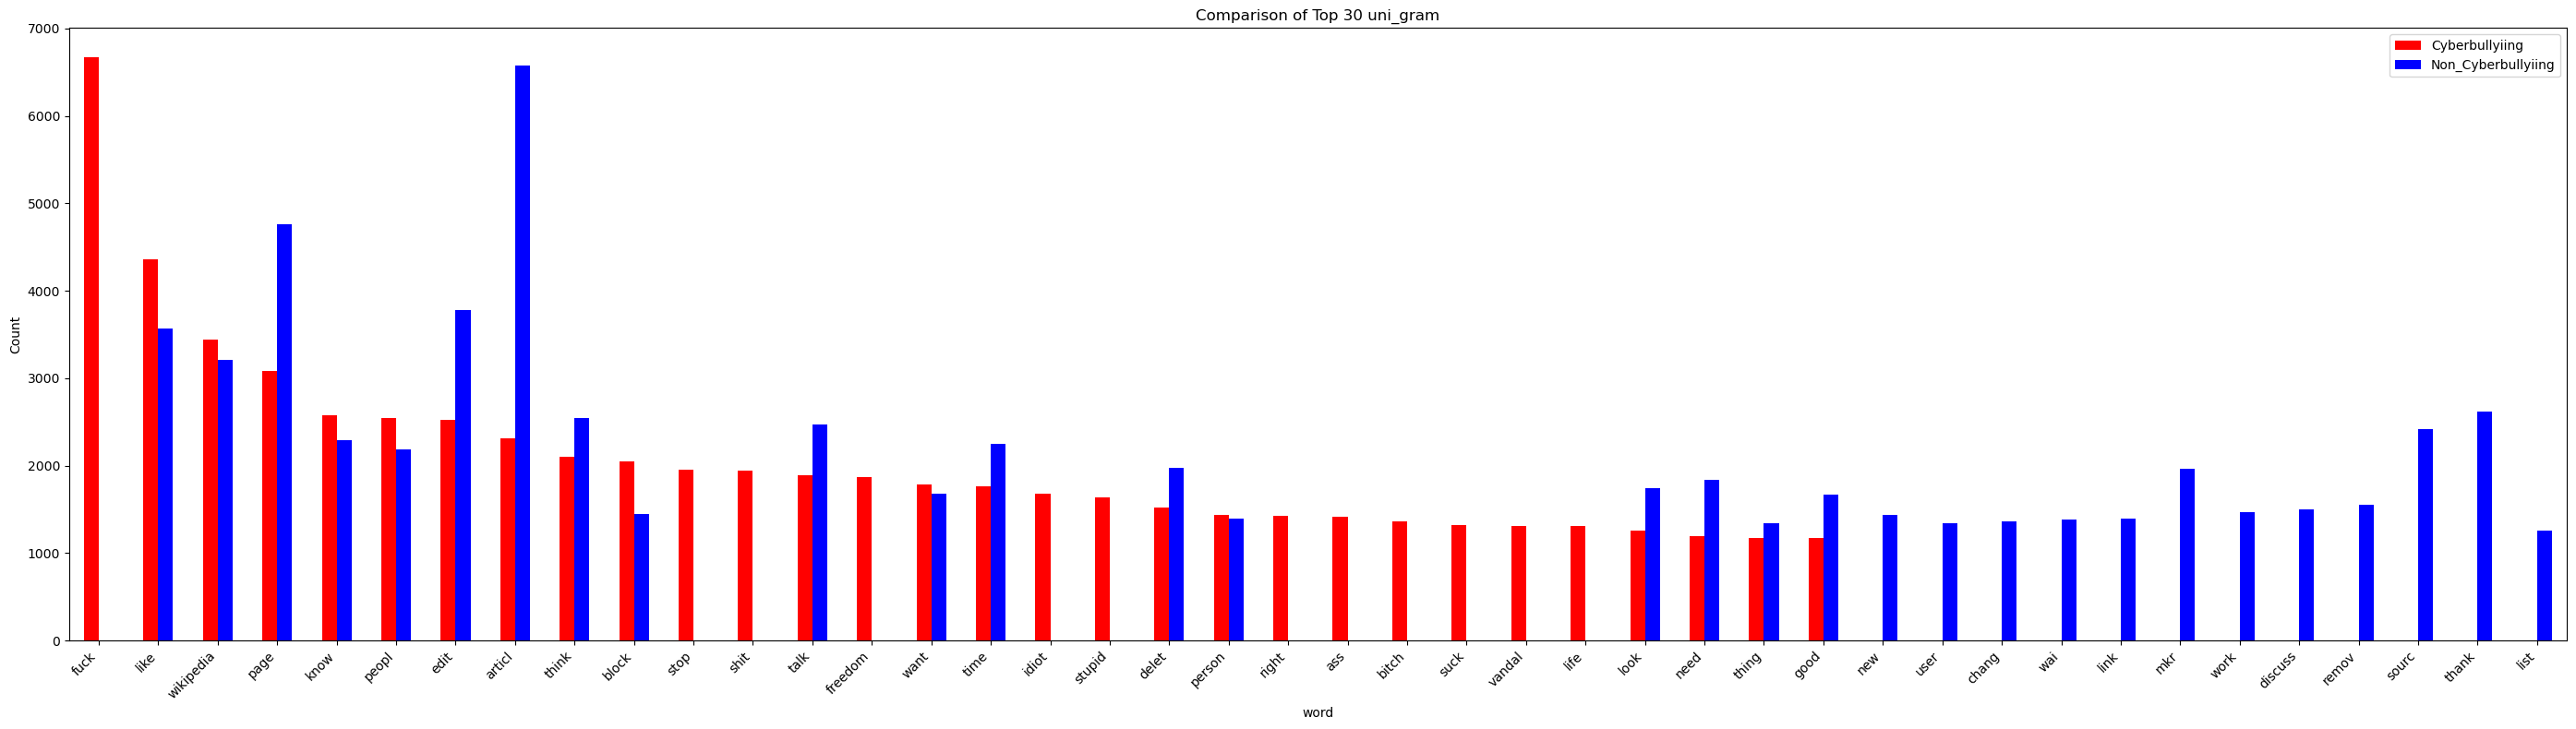

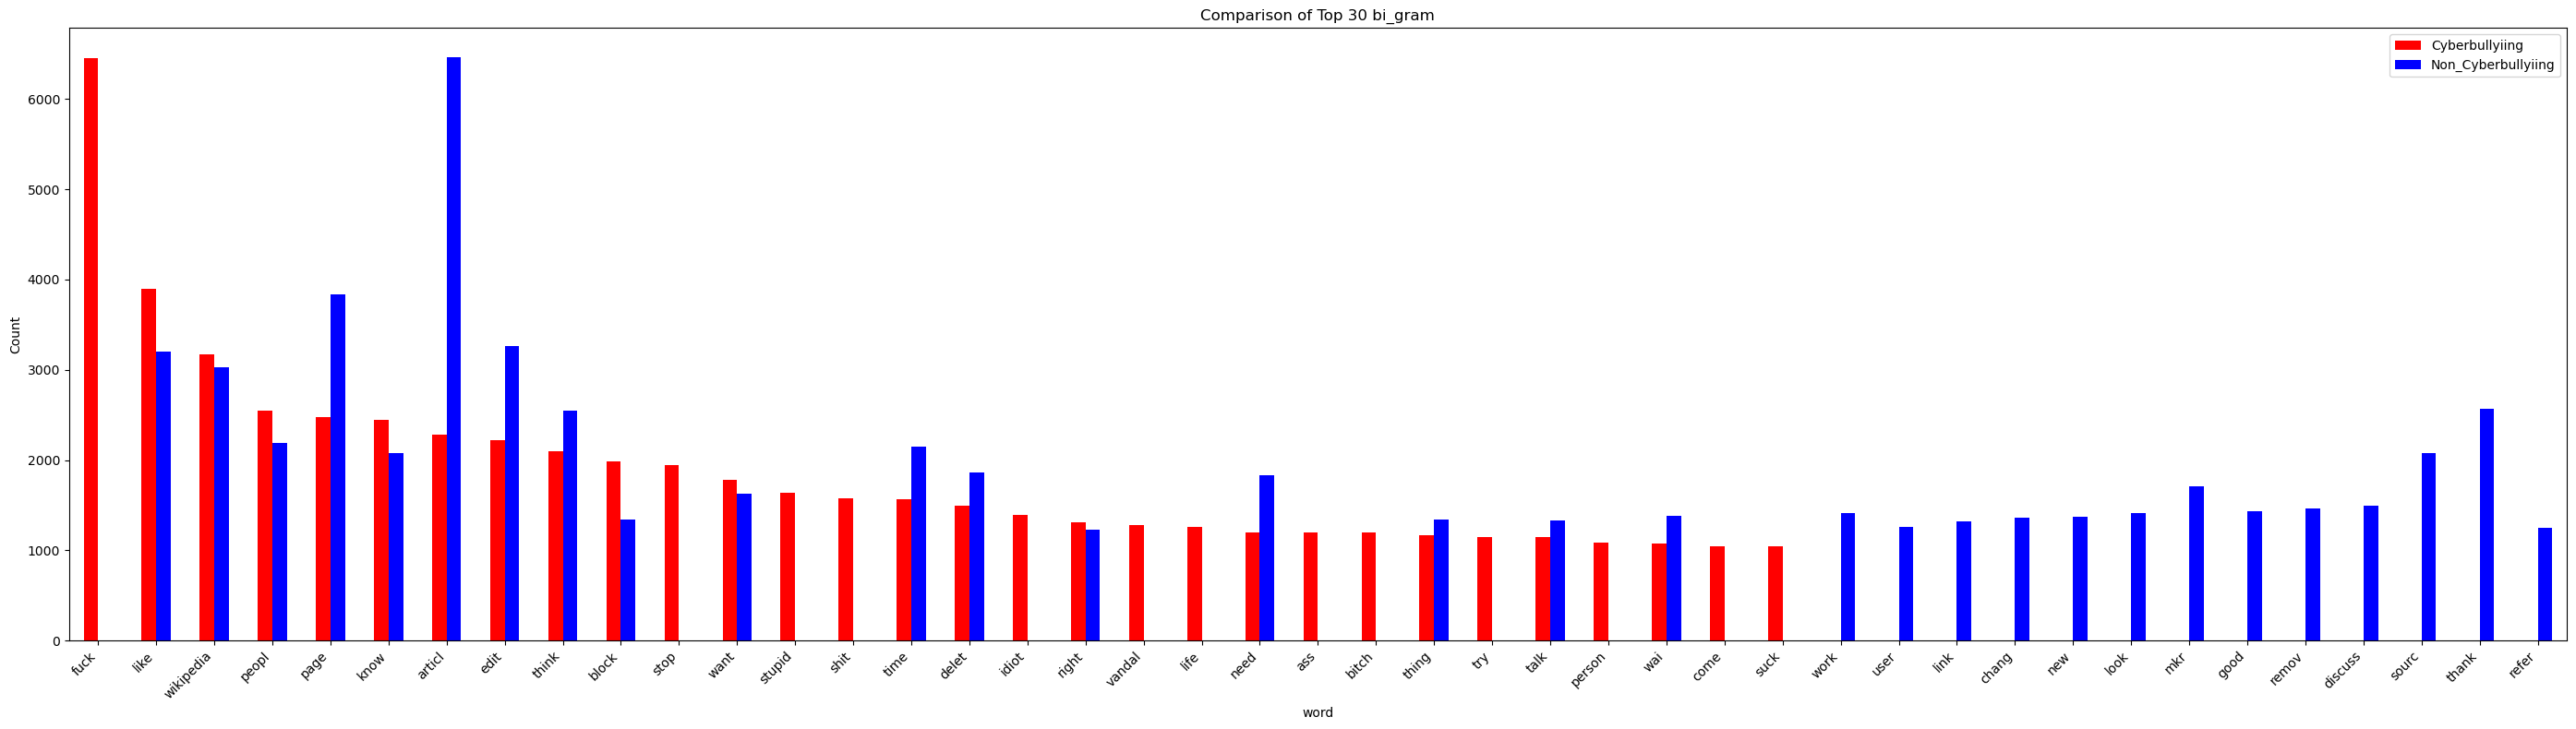

In [541]:
color= ['red','blue']
top_n = 30
generate_top_n_words_vis(df_bigrams, top_n, color)

# Wikipedia seems to be a frequent word, need to check if there is an outlier/ or we sample to many records from wiki

do we need to normalize the token/remove some outliers?

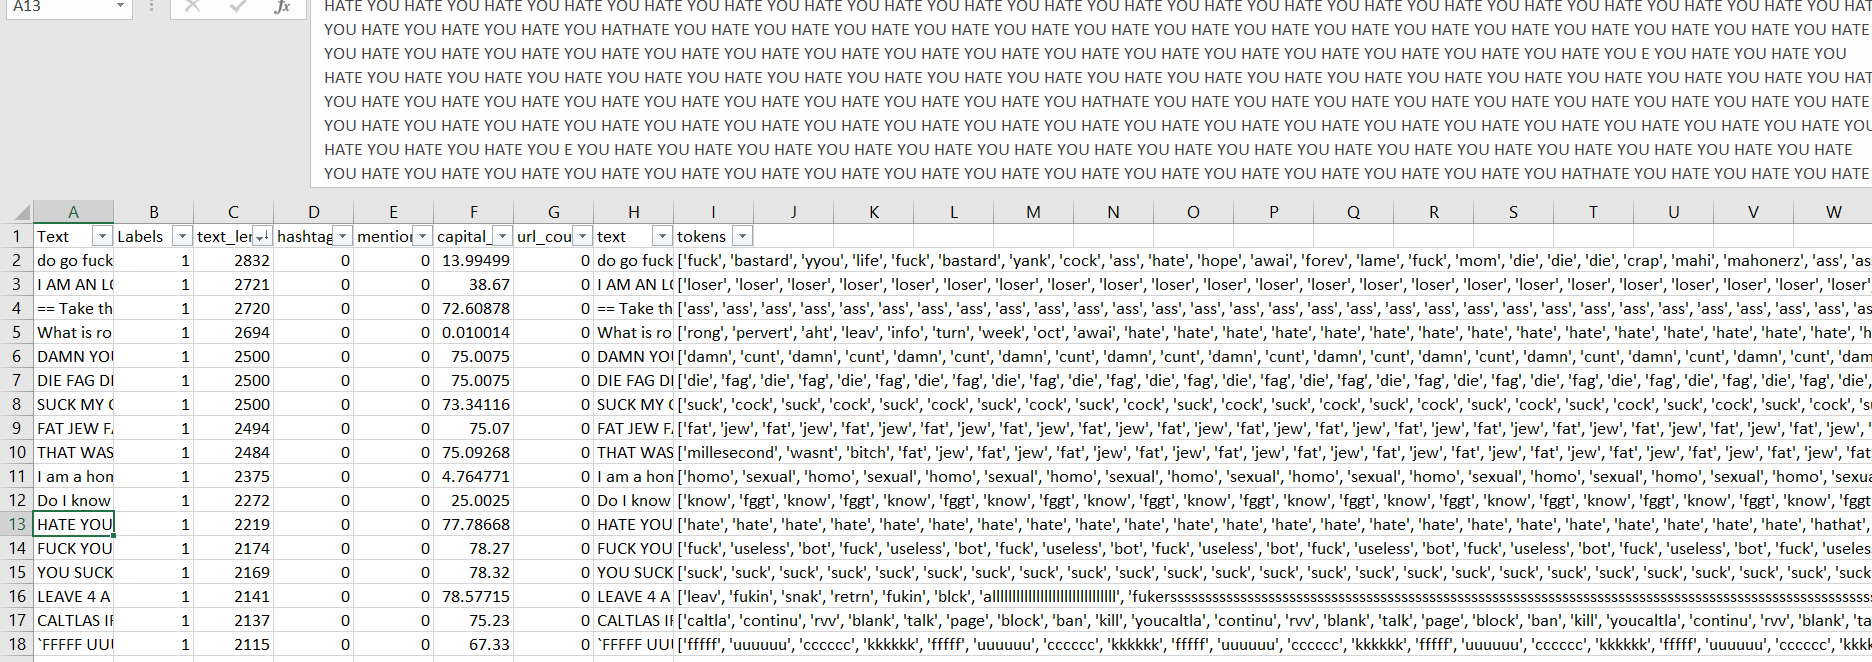

## Create a function to create a topic model

In [542]:
def find_topics(tokens, num_topics):



    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=10, no_above=0.6, )

    corpus = [dictionary.doc2bow(text) for text in tokens]

    # lda_model = LdaModel(corpus, num_topics=num_topics,id2word=dictionary,chunksize=2000,
    #                      passes=20,iterations=400,eval_every=None,random_state=42,alpha='auto',eta='auto')
    
    from gensim.models.ldamulticore import LdaMulticore

    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'


    #raise NotImplementedError()
    return lda_model.top_topics(corpus) 

#uncomment to test, and try increasing the number of topics to see how the output changes!  
#note that this function can take a minute or more to run per topic.
# The function can take a minute or more to run.


## unigram

In [543]:
find_topics(df_bigrams['tokens'].dropna(), num_topics=1) # do we want to use unigram or bigram

Exception ignored in: <built-in method acquire of _thread.lock object at 0x14f8b1f1e640>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.10-anaconda/2023.03/lib/python3.10/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid = os.fork()
KeyboardInterrupt: 
Process ForkPoolWorker-1056:
Process ForkPoolWorker-1059:
Exception ignored in: <function _releaseLock at 0x14f8b3ff0430>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.10-anaconda/2023.03/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-1057:
Process ForkPoolWorker-1055:
Process ForkPoolWorker-1053:
Process ForkPoolWorker-1058:
Process ForkPoolWorker-1054:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/sw/

KeyboardInterrupt: 

Process ForkPoolWorker-1072:
Process ForkPoolWorker-1077:
Process ForkPoolWorker-1076:
Process ForkPoolWorker-1066:
Process ForkPoolWorker-1070:
Process ForkPoolWorker-1067:
Process ForkPoolWorker-1071:
Process ForkPoolWorker-1075:
Process ForkPoolWorker-1082:
Process ForkPoolWorker-1065:
Process ForkPoolWorker-1063:
Process ForkPoolWorker-1081:
Process ForkPoolWorker-1084:
Process ForkPoolWorker-1064:
Process ForkPoolWorker-1078:
Process ForkPoolWorker-1087:
Process ForkPoolWorker-1080:
Process ForkPoolWorker-1060:
Traceback (most recent call last):
Process ForkPoolWorker-1062:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-1061:
Traceback (most recent call last):


## Visualize coherence as the number of topics varies from 2 to 10

In [ ]:
def calculate_avg_coherence(topics):

    avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)
   
    return avg_topic_coherence

def plot_coherences_topics(tokens):

    topics_range = range(2, 11, 1)
    model_results = {'Topics': [],'Coherence': []}
    coherence = []
    for i in topics_range:
        topics = find_topics(tokens, num_topics=i)
        coherence.append(calculate_avg_coherence(topics))
    
    model_results['Topics'] = topics_range
    model_results['Coherence'] = coherence
    plt = pd.DataFrame(model_results).set_index('Topics').plot()

# tweets_tokens = clean_tokenize_text(pd.read_pickle('assets/tweets.pkl'))
# tweets_bigrams = append_bigrams(tweets_tokens)
df_bigrams = df_bigrams.dropna()
coherences_df = plot_coherences_topics(df_bigrams['tokens'])

In [ ]:
find_topics(df_bigrams['uni_gram'].dropna(), num_topics=3)

In [ ]:
#find_topics(df_bigrams['uni_gram'].dropna(), num_topics=8)

# split by bullying and non bullying

## bigram

In [ ]:
find_topics(df_bigrams['bi_gram'].dropna(), num_topics=3)

In [ ]:
df_bigrams[df_bigrams['Labels'] == 0]['bi_gram']

In [ ]:
find_topics(df_bigrams[df_bigrams['Labels'] == 0]['bi_gram'].dropna(), num_topics=3)

In [ ]:
find_topics(df_bigrams[df_bigrams['Labels'] == 1]['bi_gram'].dropna(), num_topics=3)

In [ ]:
#use tfidf


In [ ]:
from gensim.models import TfidfModel

In [ ]:
def find_topics(tokens, num_topics):



    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=10, no_above=0.6, )

    corpus = [dictionary.doc2bow(text) for text in tokens]
    
    tfidf_model = TfidfModel(corpus)
    corpus_tfidf = tfidf_model[corpus]

    # lda_model = LdaModel(corpus, num_topics=num_topics,id2word=dictionary,chunksize=2000,
    #                      passes=20,iterations=400,eval_every=None,random_state=42,alpha='auto',eta='auto')
    
    from gensim.models.ldamulticore import LdaMulticore

    lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, chunksize=2000,
                         passes=20, iterations=400, eval_every=None, random_state=42,
                         eta='auto', workers=None)  # Omitted alpha='auto'


    #raise NotImplementedError()
    return lda_model.top_topics(corpus) 

#uncomment to test, and try increasing the number of topics to see how the output changes!  
#note that this function can take a minute or more to run per topic.
# The function can take a minute or more to run.


In [ ]:
find_topics(df_bigrams['uni_gram'].dropna(), num_topics=3)

In [ ]:
no_cb_df = balanced_df[balanced_df['Labels'] == 0]
cb_df = balanced_df[balanced_df['Labels'] == 1]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Text length distribution for Non-Cyberbullying
sns.histplot(no_cb_df['text_len'], ax=axes[0], color='blue', bins=100)
axes[0].set_title('Text Length Distribution for Non-Cyberbullying')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')

# Text length distribution for Cyberbullying
sns.histplot(cb_df['text_len'], ax=axes[1], color='gray', bins=100)
axes[1].set_title('Text Length Distribution for Cyberbullying')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
no_cb_df = balanced_df[balanced_df['Labels'] == 0]
cb_df = balanced_df[balanced_df['Labels'] == 1]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Text length distribution for Non-Cyberbullying
sns.histplot(no_cb_df['text_len'], ax=axes[0], color='blue', bins=100)
axes[0].set_title('Text Length Distribution for Non-Cyberbullying')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
# Text length distribution for Cyberbullying
sns.histplot(cb_df['text_len'], ax=axes[1], color='gray', bins=100)
axes[1].set_title('Text Length Distribution for Cyberbullying')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
# Display the plots
plt.tight_layout()
plt.show()

## add column # of hashtag, # of @, # of capital letters, calucate the % of capital letters

In [ ]:
def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

In [ ]:
balanced_df['hashtag_count'] = balanced_df['Text'].apply(count_hashtags)

In [ ]:
balanced_df

In [ ]:
# Create subplots
no_cb_df = balanced_df[balanced_df['Labels'] == 0]
cb_df = balanced_df[balanced_df['Labels'] == 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Text length distribution for Non-Cyberbullying
sns.histplot(no_cb_df['hashtag_count'], ax=axes[0], color='blue', bins=100)
axes[0].set_title('hashtag_count Distribution for Non-Cyberbullying')
axes[0].set_xlabel('hashtag_count')
axes[0].set_ylabel('Frequency')

# Text length distribution for Cyberbullying
sns.histplot(cb_df['hashtag_count'], ax=axes[1], color='gray', bins=100)
axes[1].set_title('hashtag_count Distribution for Cyberbullying')
axes[1].set_xlabel('hashtag_count')
axes[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Filter and sort data based on labels
top_no_cb_data = no_cb_df.sort_values(by='hashtag_count', ascending=False).head(100)['hashtag_count']
top_cb_data = cb_df.sort_values(by='hashtag_count', ascending=False).head(100)['hashtag_count']

# Create two subplots: one for each label
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
ax1, ax2 = axs

# Plotting the data for label 1
ax1.hist(top_no_cb_data, color='blue', bins=100)
ax1.set_title("Top 100 hashtag_count Distribution for Label 1")
ax1.set_ylabel("Frequency")

# Plotting the data for label 2
ax2.hist(top_cb_data, color='gray', bins=100)
ax2.set_title("Top 100 hashtag_count Distribution for Label 2")
ax2.set_xlabel("hashtag_count")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show

In [ ]:
def count_mentions(text):
    return text.count('@')

In [ ]:
balanced_df['mentions_count'] = balanced_df['Text'].apply(count_mentions)

In [ ]:
# Create subplots
no_cb_df = balanced_df[balanced_df['Labels'] == 0]
cb_df = balanced_df[balanced_df['Labels'] == 1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Text length distribution for Non-Cyberbullying
sns.histplot(no_cb_df['mentions_count'], ax=axes[0], color='blue', bins=20)
axes[0].set_title('mentions_count Distribution for Non-Cyberbullying')
axes[0].set_xlabel('mentions_count')
axes[0].set_ylabel('Frequency')
# axes[0].set_yscale('log')  # Setting the y-axis to logarithmic scale
# axes[0].set_xscale('log')

# Text length distribution for Cyberbullying
sns.histplot(cb_df['mentions_count'], ax=axes[1], color='gray', bins=20)
axes[1].set_title('mentions_count Distribution for Cyberbullying')
axes[1].set_xlabel('mentions_count')
axes[1].set_ylabel('Frequency')
# axes[1].set_yscale('log')  # Setting the y-axis to logarithmic scale
# axes[1].set_xscale('log')
# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Filter and sort data based on labels
top_no_cb_data = no_cb_df.sort_values(by='mentions_count', ascending=False).head(100)['mentions_count']
top_cb_data = cb_df.sort_values(by='mentions_count', ascending=False).head(100)['mentions_count']

# Create two subplots: one for each label
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
ax1, ax2 = axs

# Plotting the data for label 1
ax1.hist(top_no_cb_data, color='blue', bins=100)
ax1.set_title("Top 100 mentions_count Distribution for Label 1")
ax1.set_ylabel("Frequency")

# Plotting the data for label 2
ax2.hist(top_cb_data, color='gray', bins=100)
ax2.set_title("Top 100 mentions_count Distribution for Label 2")
ax2.set_xlabel("mentions_count")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
# Define a function to detect outliers 
def remove_outliers(df):
    data_filtered = df[df['mentions_count'] < 100].copy()
    return data_filtered

# Remove outliers for label 2 data
balanced_df_filtered = remove_outliers(balanced_df)

In [ ]:
# Filter and sort data based on labels
no_cb_df = balanced_df_filtered[balanced_df_filtered['Labels'] == 0]
cb_df = balanced_df_filtered[balanced_df_filtered['Labels'] == 1]

top_no_cb_data = no_cb_df.sort_values(by='mentions_count', ascending=False).head(500)['mentions_count']
top_cb_data = cb_df.sort_values(by='mentions_count', ascending=False).head(500)['mentions_count']

# Create two subplots: one for each label
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
ax1, ax2 = axs

# Plotting the data for label 1
ax1.hist(top_no_cb_data, color='blue', bins=200)
ax1.set_title("Top 100 mentions_count Distribution for Label 1")
ax1.set_ylabel("Frequency")

# Plotting the data for label 2
ax2.hist(top_cb_data, color='gray', bins=200)
ax2.set_title("Top 100 mentions_count Distribution for Label 2")
ax2.set_xlabel("mentions_count")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
def capital_percentage(Text):
    #if len(s) == 0:  # handle empty strings
        #return 0
    return sum(1 for char in Text if char.isupper()) / len(Text) * 100

# Apply the function to the Texts column and store the results in a new column
balanced_df_filtered['capital_letter_pct'] = balanced_df_filtered['Text'].apply(capital_percentage)


In [ ]:
# Filter and sort data based on labels
no_cb_df = balanced_df_filtered[balanced_df_filtered['Labels'] == 0]
cb_df = balanced_df_filtered[balanced_df_filtered['Labels'] == 1]

# top_no_cb_data = no_cb_df.sort_values(by='capital_letter_pct', ascending=False).head(100)['capital_letter_pct']
# top_cb_data = cb_df.sort_values(by='capital_letter_pct', ascending=False).head(100)['capital_letter_pct']

# Create two subplots: one for each label
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
ax1, ax2 = axs

# Plotting the data for label 1
ax1.hist(no_cb_df['capital_letter_pct'], color='blue', bins=100)
ax1.set_title("Top 100 capital_letter_pct Distribution for Label 1")
ax1.set_ylabel("Frequency")

# Plotting the data for label 2
ax2.hist(cb_df['capital_letter_pct'], color='gray', bins=100)
ax2.set_title("Top 100 capital_letter_pct Distribution for Label 2")
ax2.set_xlabel("capital_letter_pct")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()